In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math
import time

from Data import *
from nets.hyper_net import HyperNetwork 
from flows import CNFFlow

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def base_dist():
    return Normal(
        loc=torch.zeros(2, device=device),
        scale=torch.ones(2, device=device),
    )

In [4]:
batch_size = 32
datapath = '/home/mvasist/ProbAI/NormFlows/datasets/'
dset = 'boomerang'
Data = Data(datapath + dset +'.csv')
d = Data.read_csv().to(device)

train_dataloader, test_dataloader = Data.return_dataloaders(batch_size = batch_size)

num_batches = train_dataloader.__len__()
 

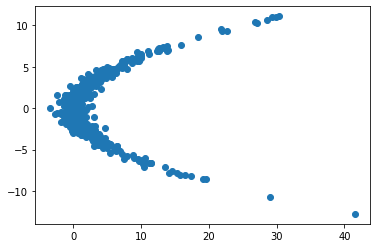

In [5]:
Data.plot_scatter()

## CNF

In [7]:
# model and flow parameters
hidden_dim = 32
width      = 64
t0 = 0  # flow start time
t1 = 1  # flow end time

net = HyperNetwork(in_out_dim=2, hidden_dim=hidden_dim, width=width)

In [8]:
flow_cnf = CNFFlow(net = net, dim= 1, device = device).to(device)
print(flow_cnf.flow)

ModuleList(
  (0): CNF(
    (net): HyperNetwork(
      (fc1): Linear(in_features=1, out_features=32, bias=True)
      (fc2): Linear(in_features=32, out_features=32, bias=True)
      (fc3): Linear(in_features=32, out_features=448, bias=True)
    )
  )
)


Training...
Epoch: 1/100, Loss: 27.084
Epoch: 2/100, Loss: 23.753
Epoch: 3/100, Loss: 21.361
Epoch: 4/100, Loss: 18.563
Epoch: 5/100, Loss: 16.666
Epoch: 6/100, Loss: 15.164
Epoch: 7/100, Loss: 14.051
Epoch: 8/100, Loss: 13.266
Epoch: 9/100, Loss: 32.578
Epoch: 10/100, Loss: 11.902
Epoch: 11/100, Loss: 11.397
Epoch: 12/100, Loss: 10.990
Epoch: 13/100, Loss: 10.738
Epoch: 14/100, Loss: 10.396
Epoch: 15/100, Loss: 10.175
Epoch: 16/100, Loss: 10.087
Epoch: 17/100, Loss: 9.735
Epoch: 18/100, Loss: 9.875
Epoch: 19/100, Loss: 9.573
Epoch: 20/100, Loss: 9.232


/home/mvasist/ProbAI/NormFlows/Data.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 12))


Epoch: 21/100, Loss: 9.221
Epoch: 22/100, Loss: 8.885
Epoch: 23/100, Loss: 8.727
Epoch: 24/100, Loss: 8.591
Epoch: 25/100, Loss: 8.494
Epoch: 26/100, Loss: 8.437
Epoch: 27/100, Loss: 8.319
Epoch: 28/100, Loss: 8.169
Epoch: 29/100, Loss: 8.925
Epoch: 30/100, Loss: 8.026
Epoch: 31/100, Loss: 7.817
Epoch: 32/100, Loss: 7.857
Epoch: 33/100, Loss: 7.733
Epoch: 34/100, Loss: 7.587
Epoch: 35/100, Loss: 7.499
Epoch: 36/100, Loss: 7.469
Epoch: 37/100, Loss: 7.286
Epoch: 38/100, Loss: 7.212
Epoch: 39/100, Loss: 7.335
Epoch: 40/100, Loss: 7.197
Epoch: 41/100, Loss: 7.598
Epoch: 42/100, Loss: 7.002
Epoch: 43/100, Loss: 7.008
Epoch: 44/100, Loss: 6.921
Epoch: 45/100, Loss: 6.937
Epoch: 46/100, Loss: 6.749
Epoch: 47/100, Loss: 6.798
Epoch: 48/100, Loss: 7.495
Epoch: 49/100, Loss: 6.811
Epoch: 50/100, Loss: 6.759
Epoch: 51/100, Loss: 6.731
Epoch: 52/100, Loss: 6.762
Epoch: 53/100, Loss: 6.652
Epoch: 54/100, Loss: 6.698
Epoch: 55/100, Loss: 6.883
Epoch: 56/100, Loss: 6.667
Epoch: 57/100, Loss: 6.624
E

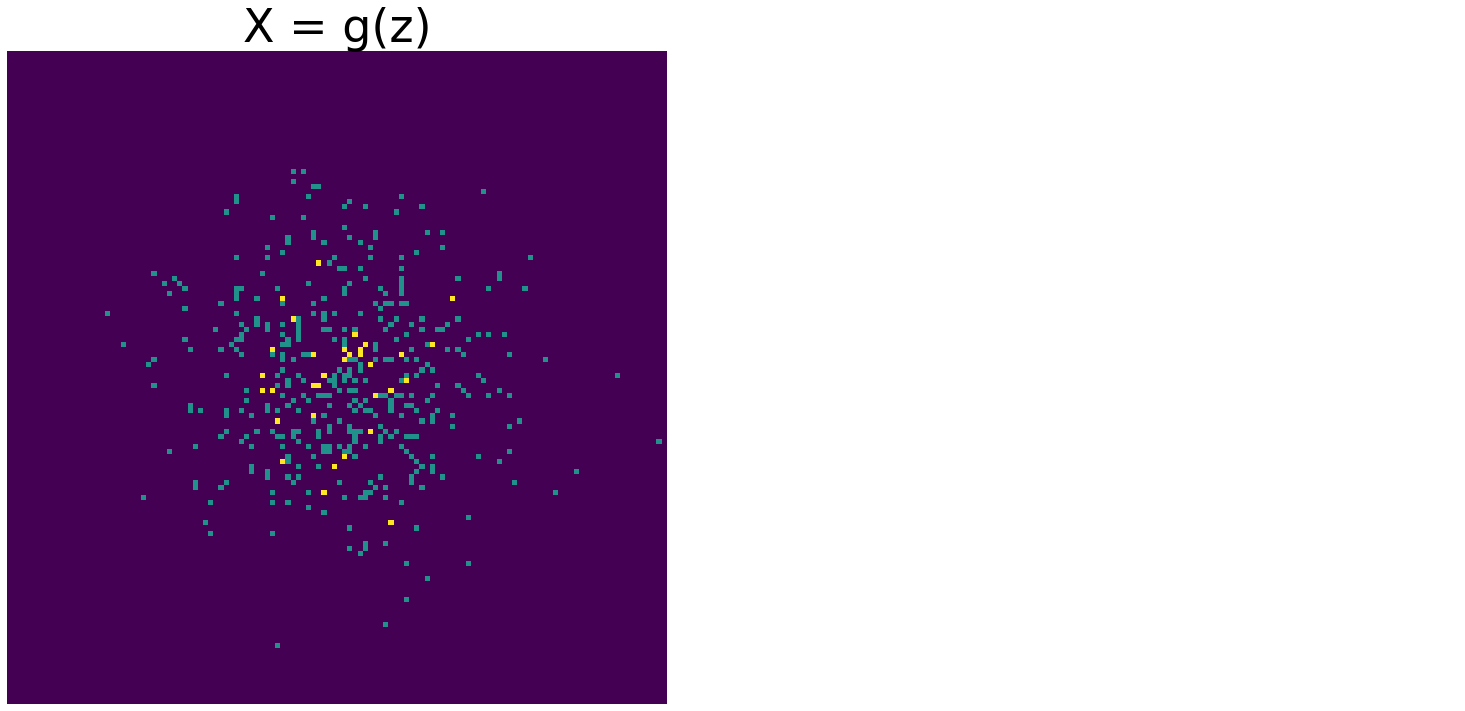

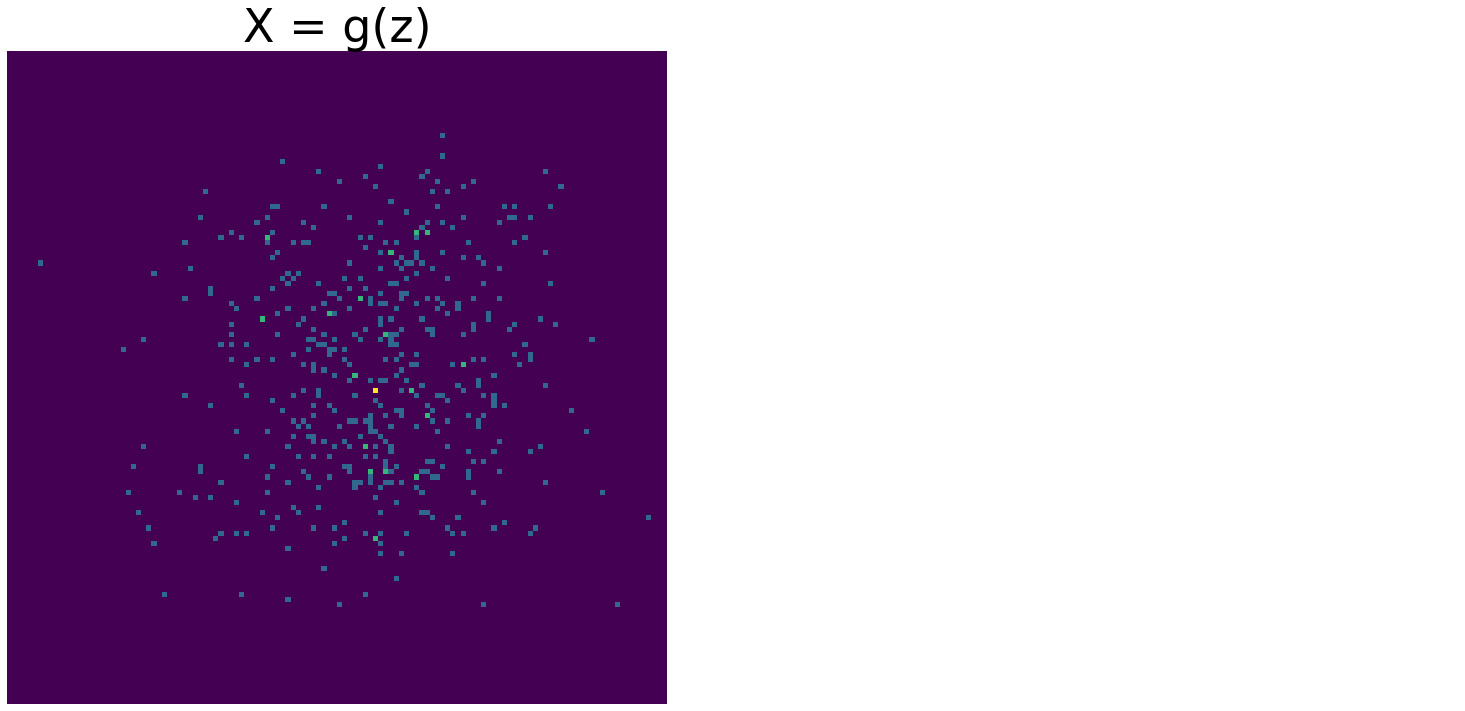

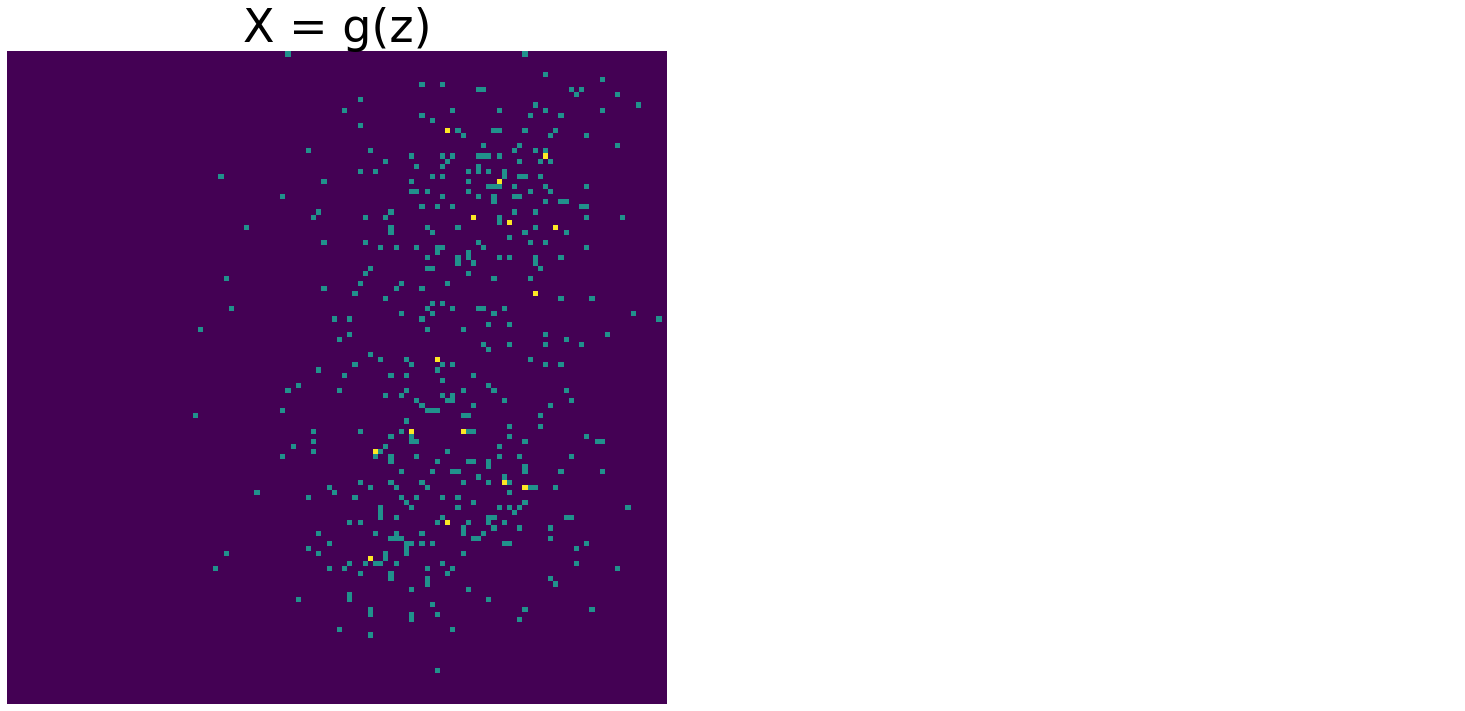

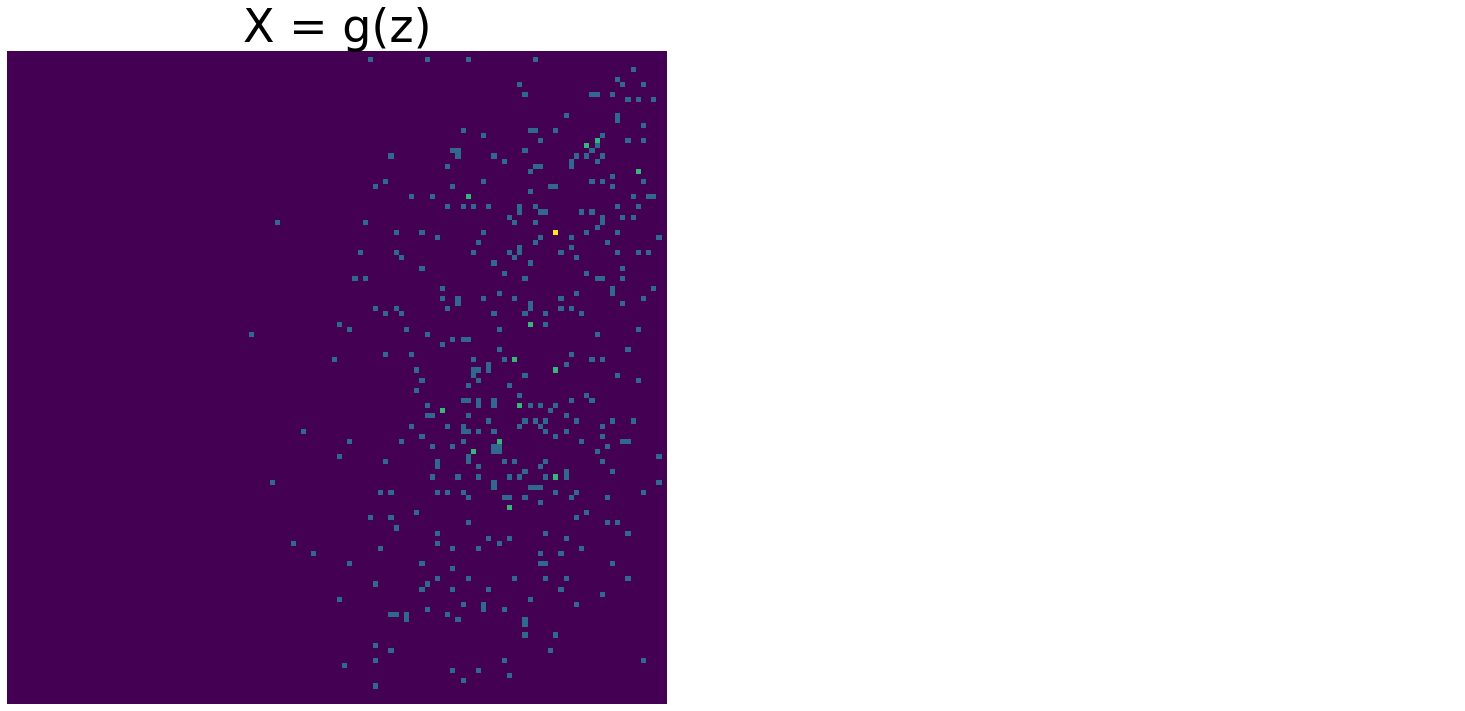

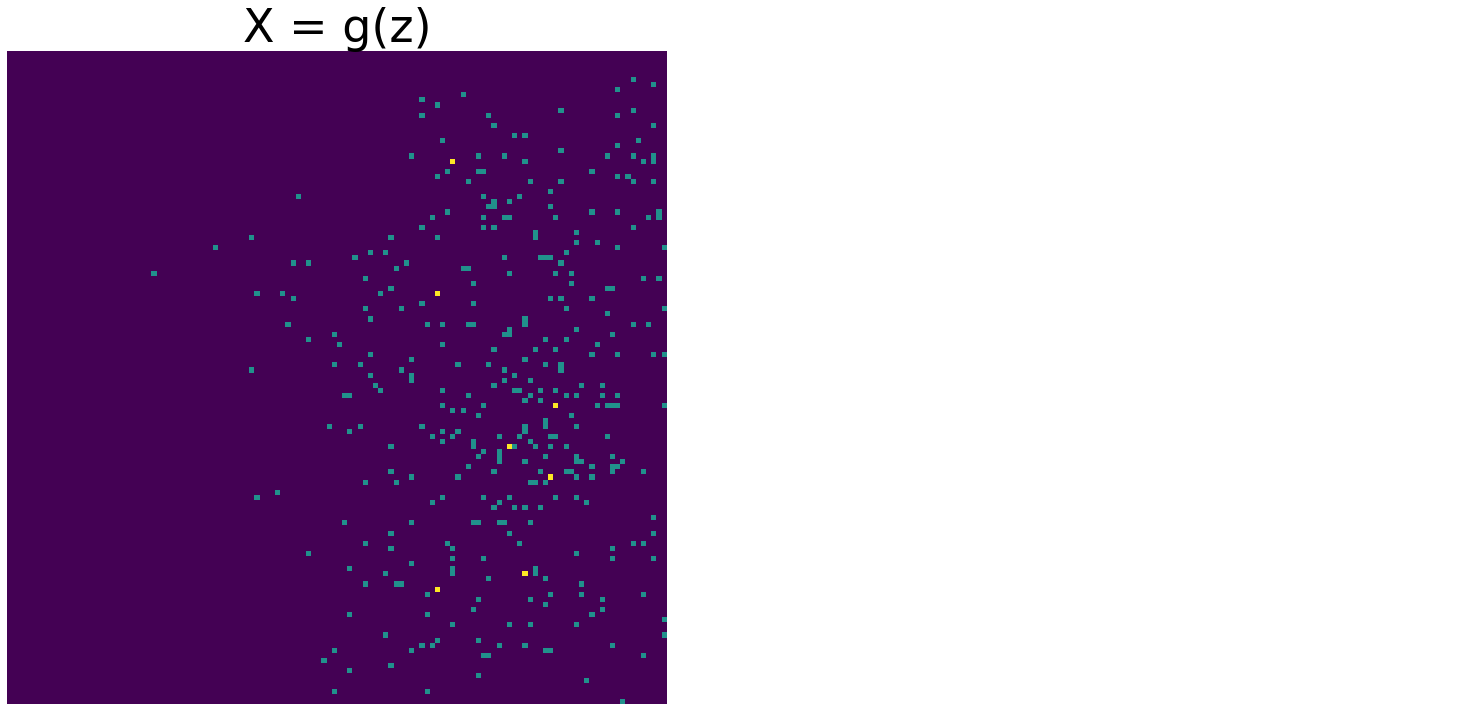

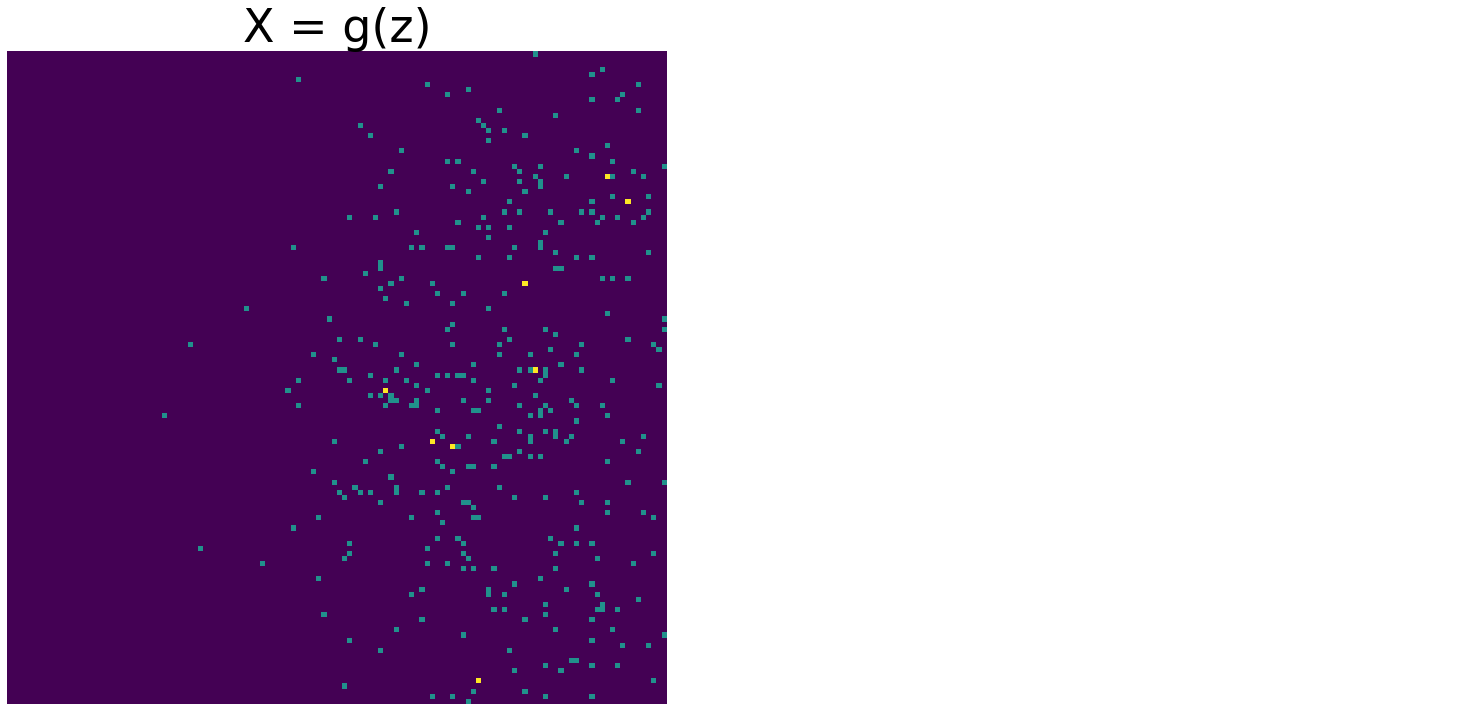

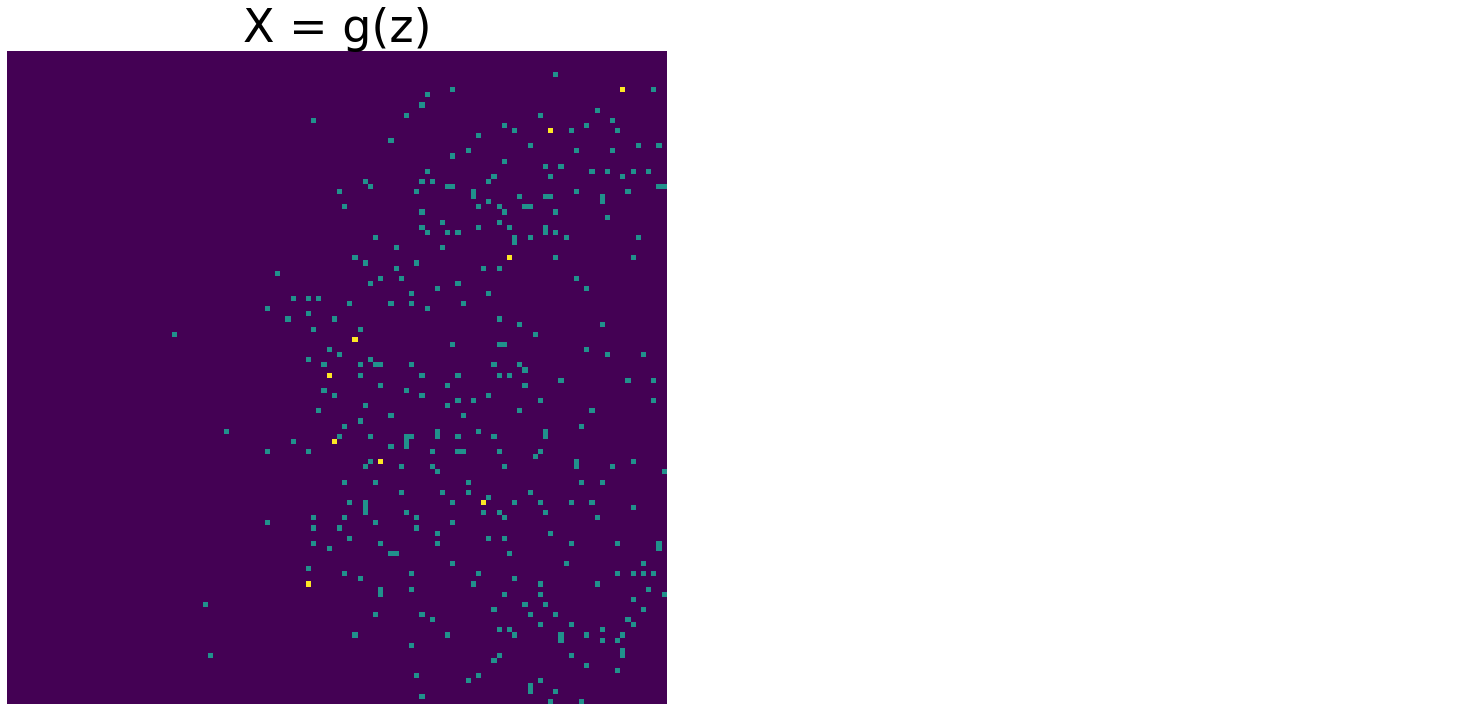

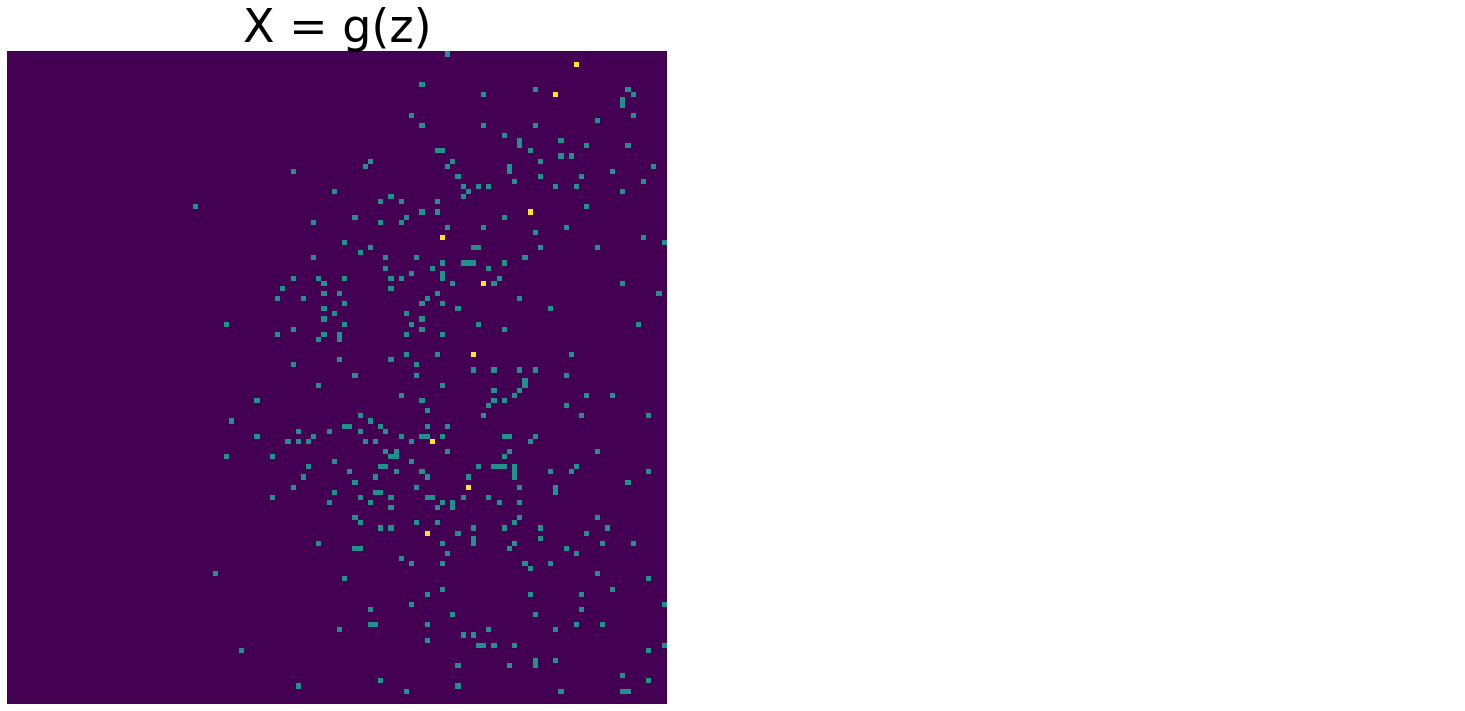

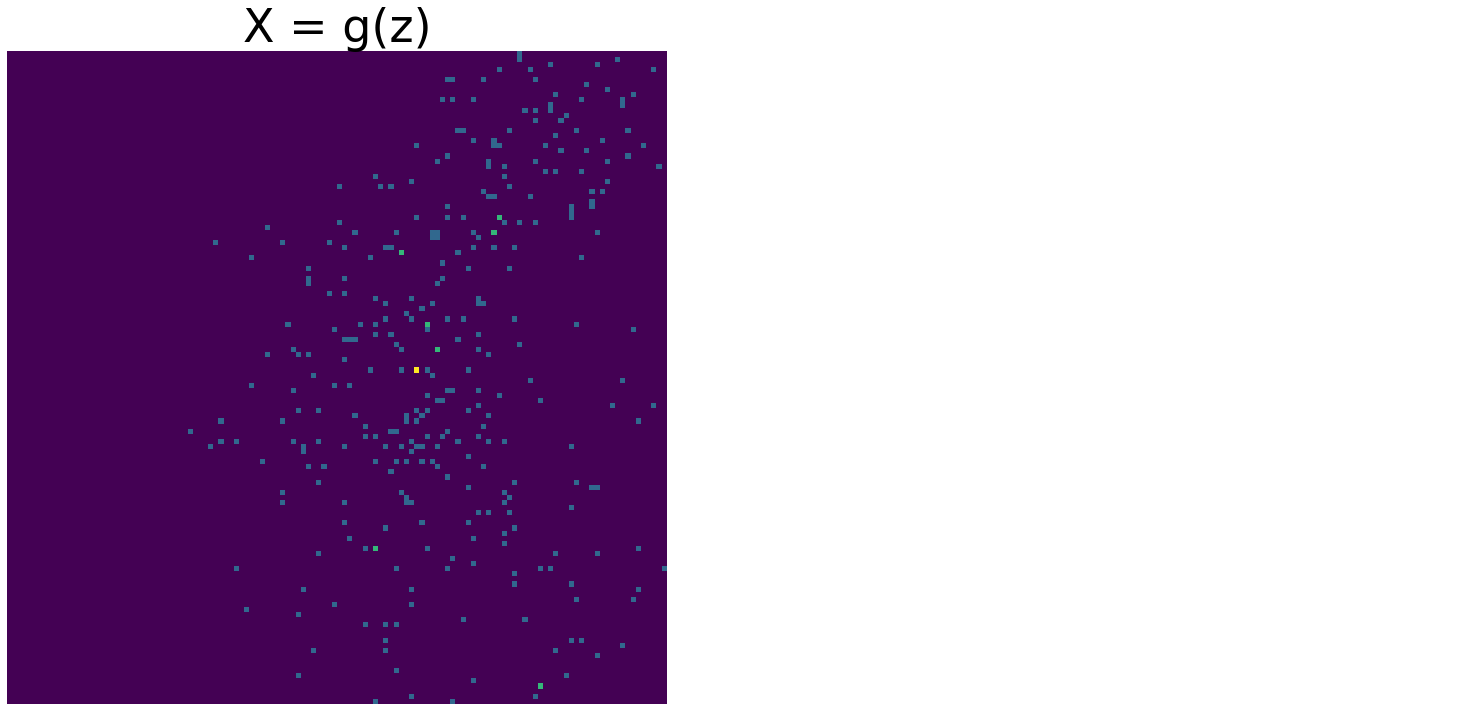

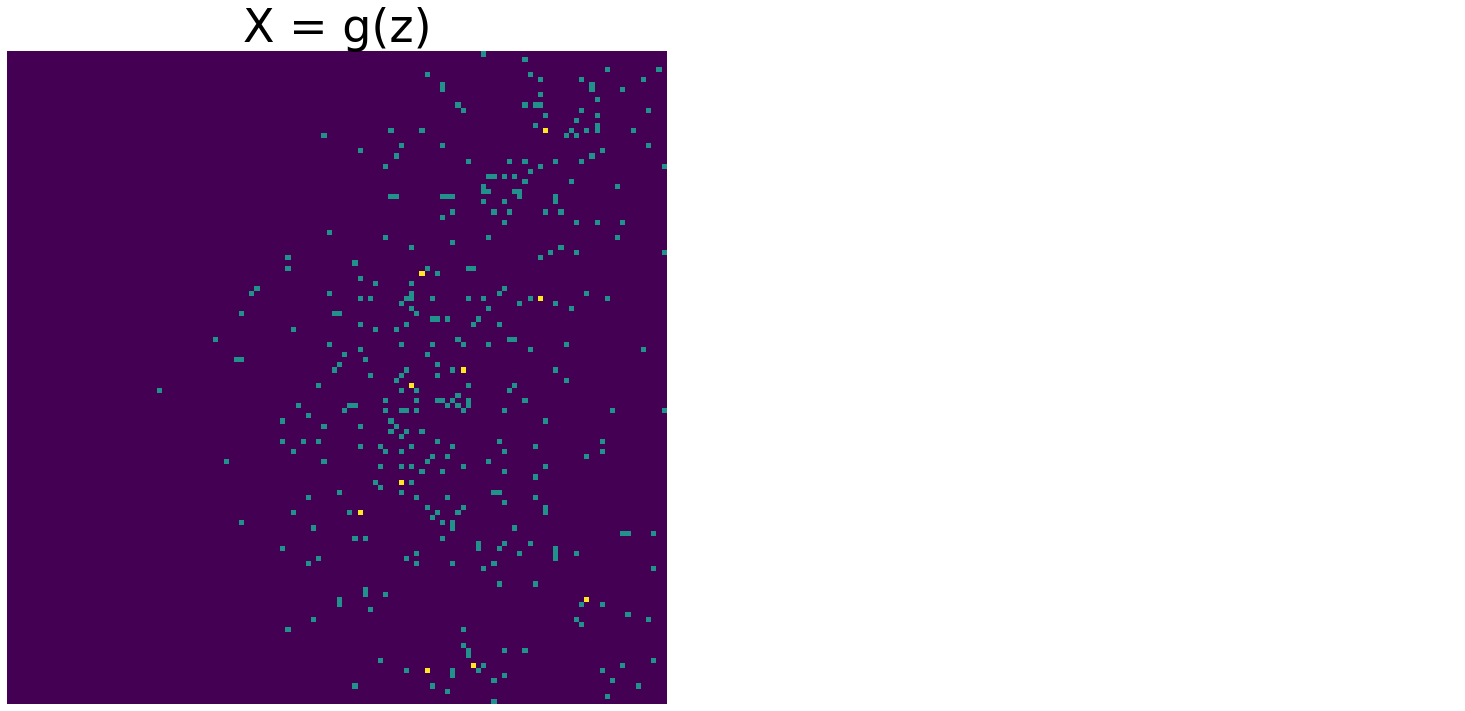

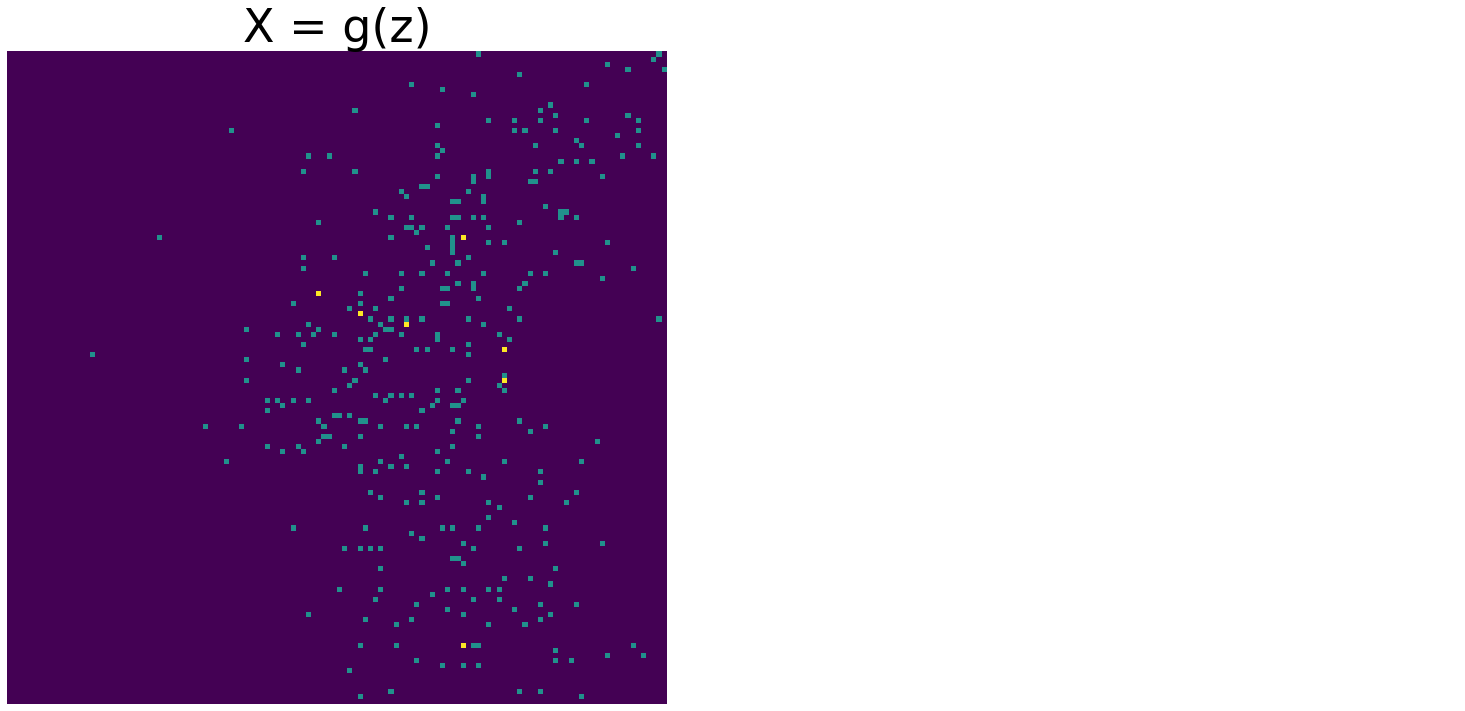

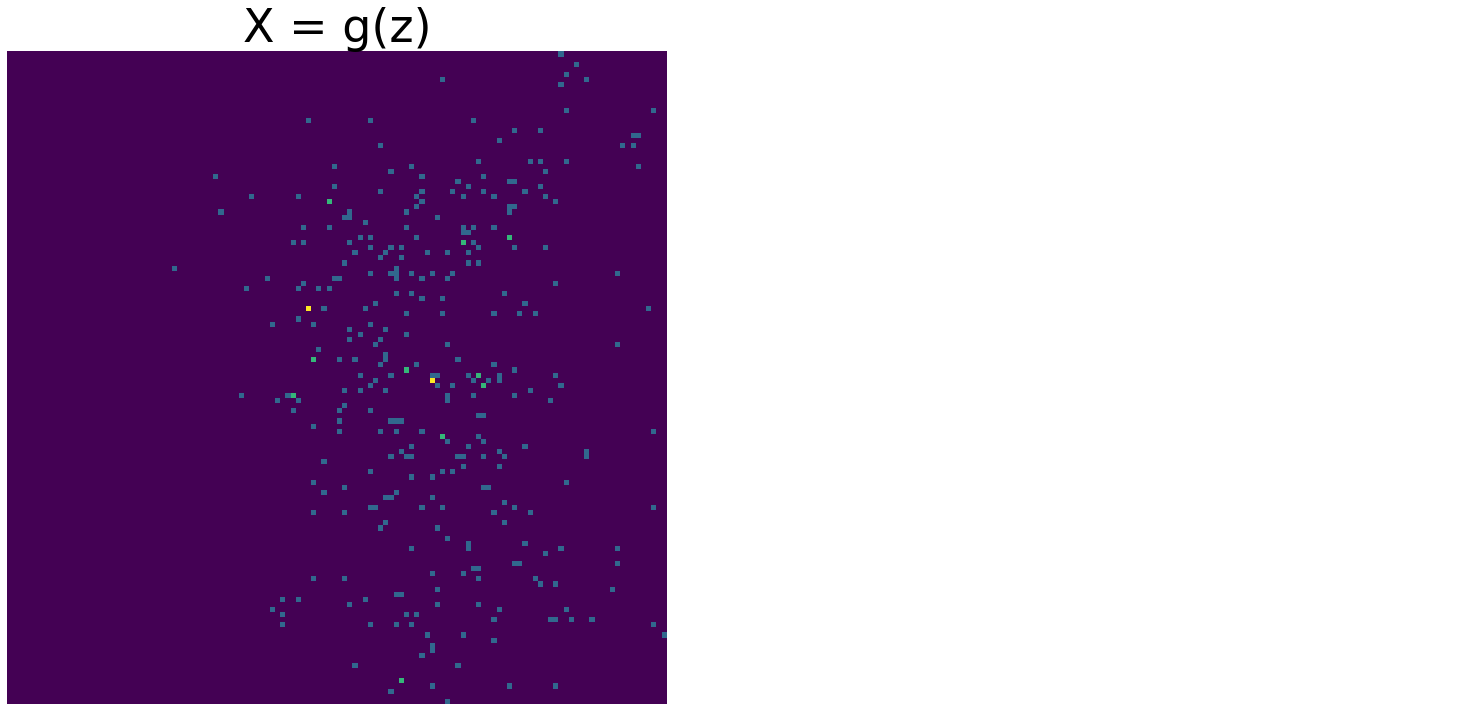

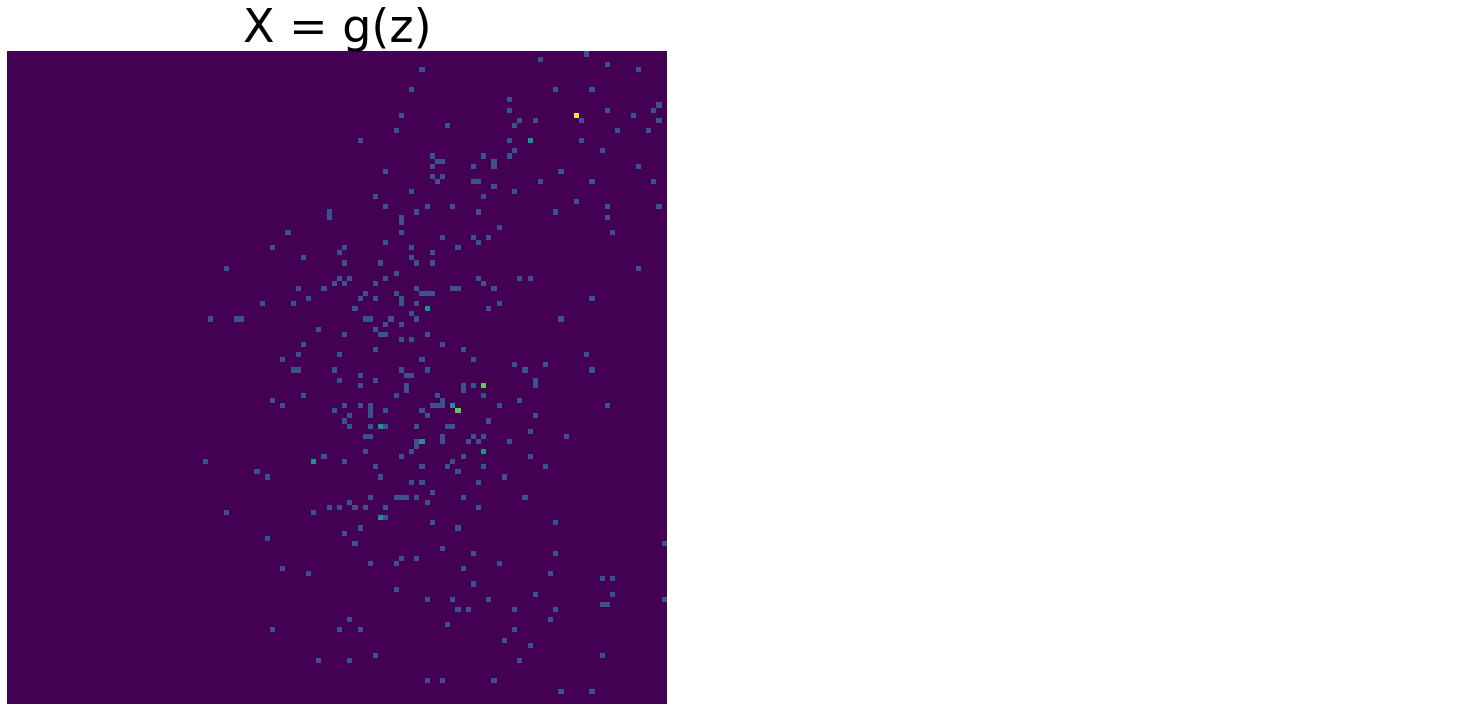

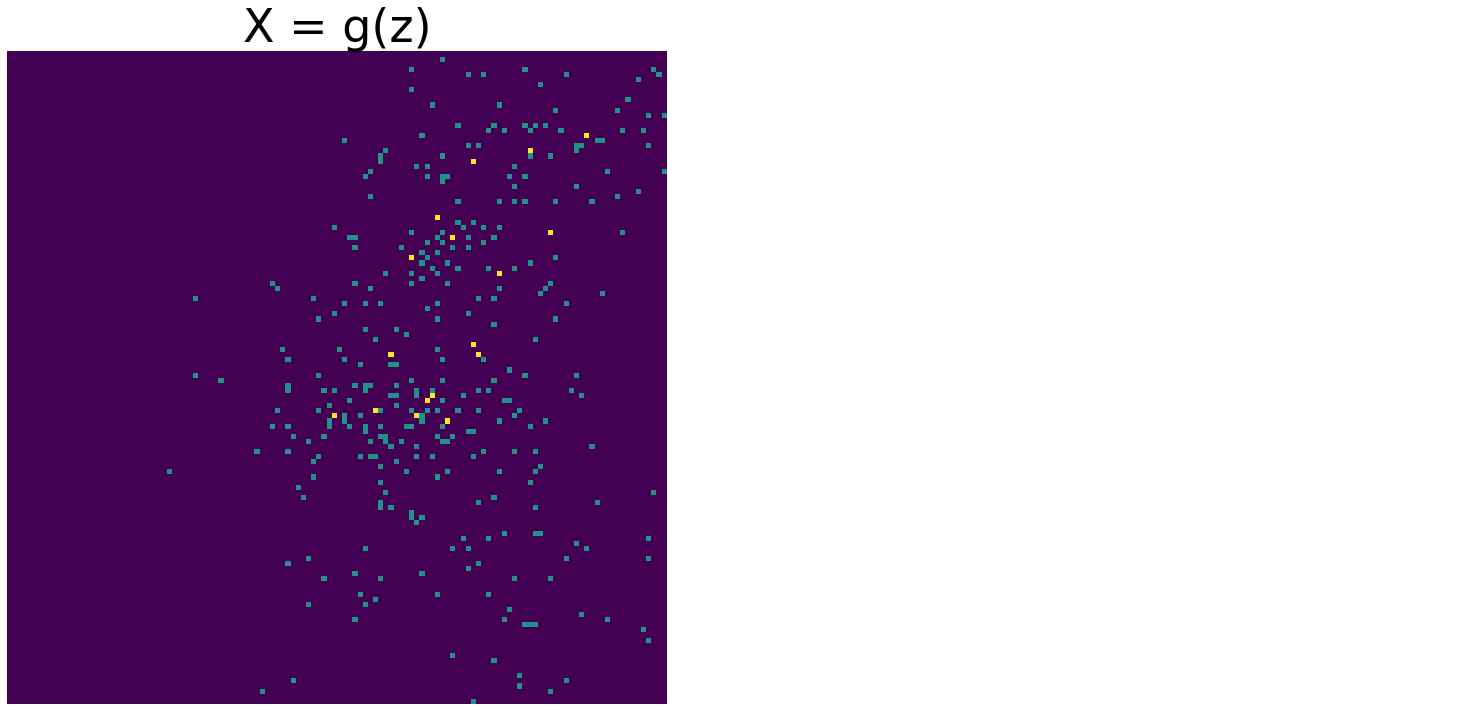

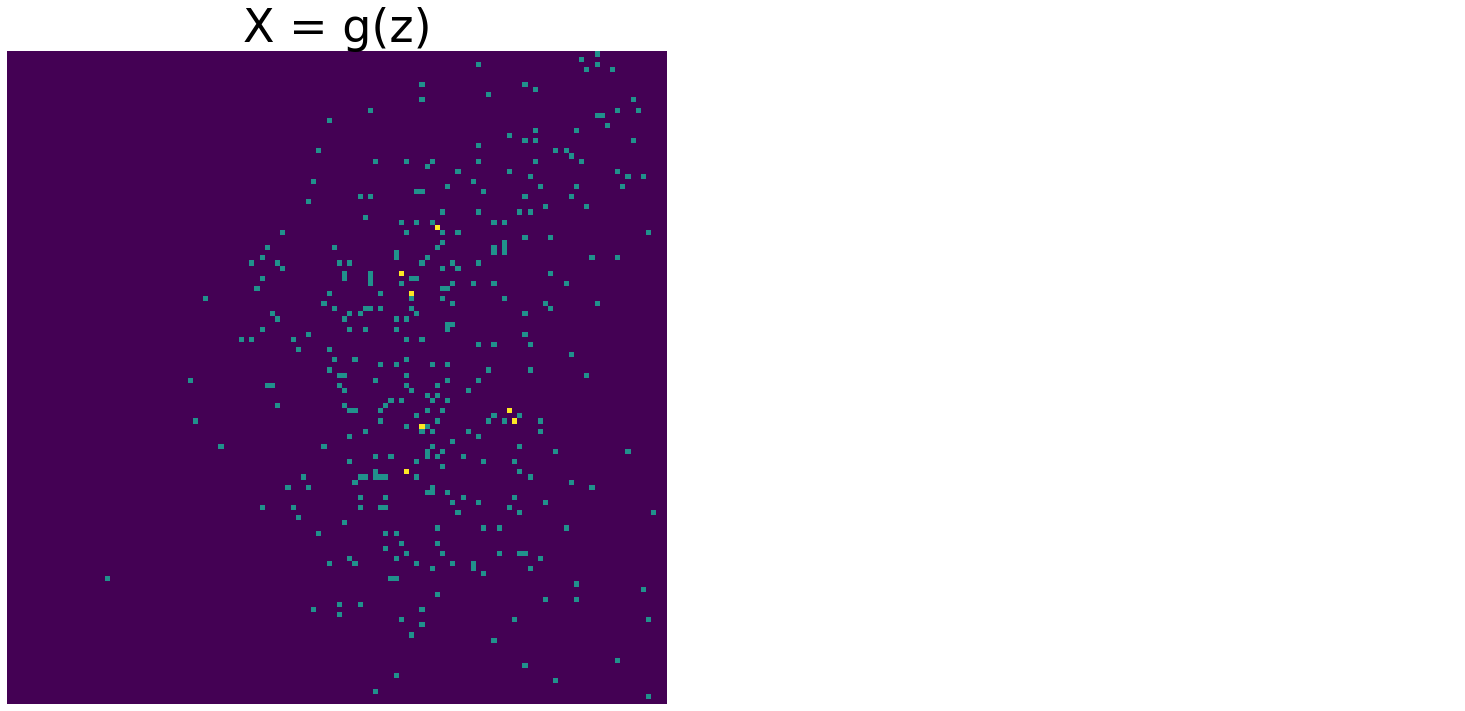

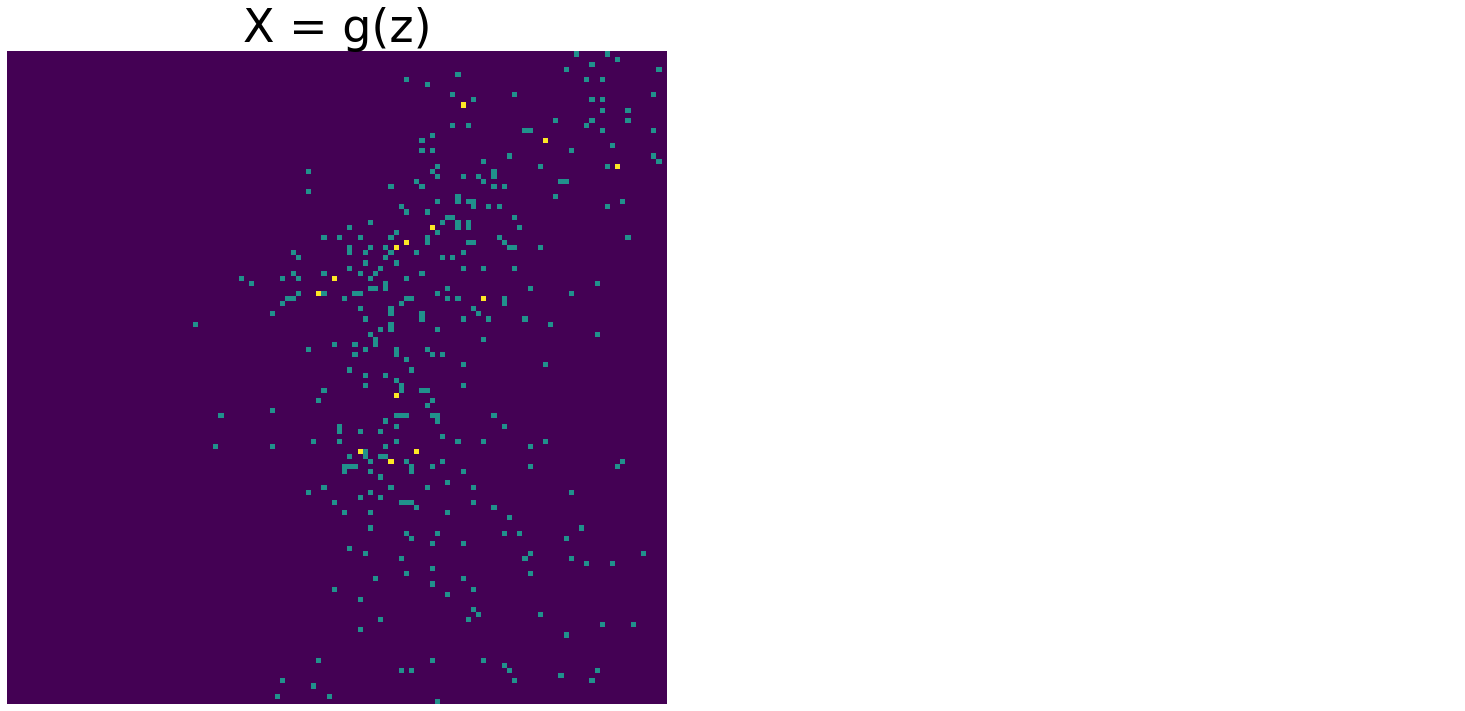

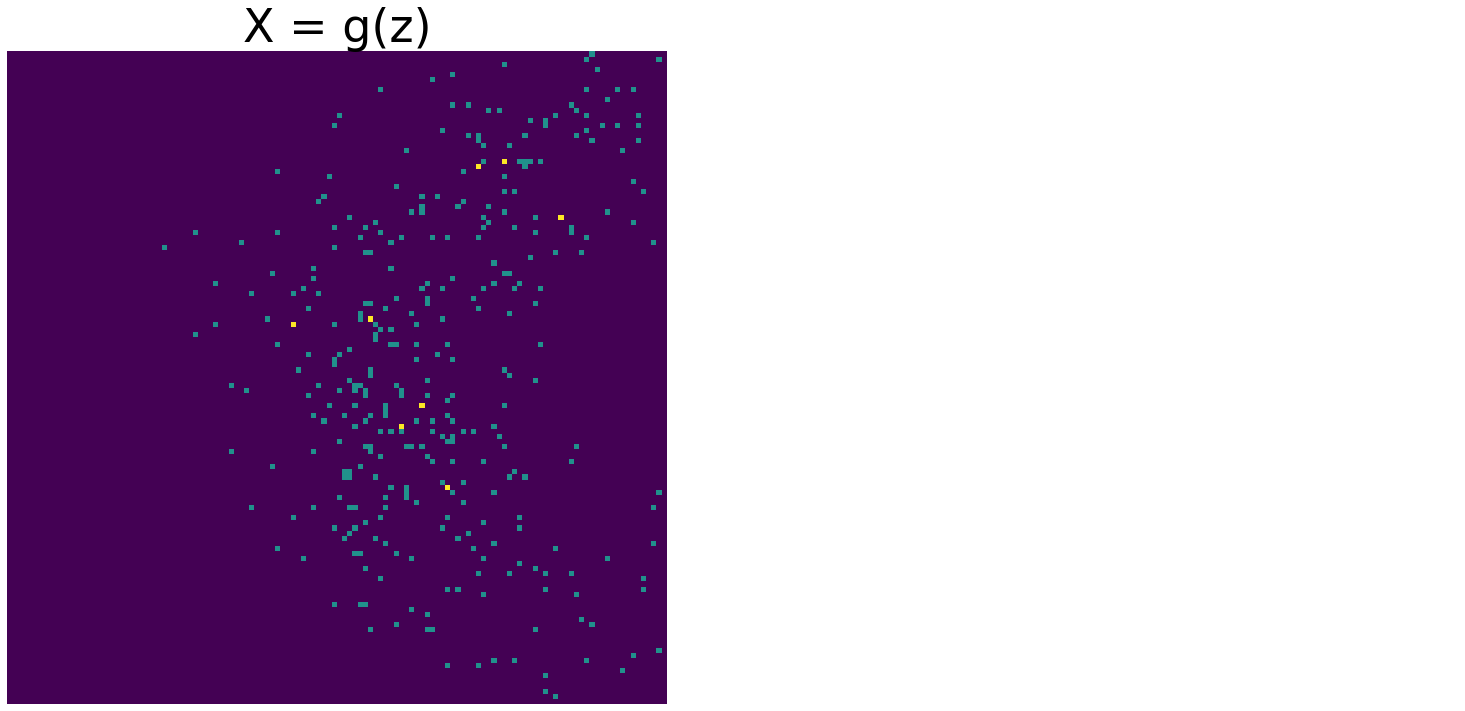

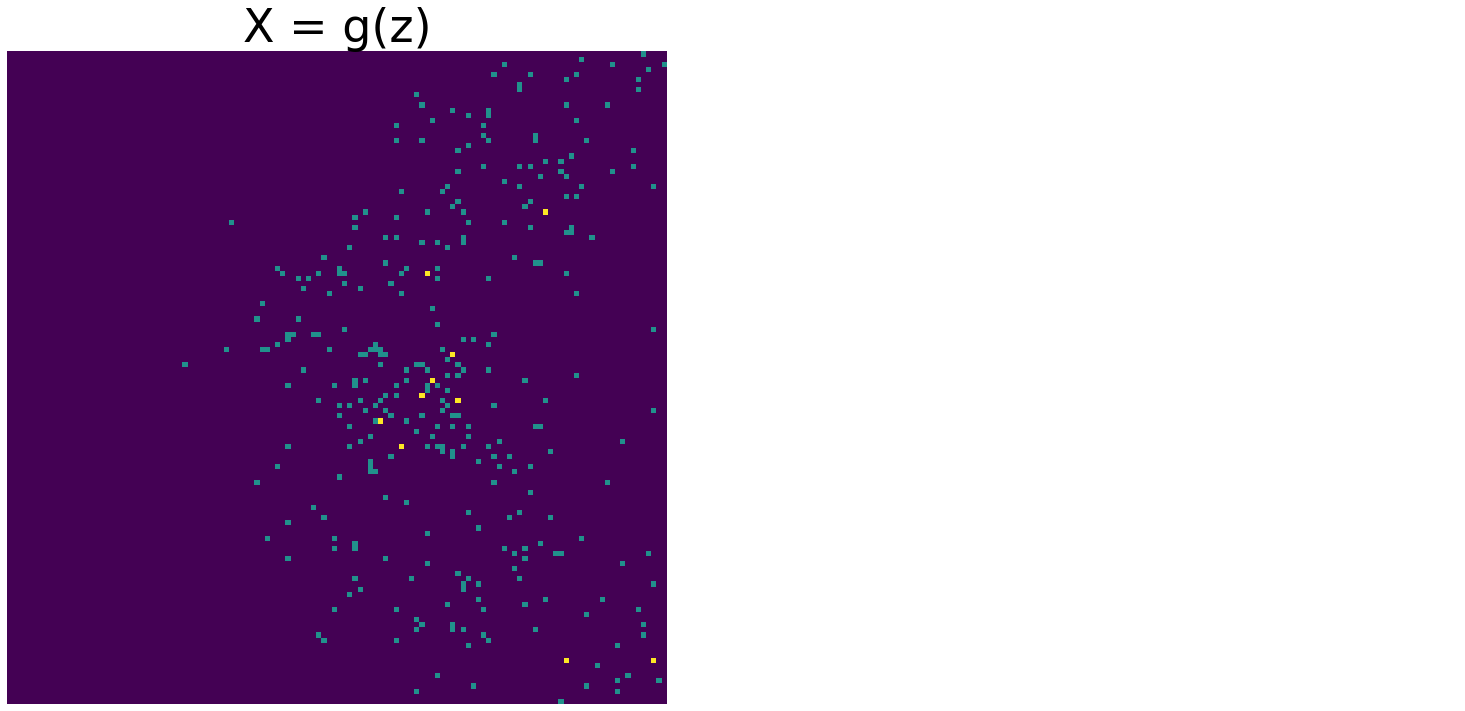

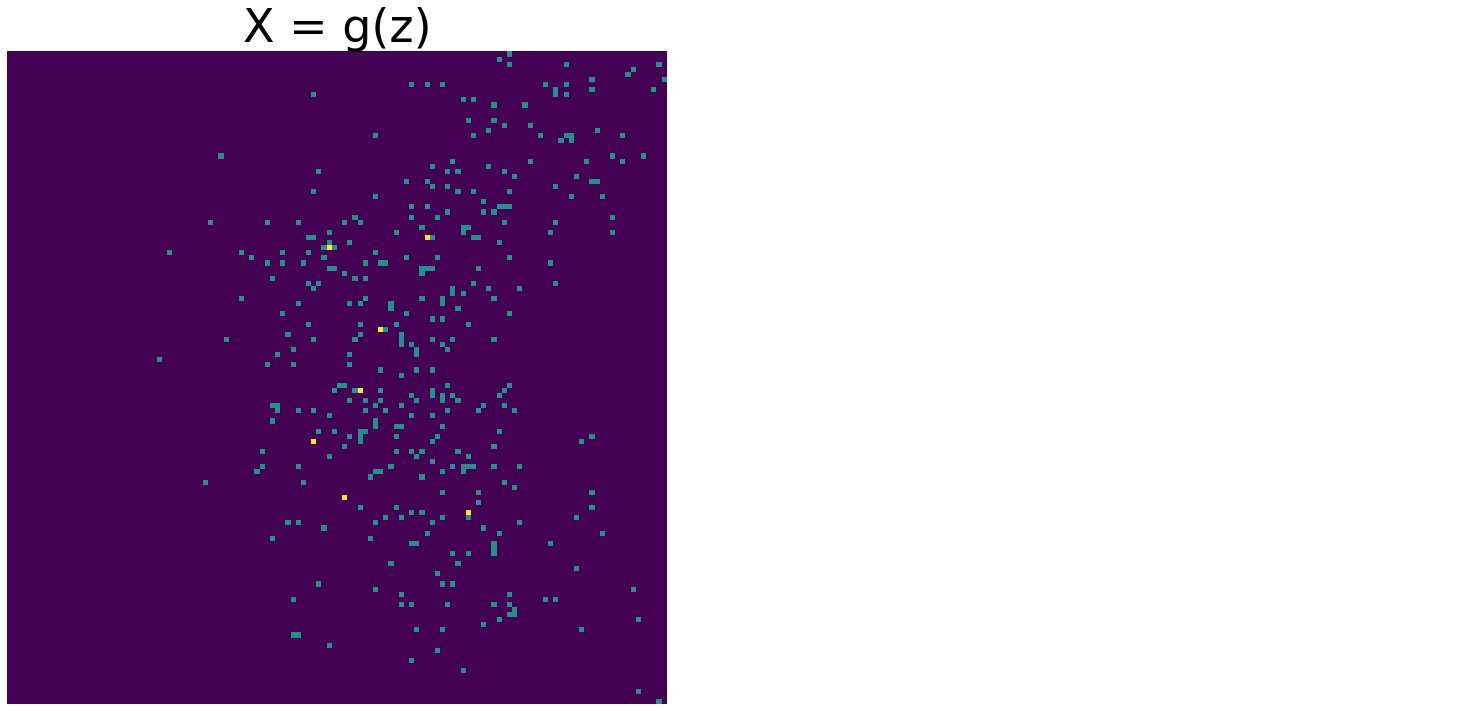

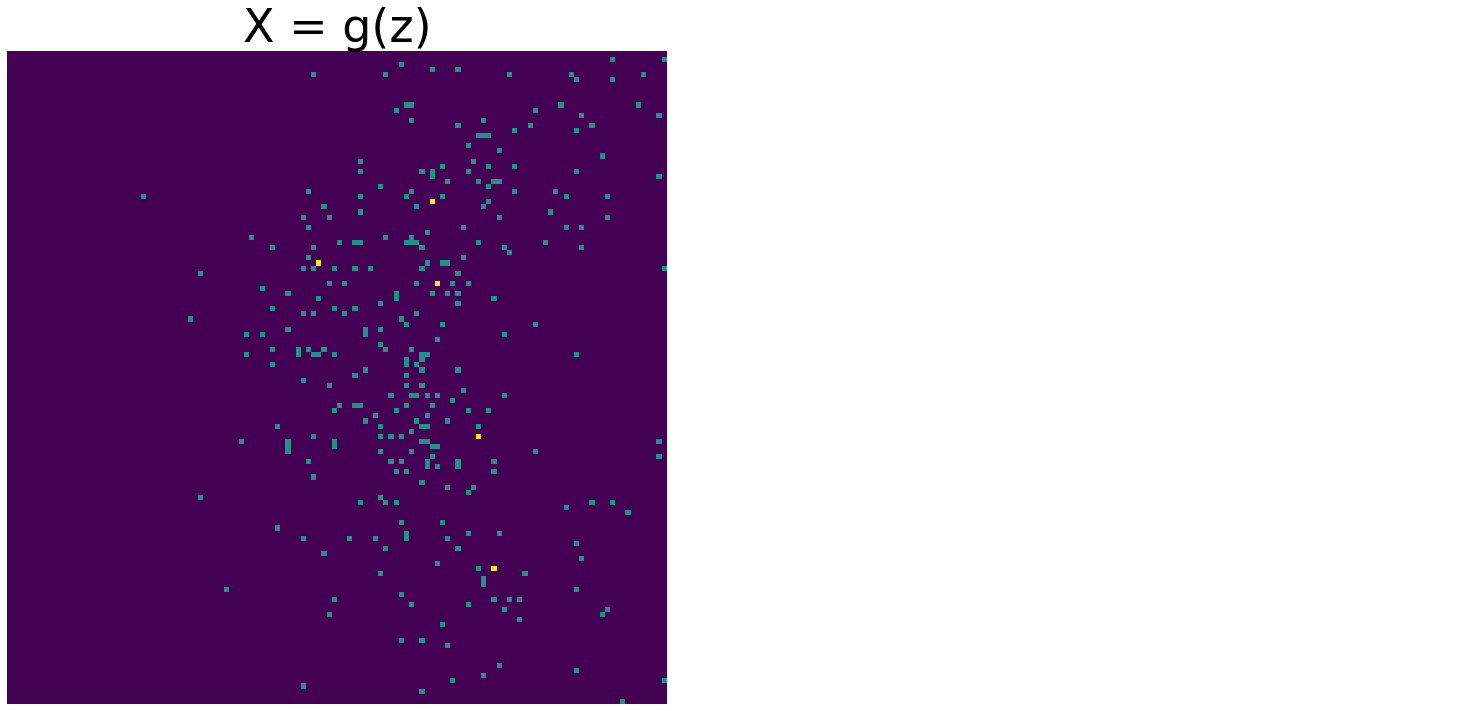

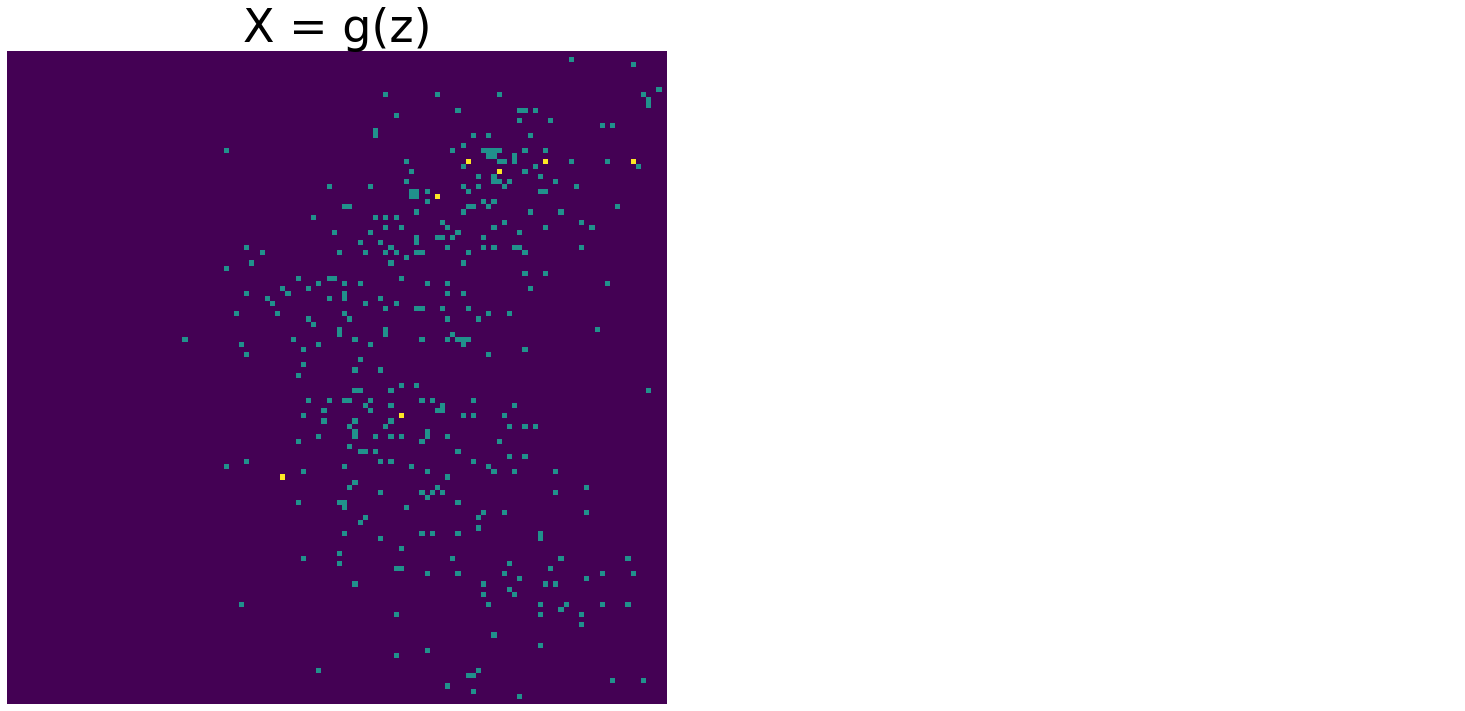

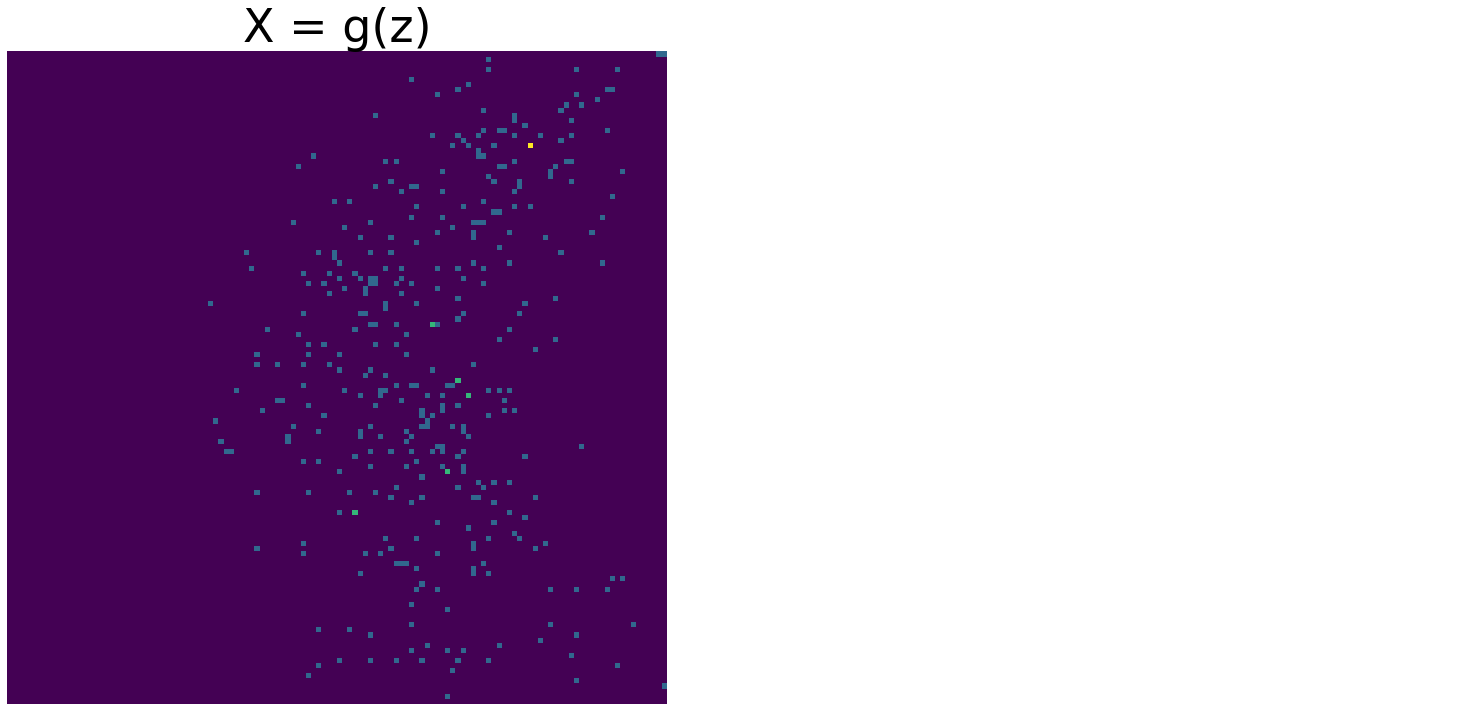

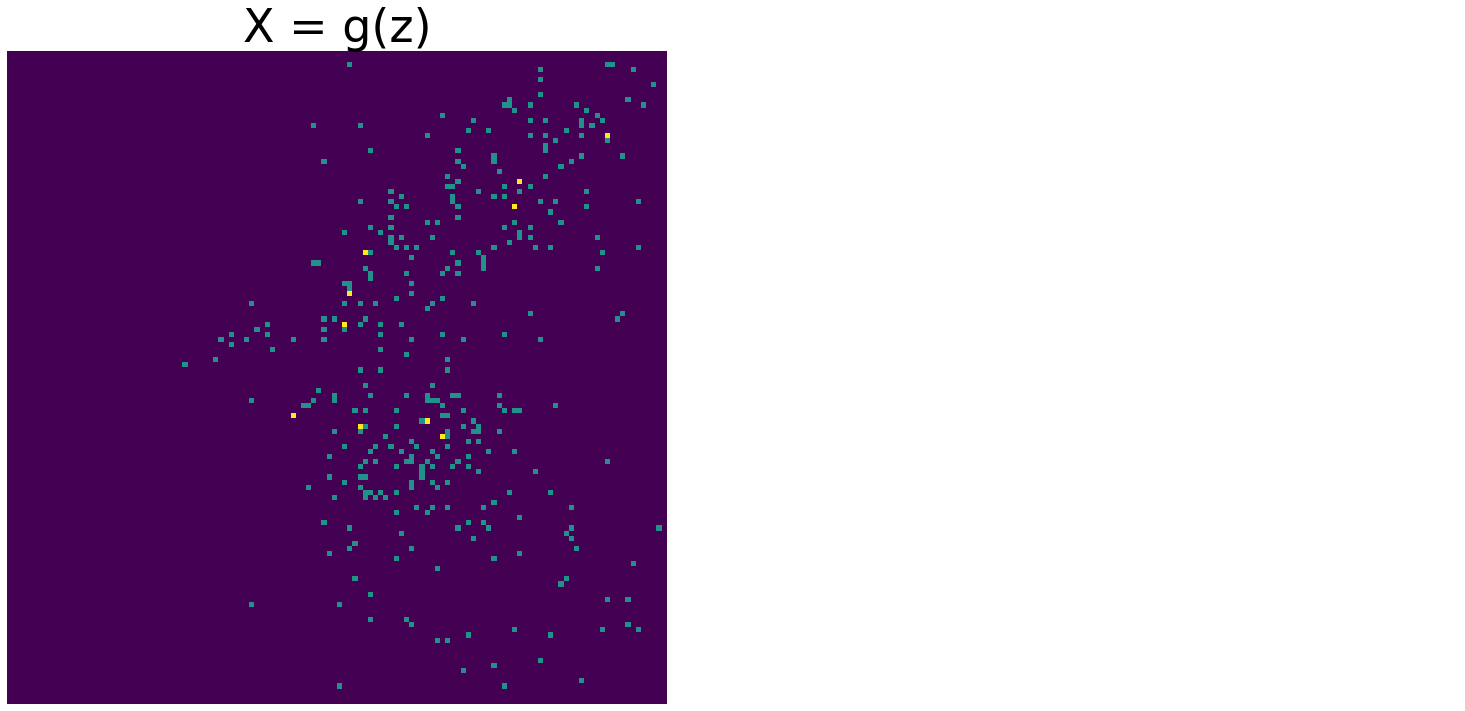

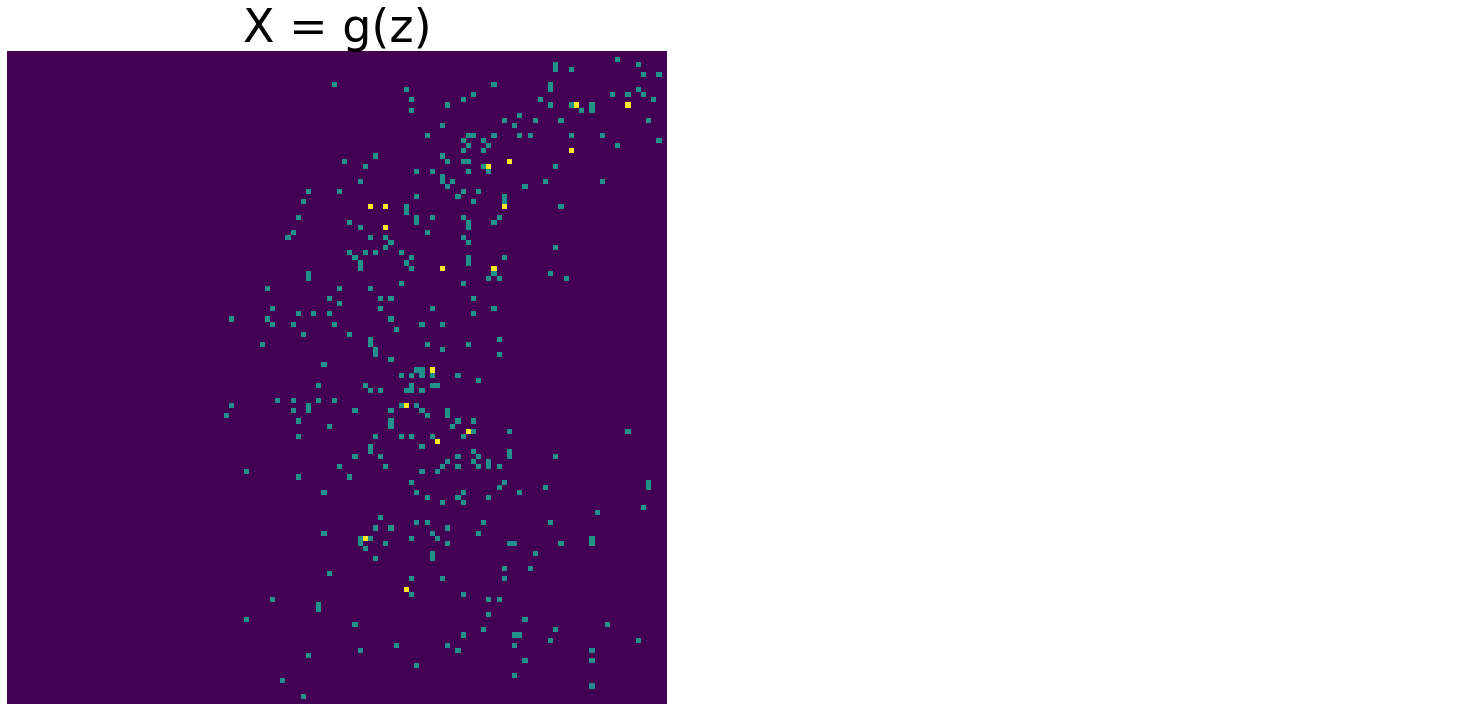

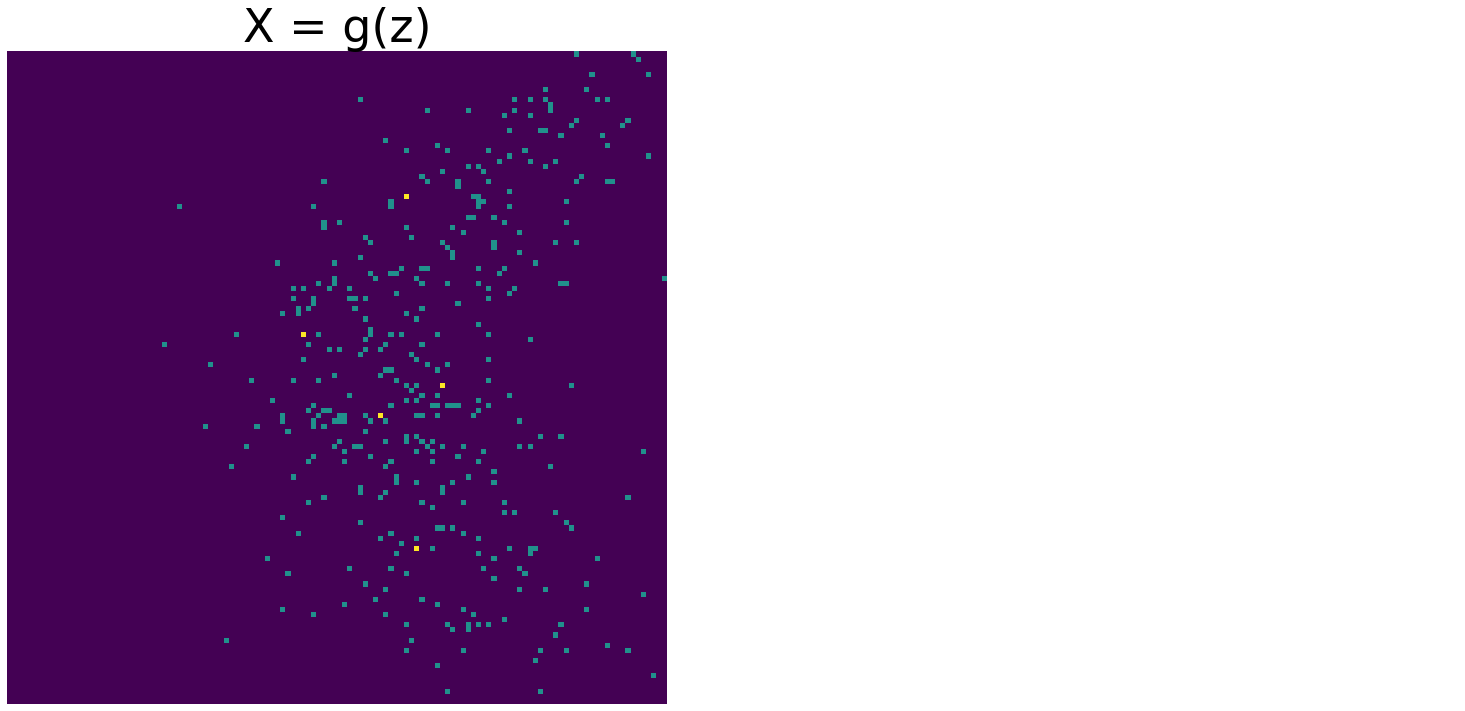

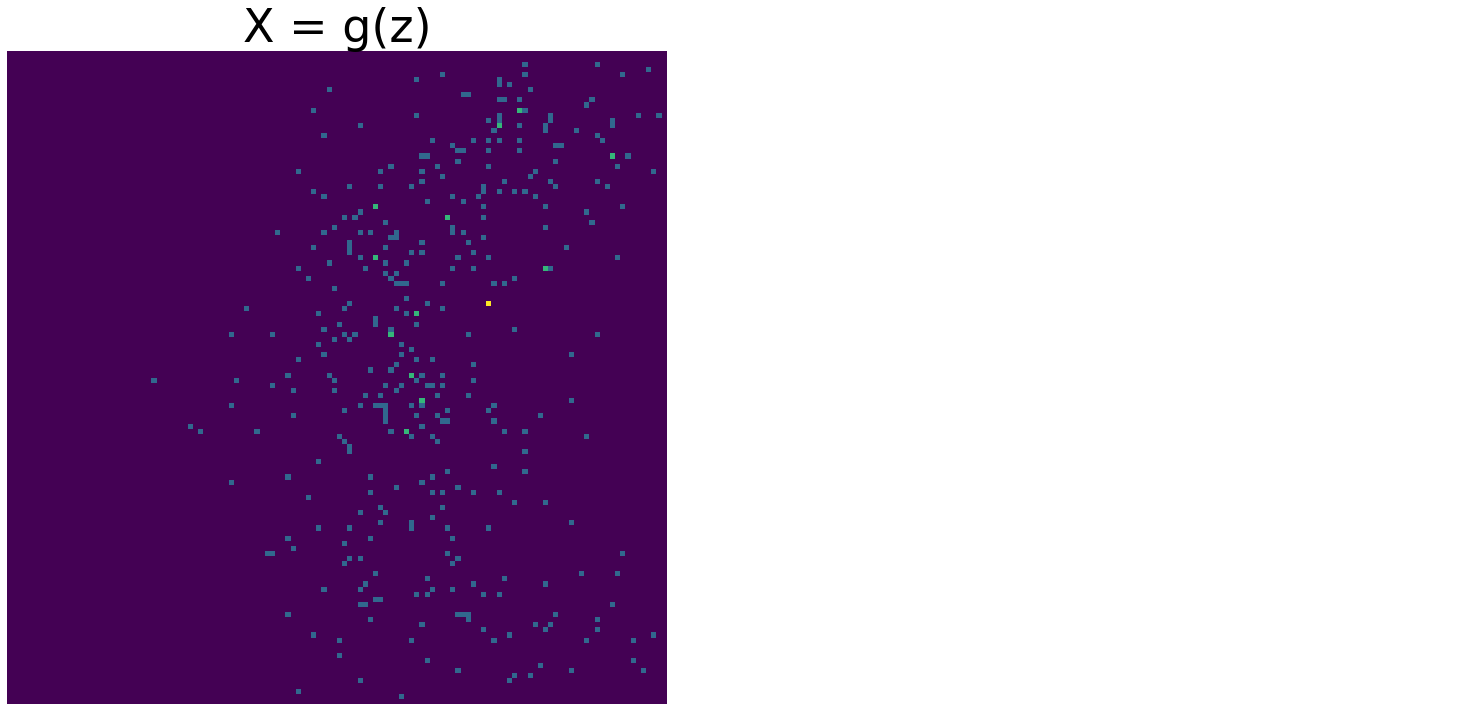

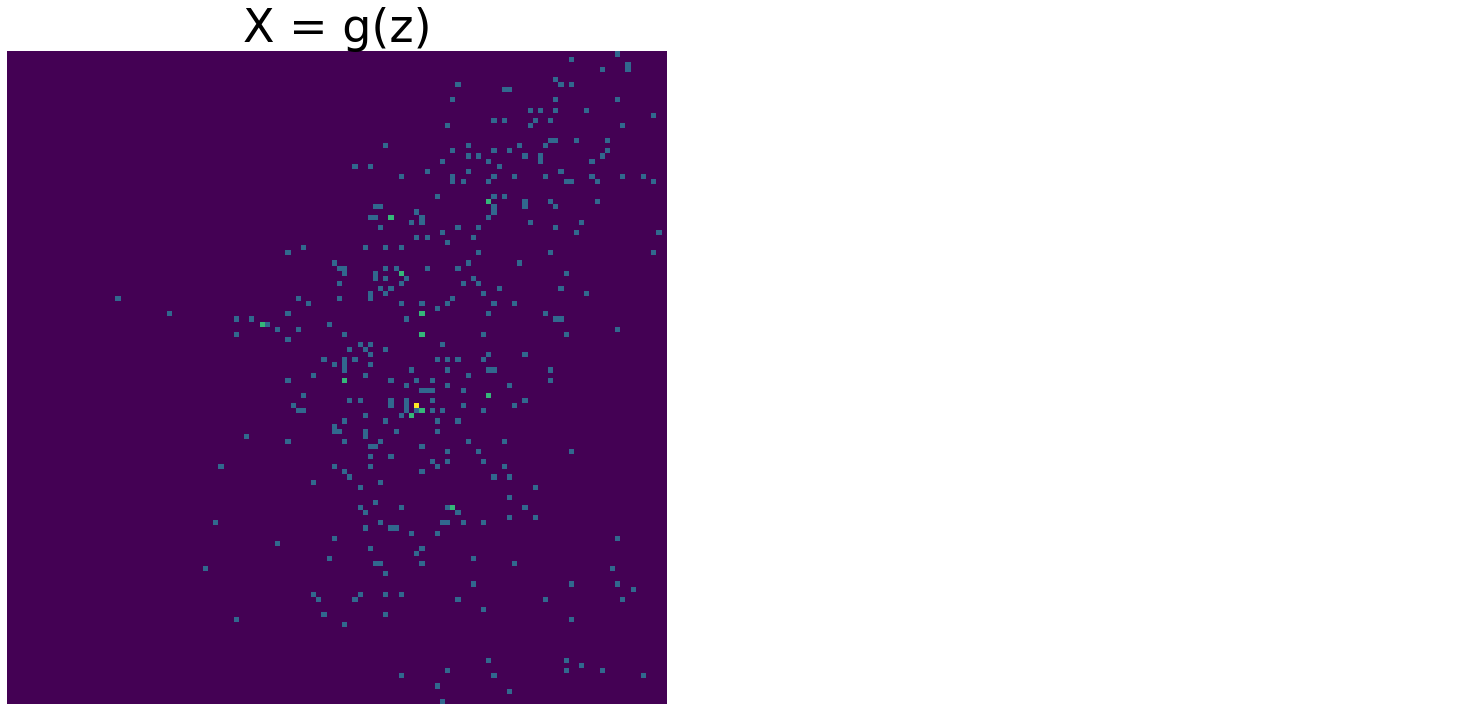

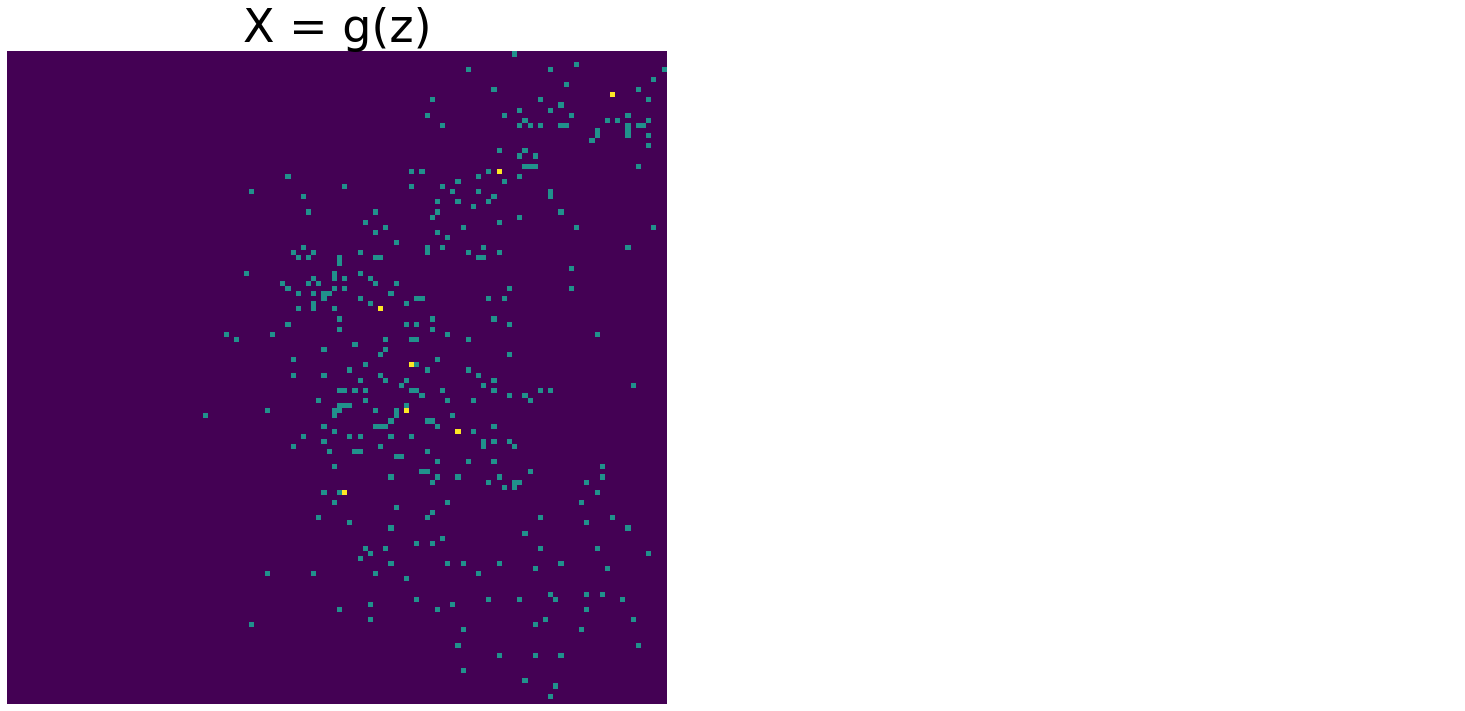

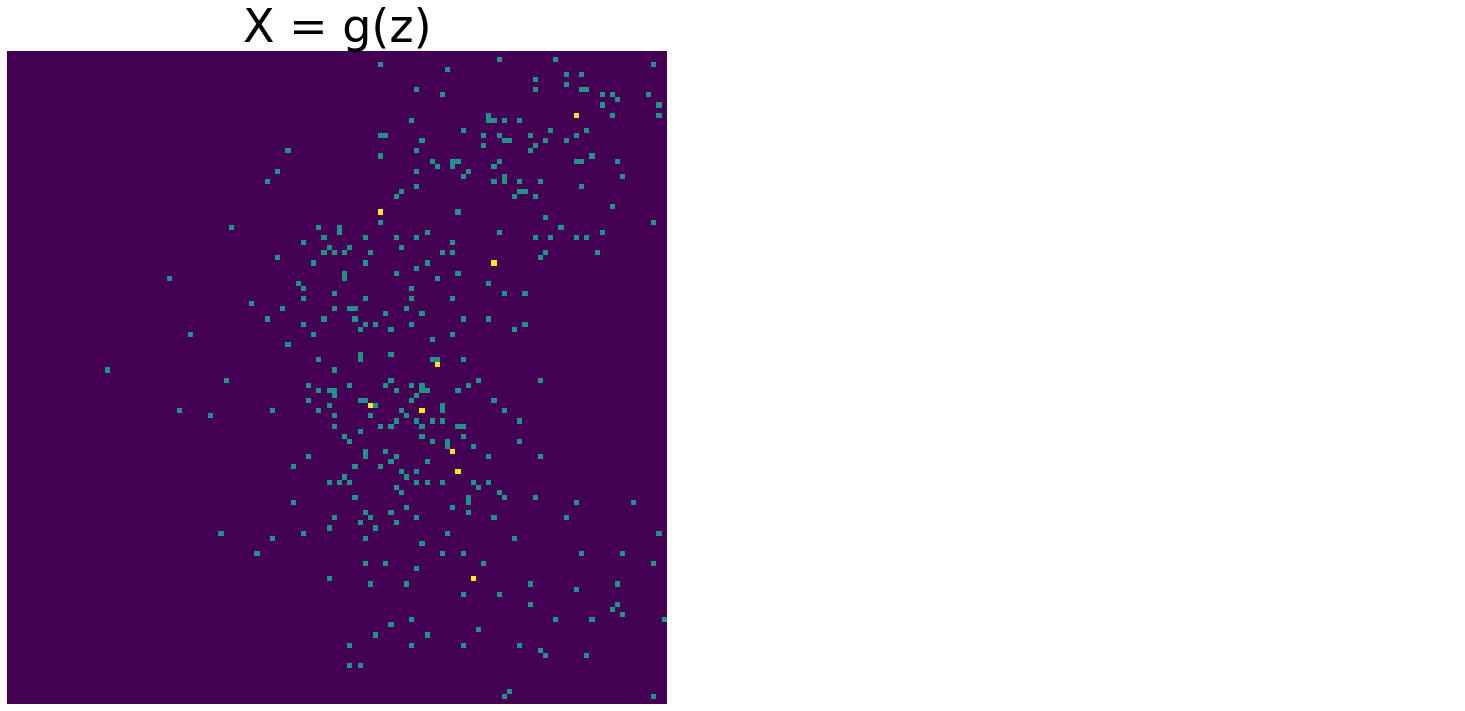

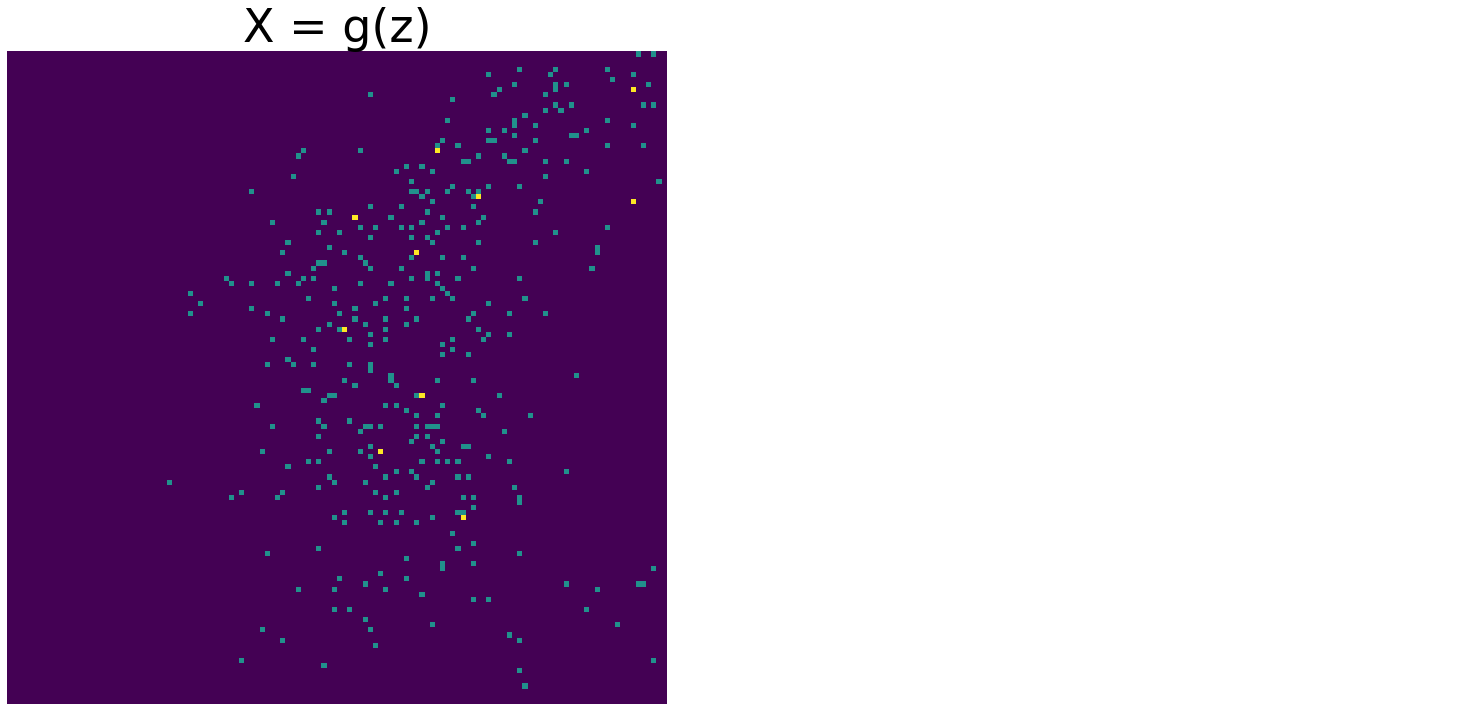

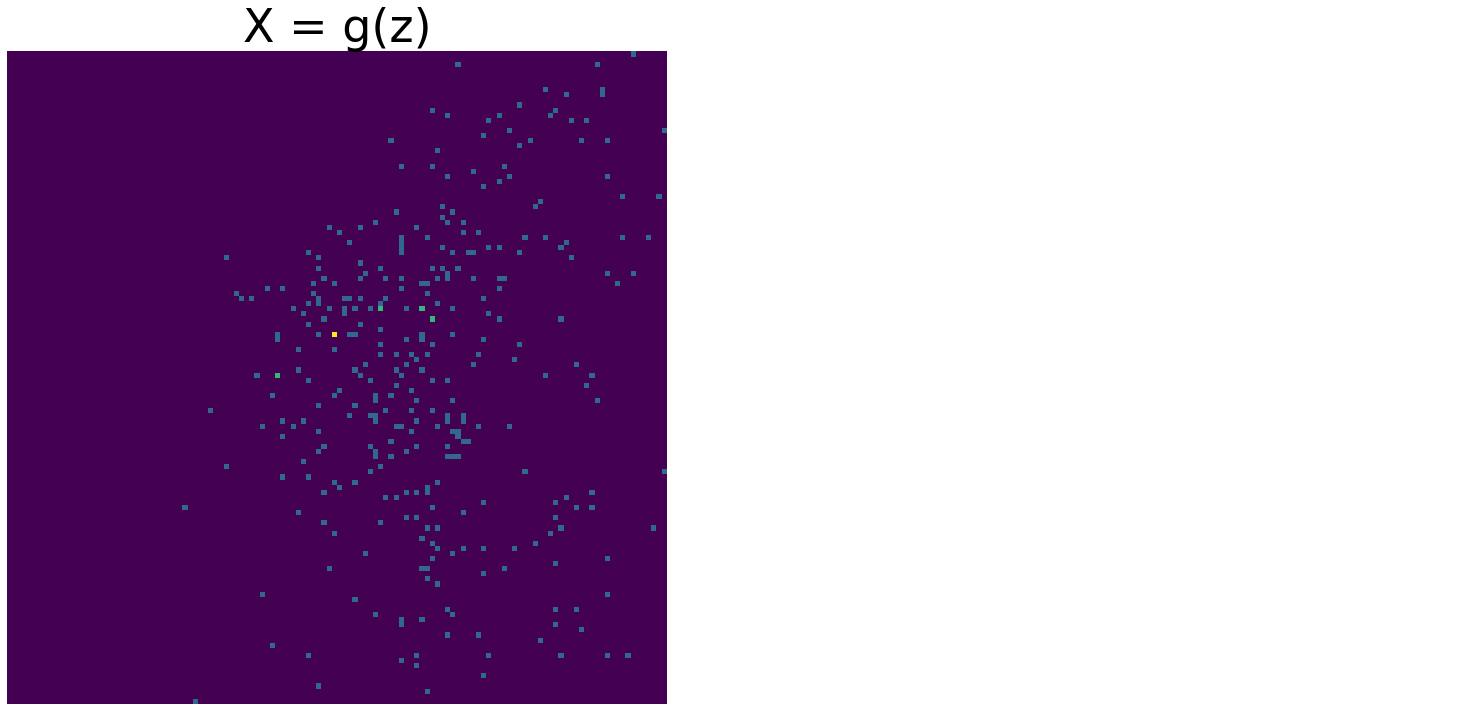

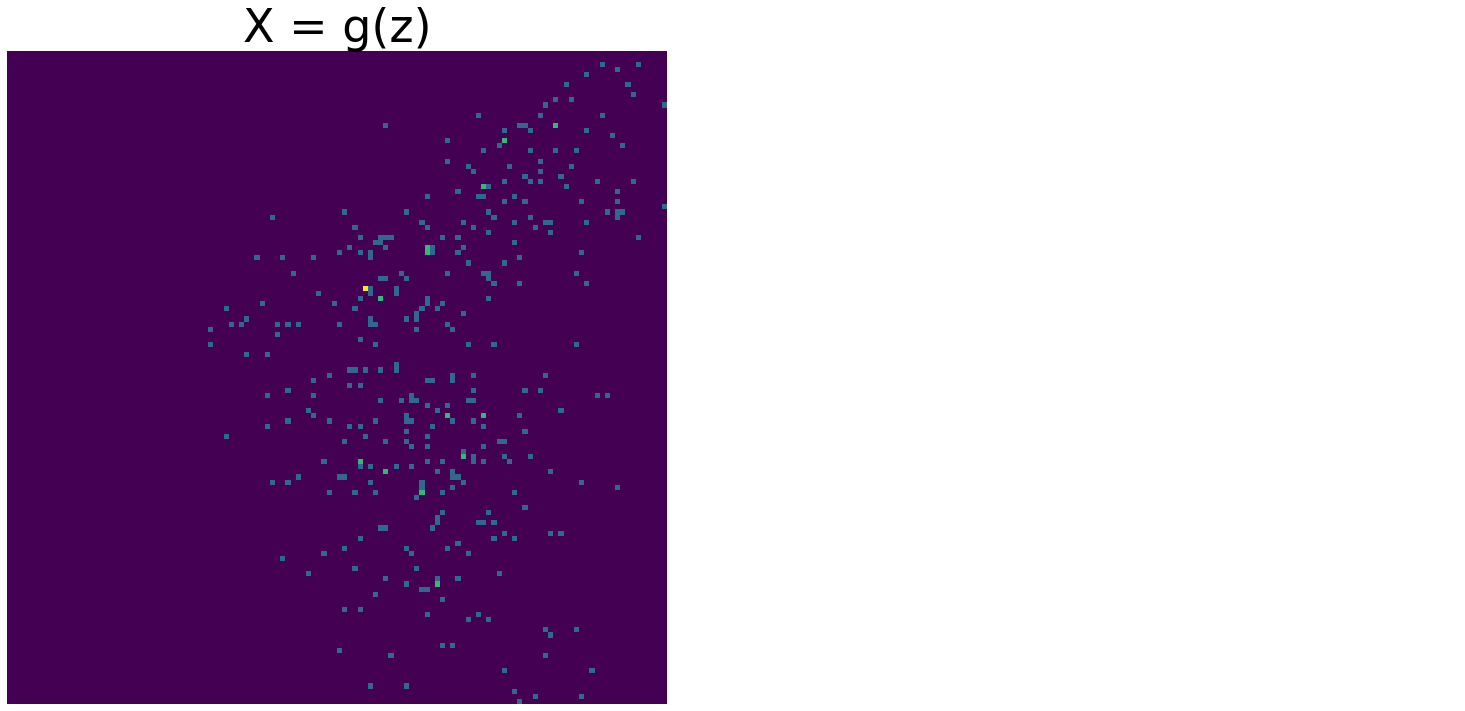

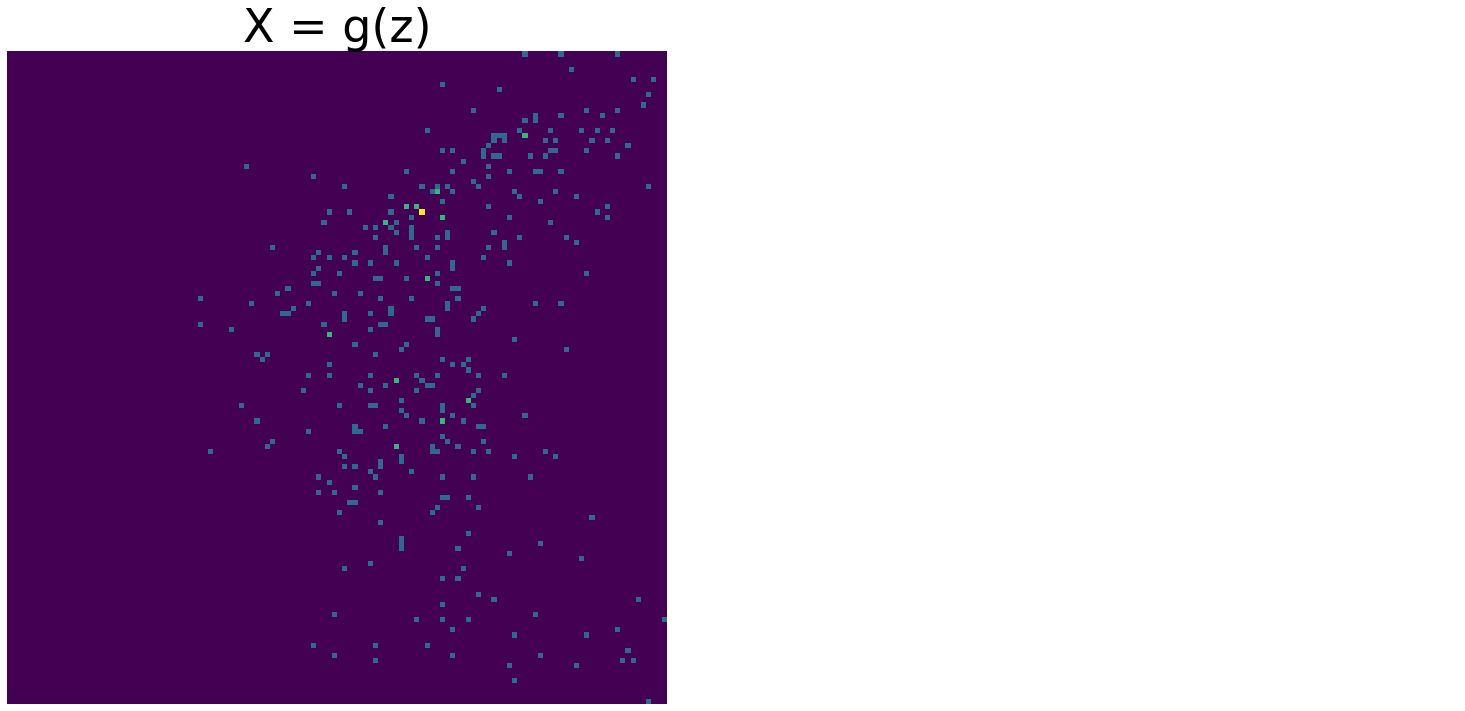

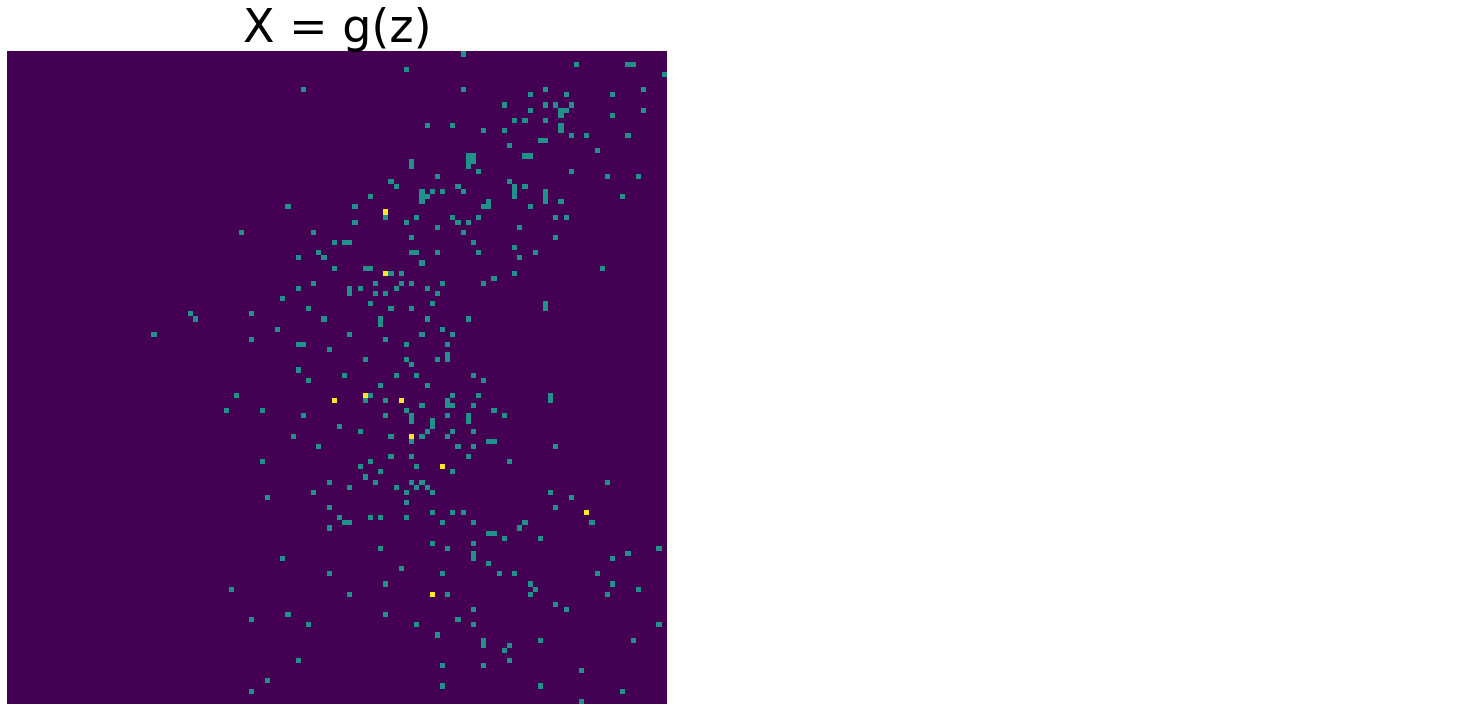

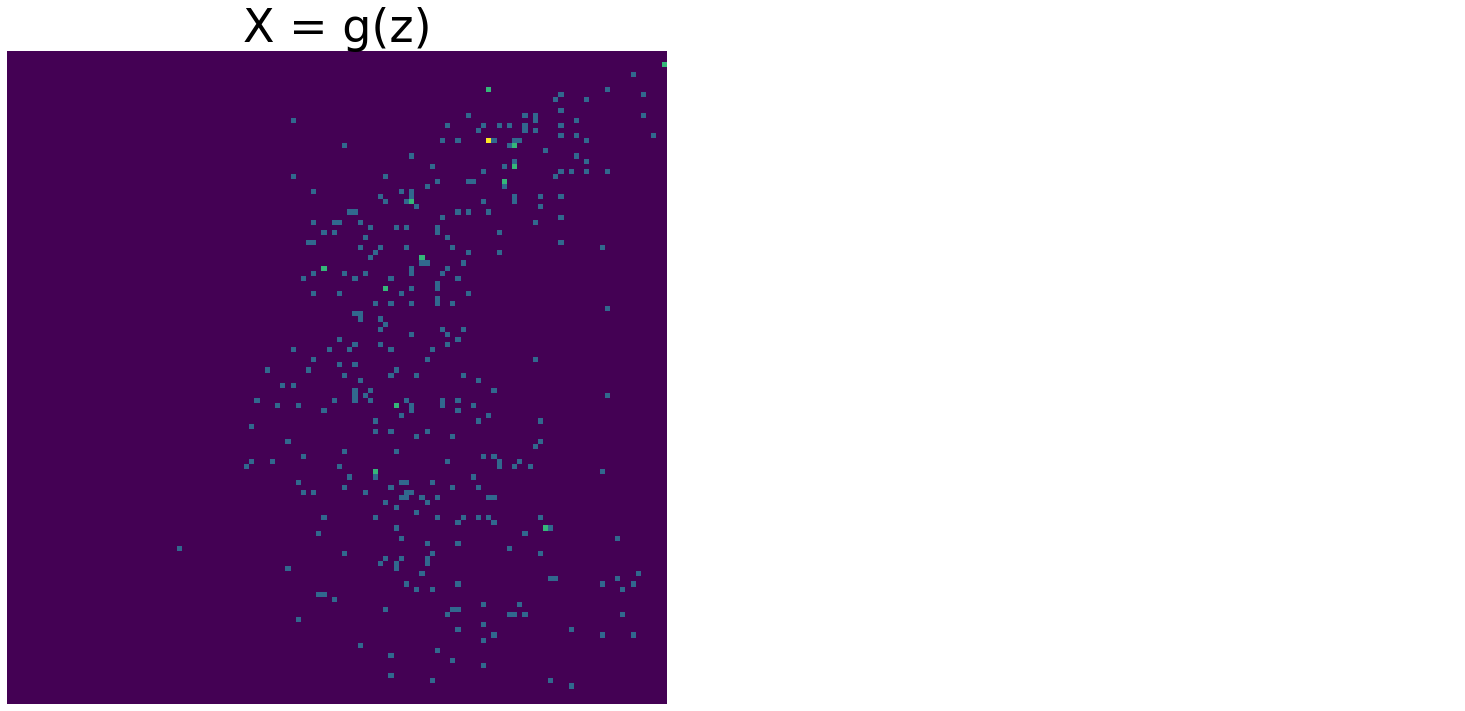

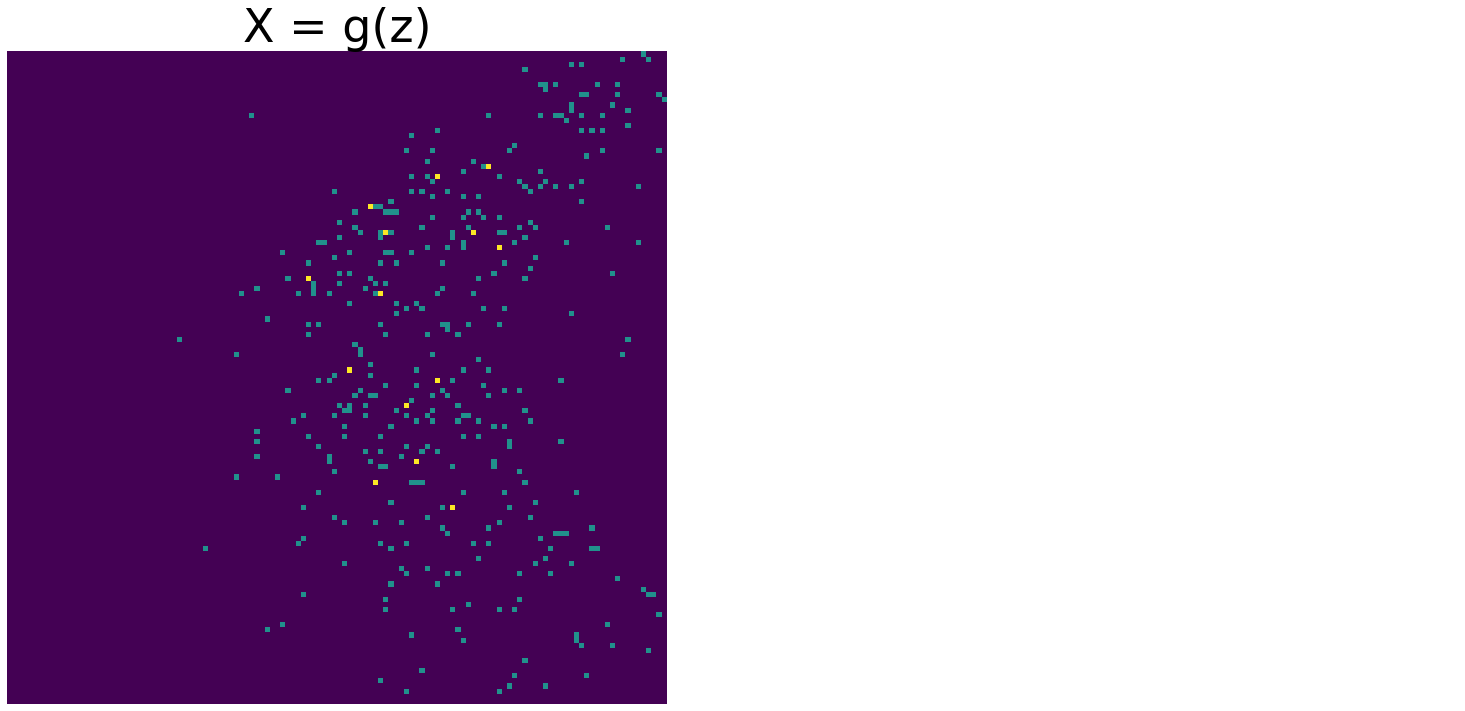

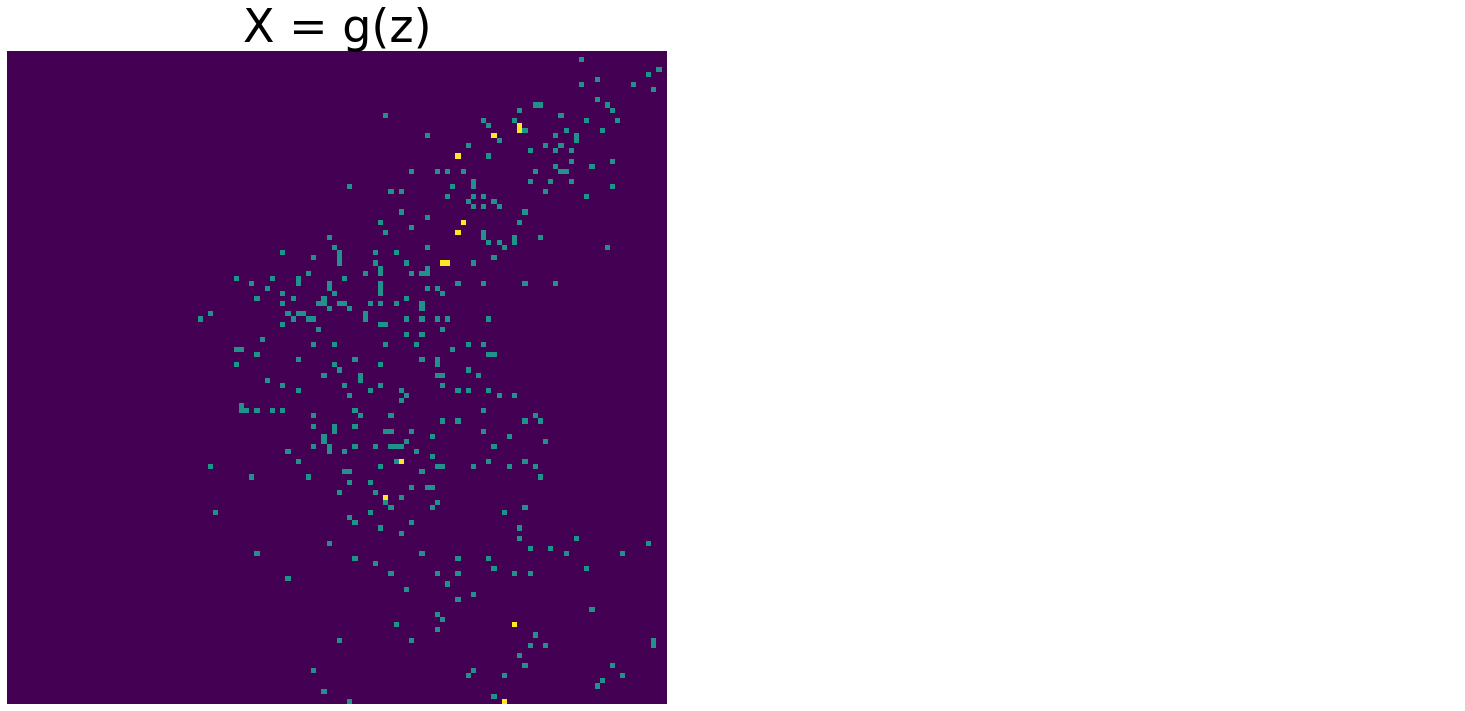

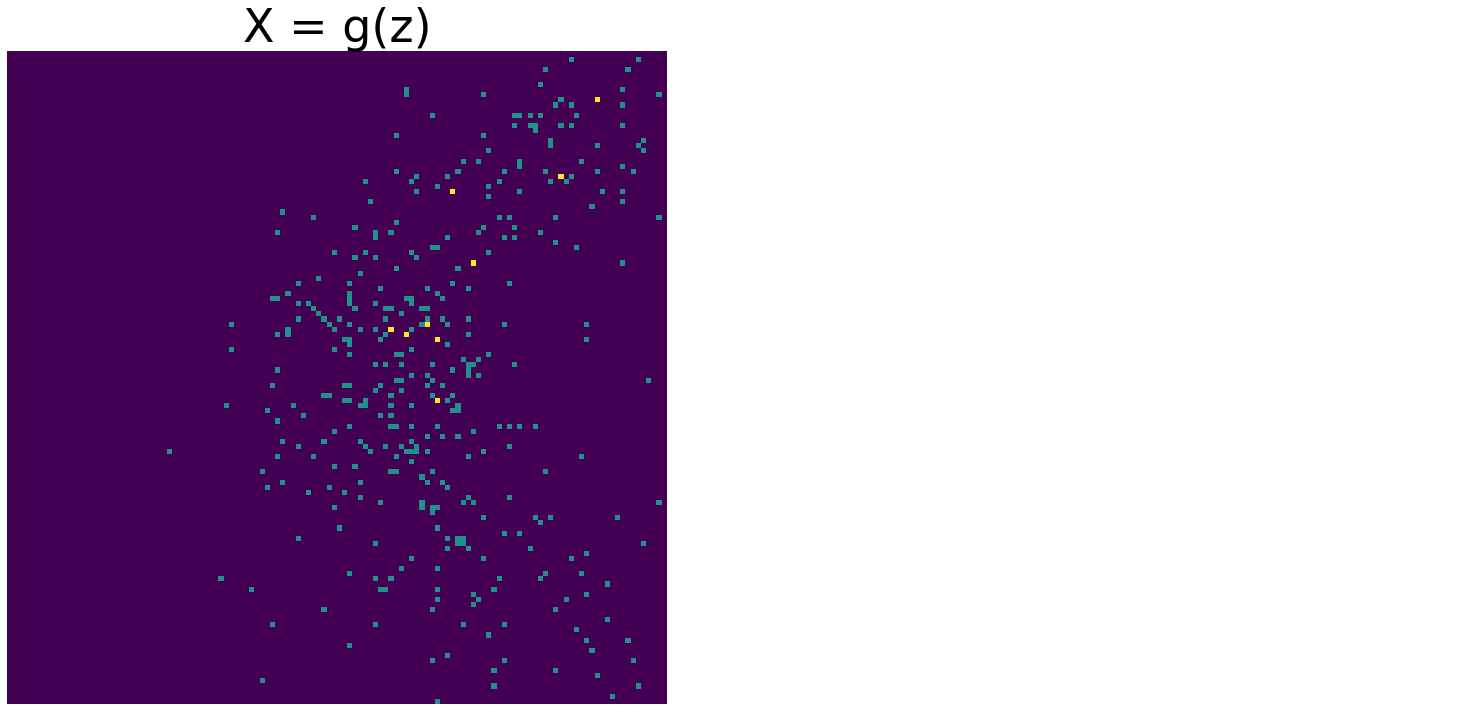

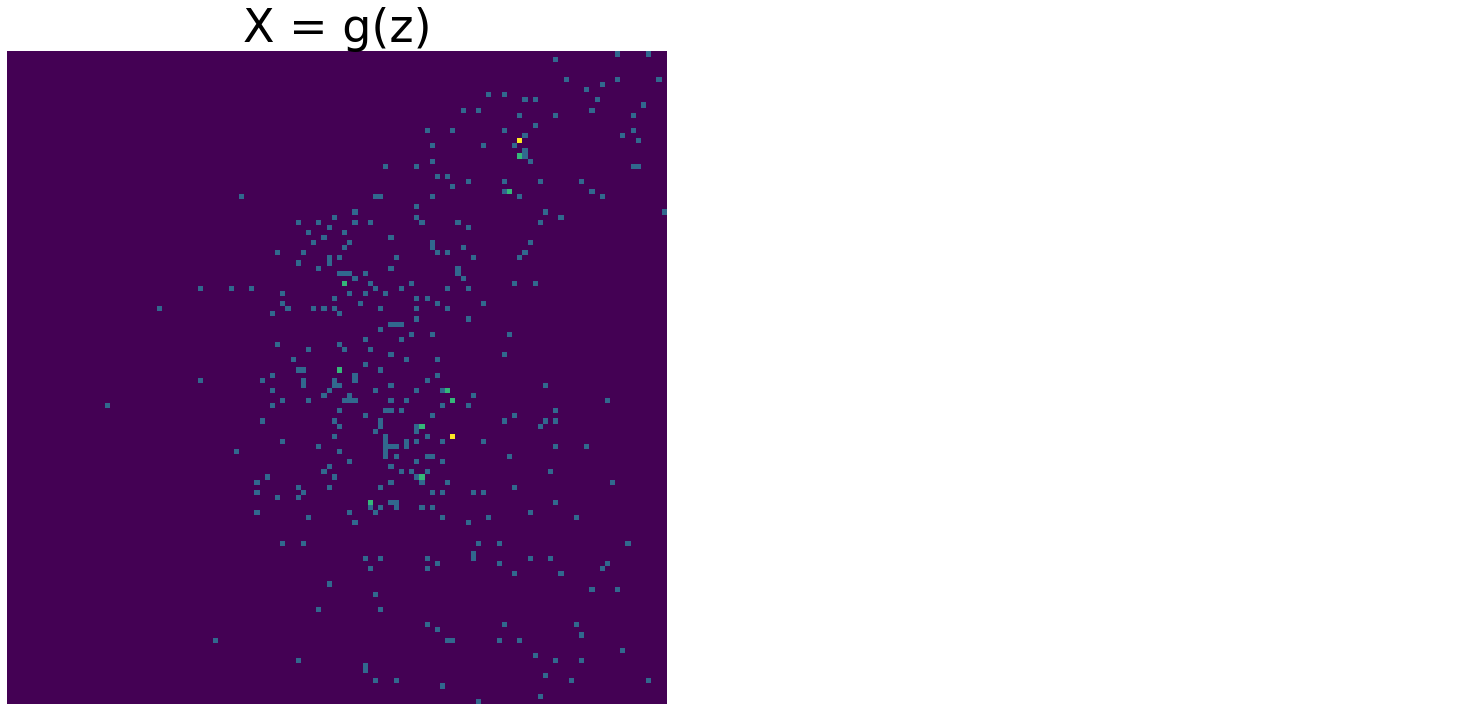

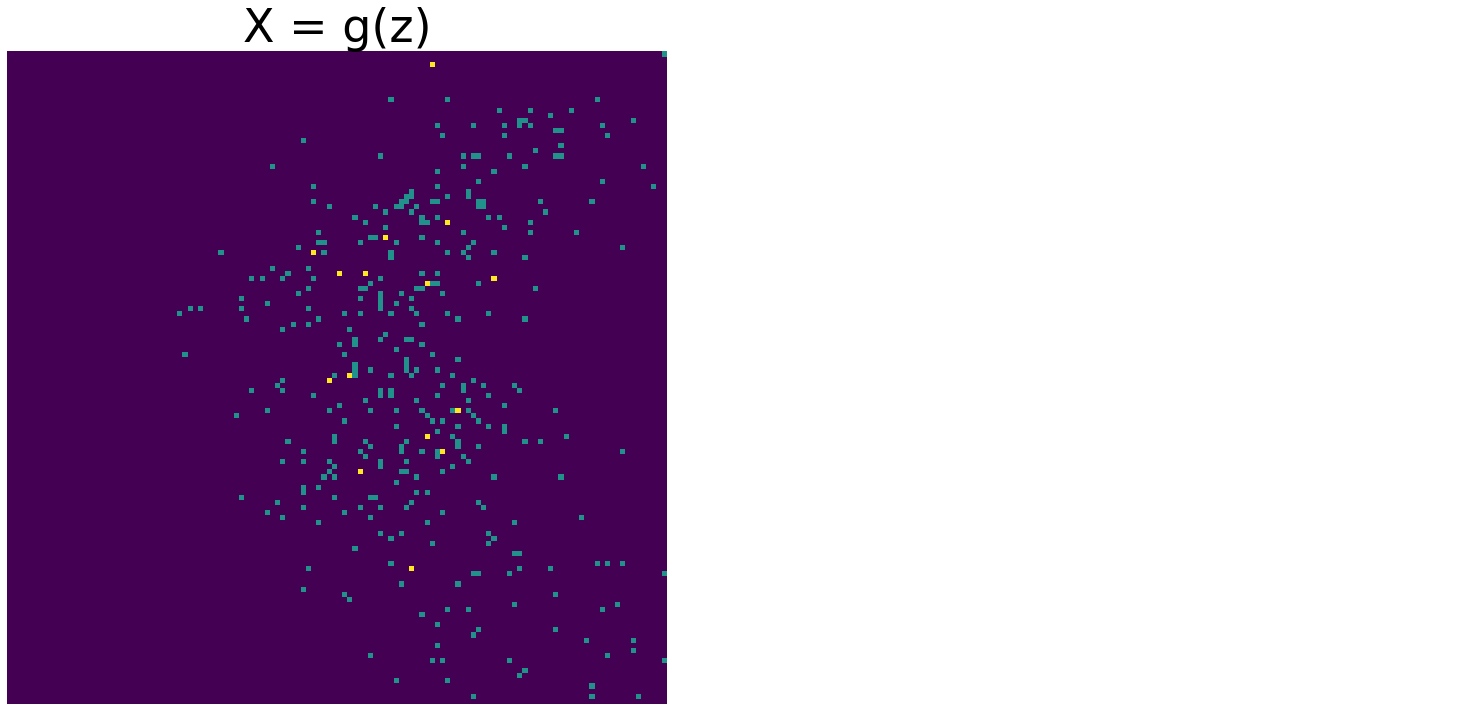

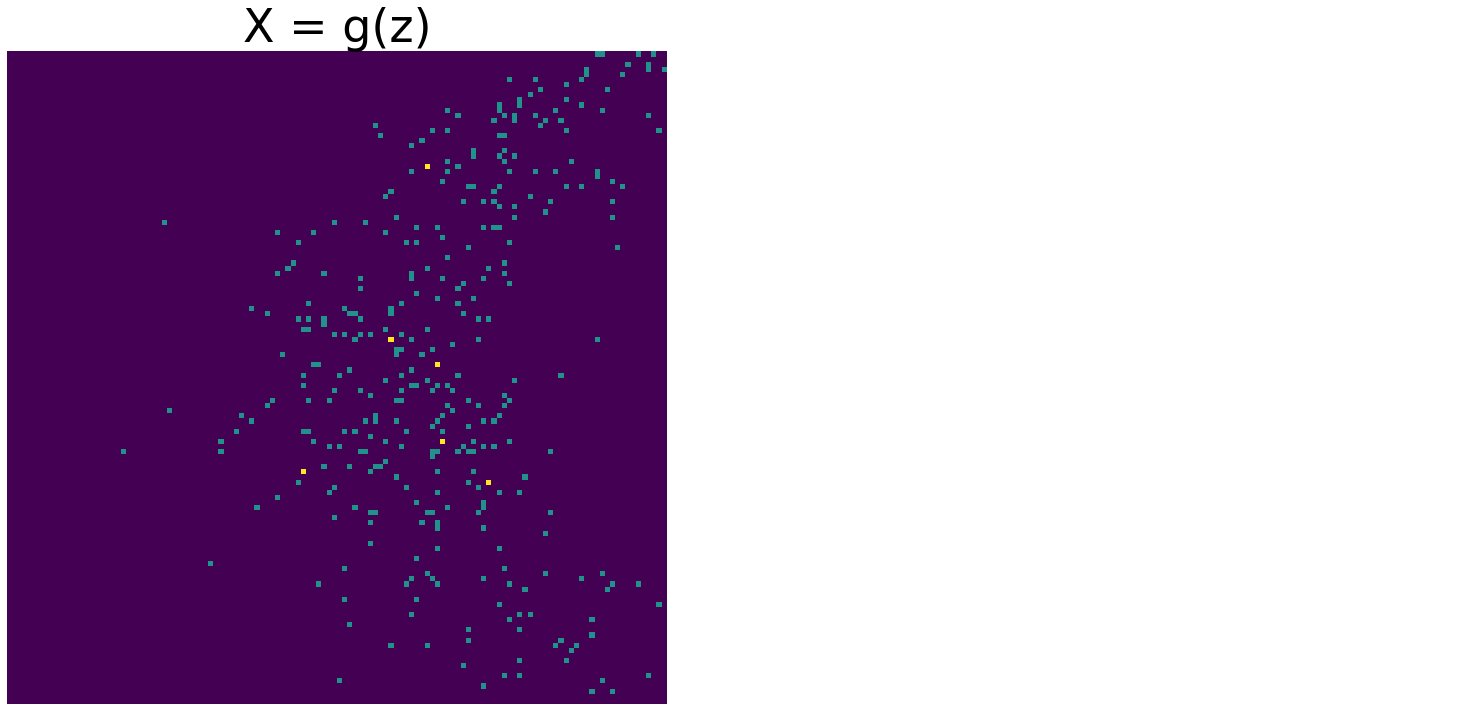

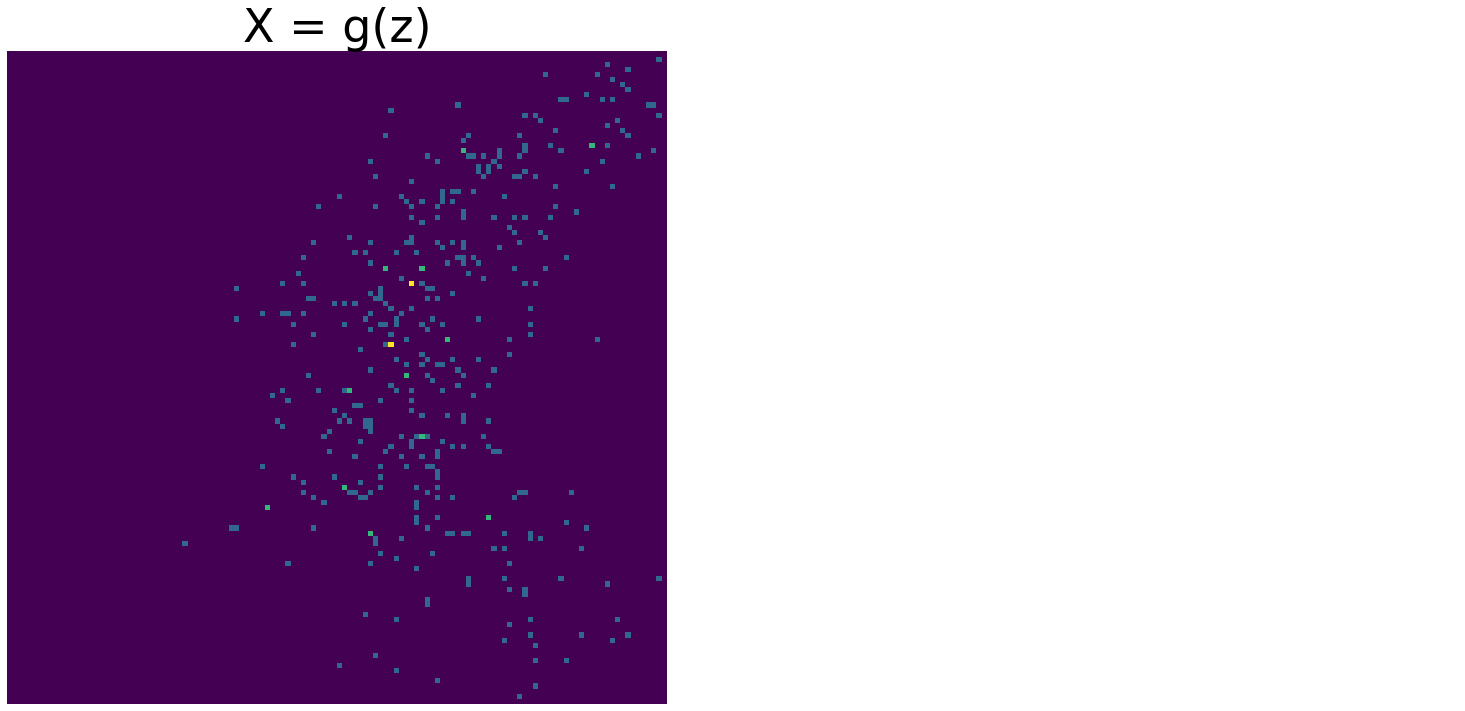

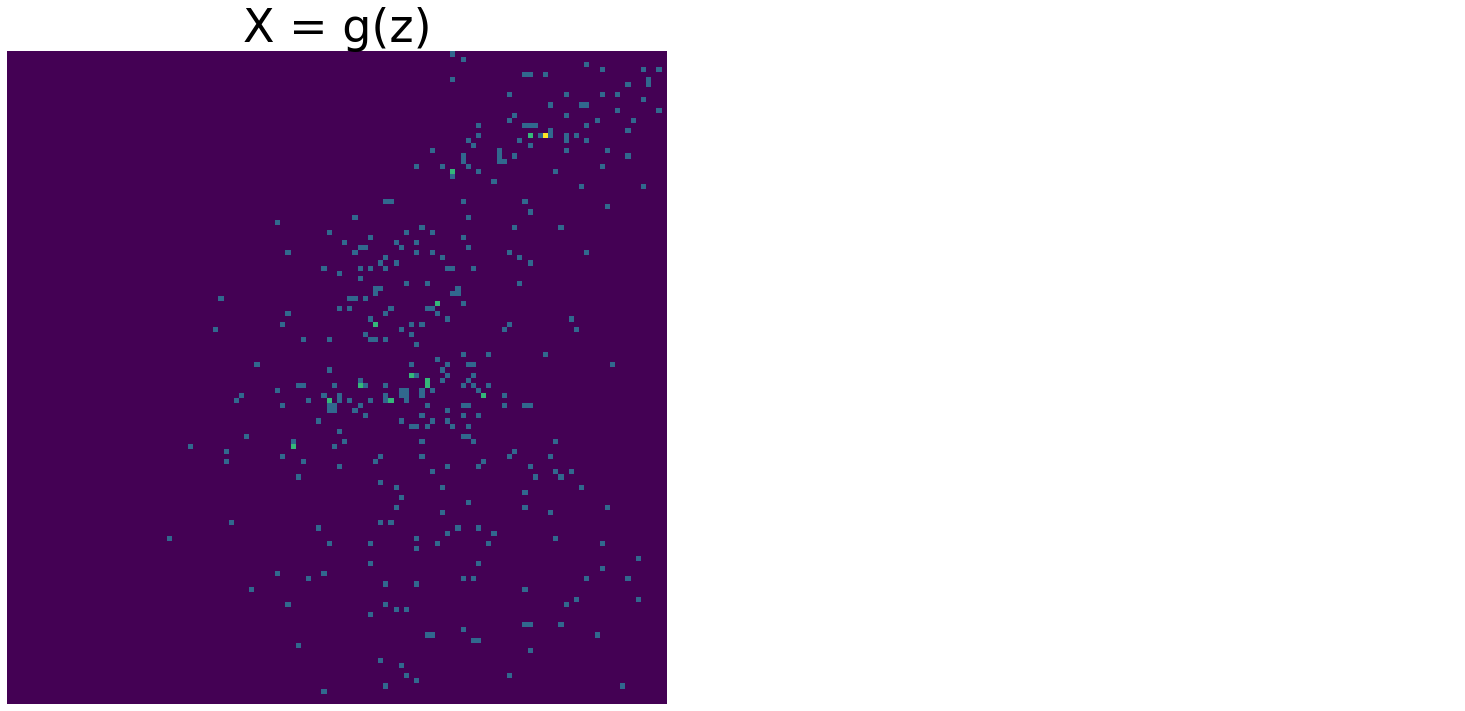

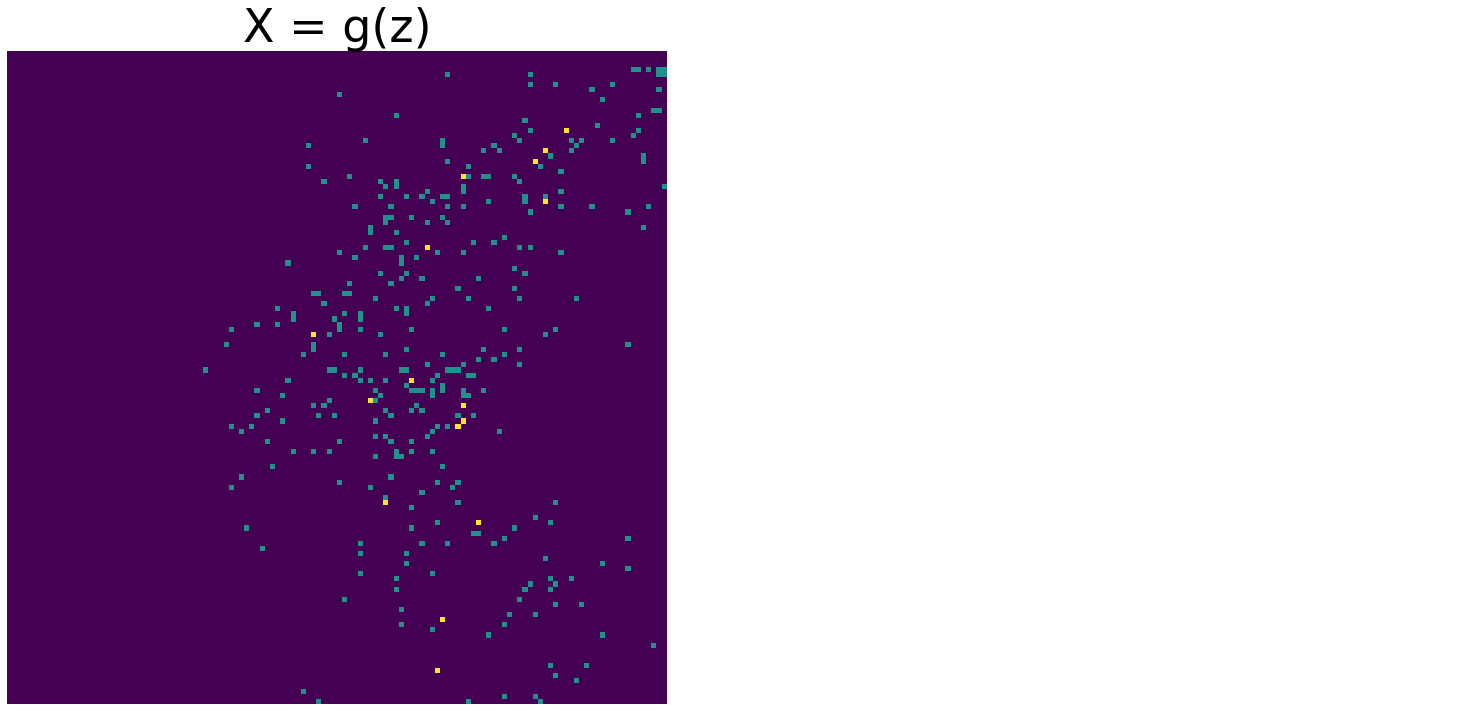

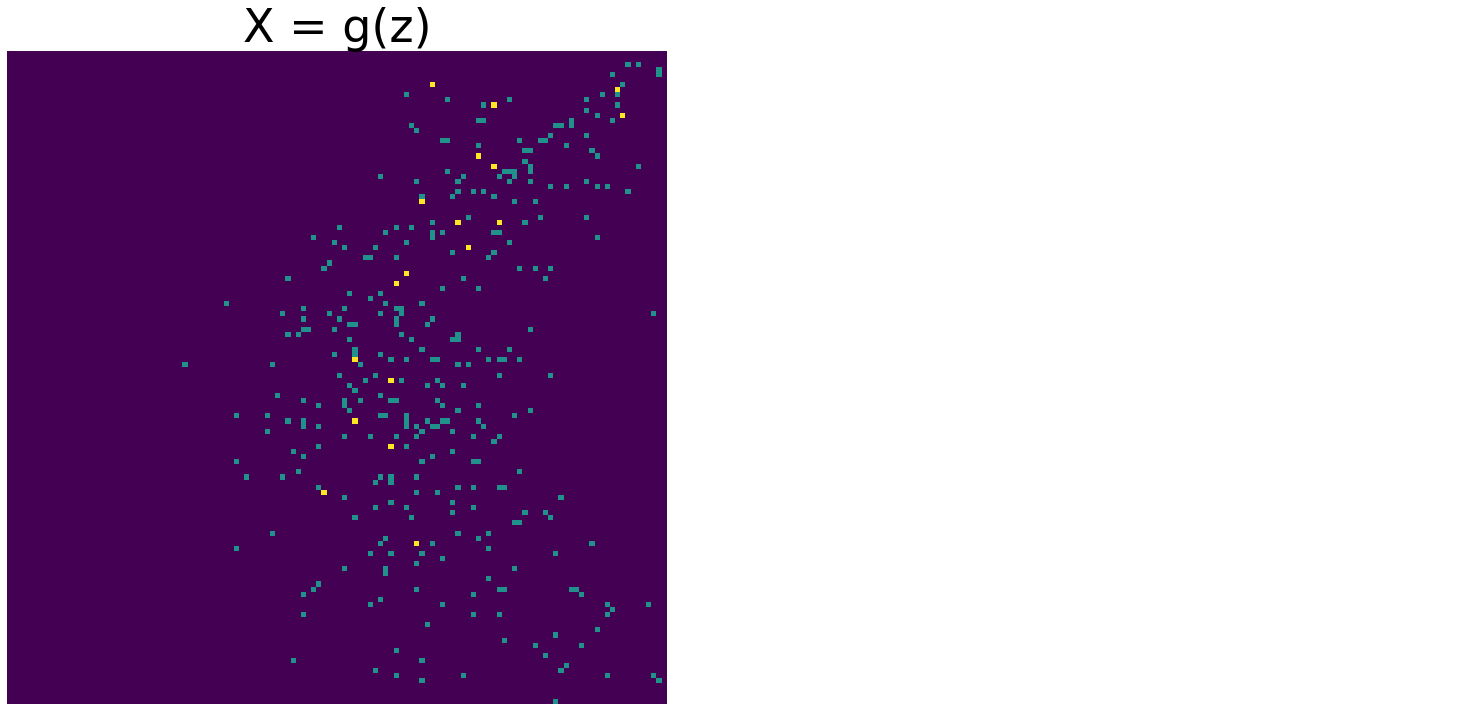

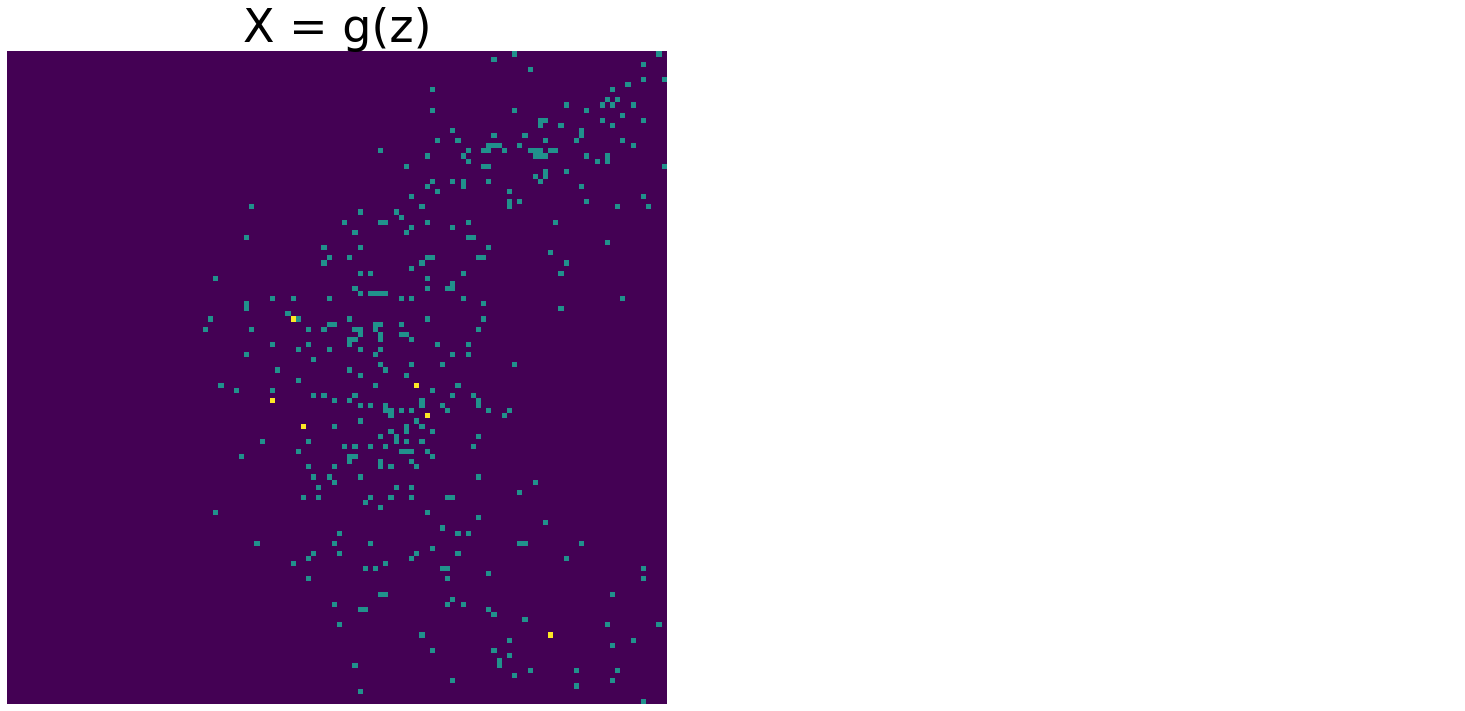

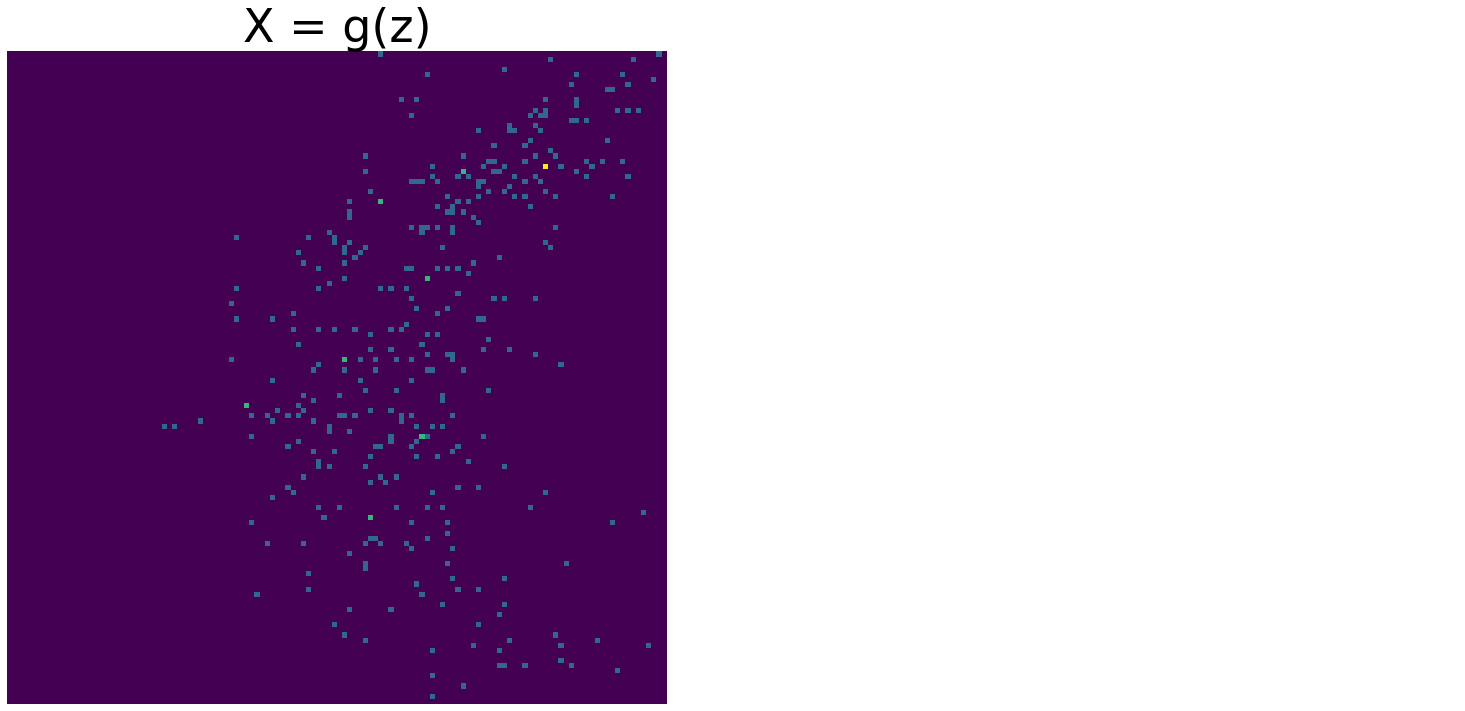

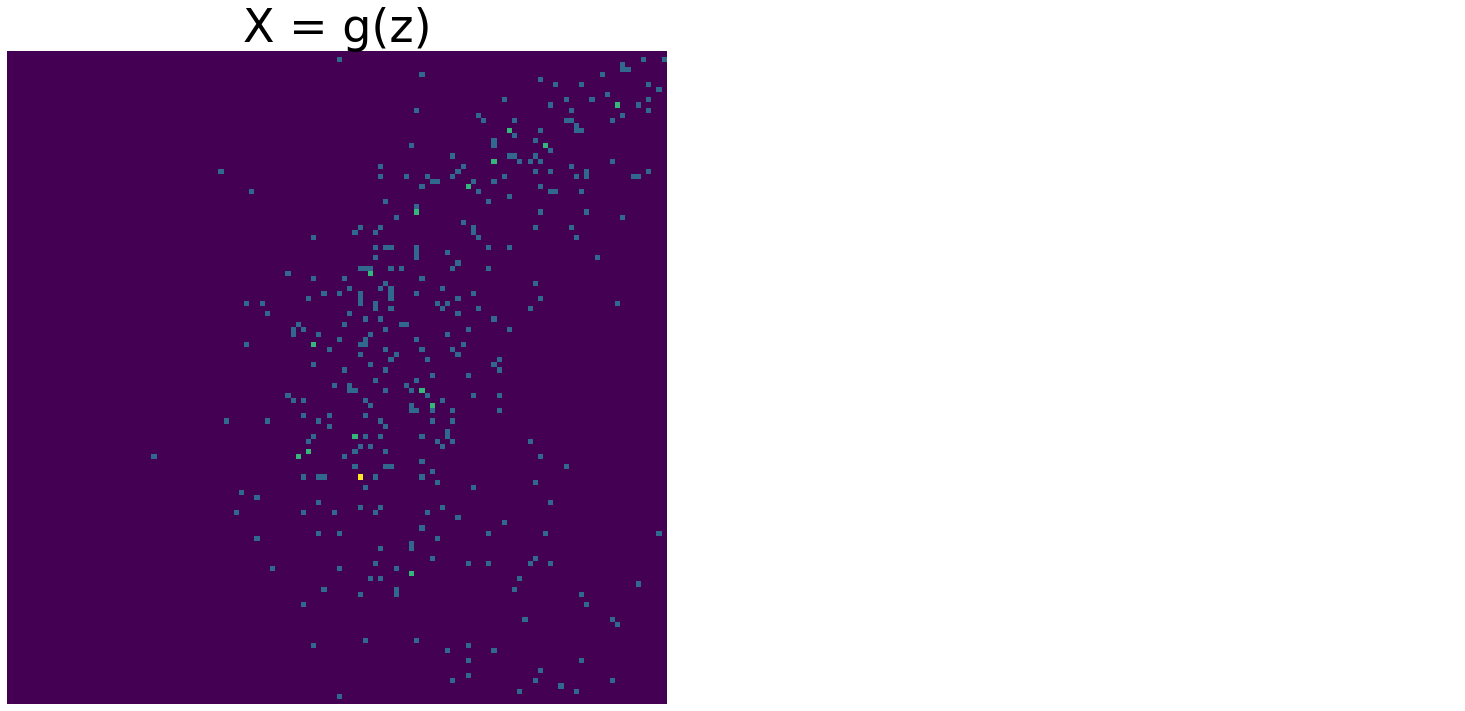

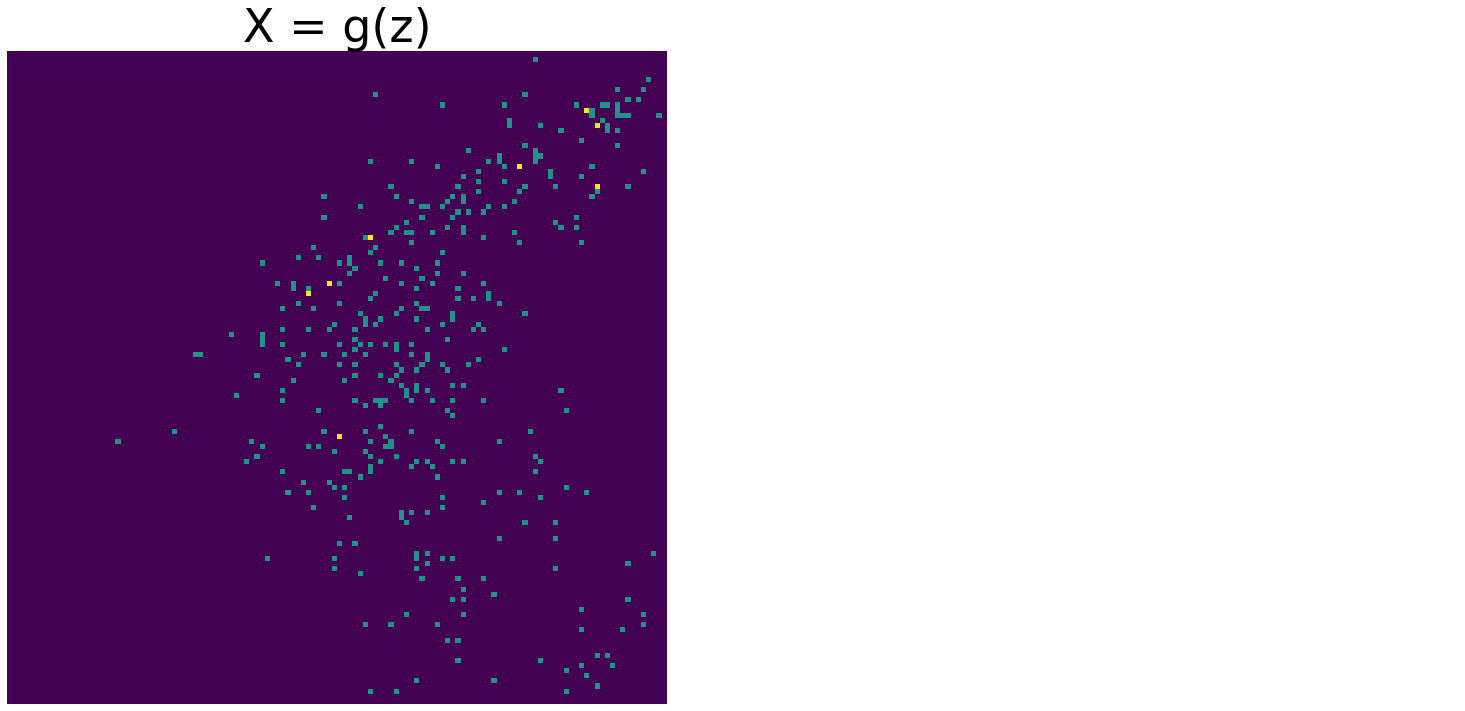

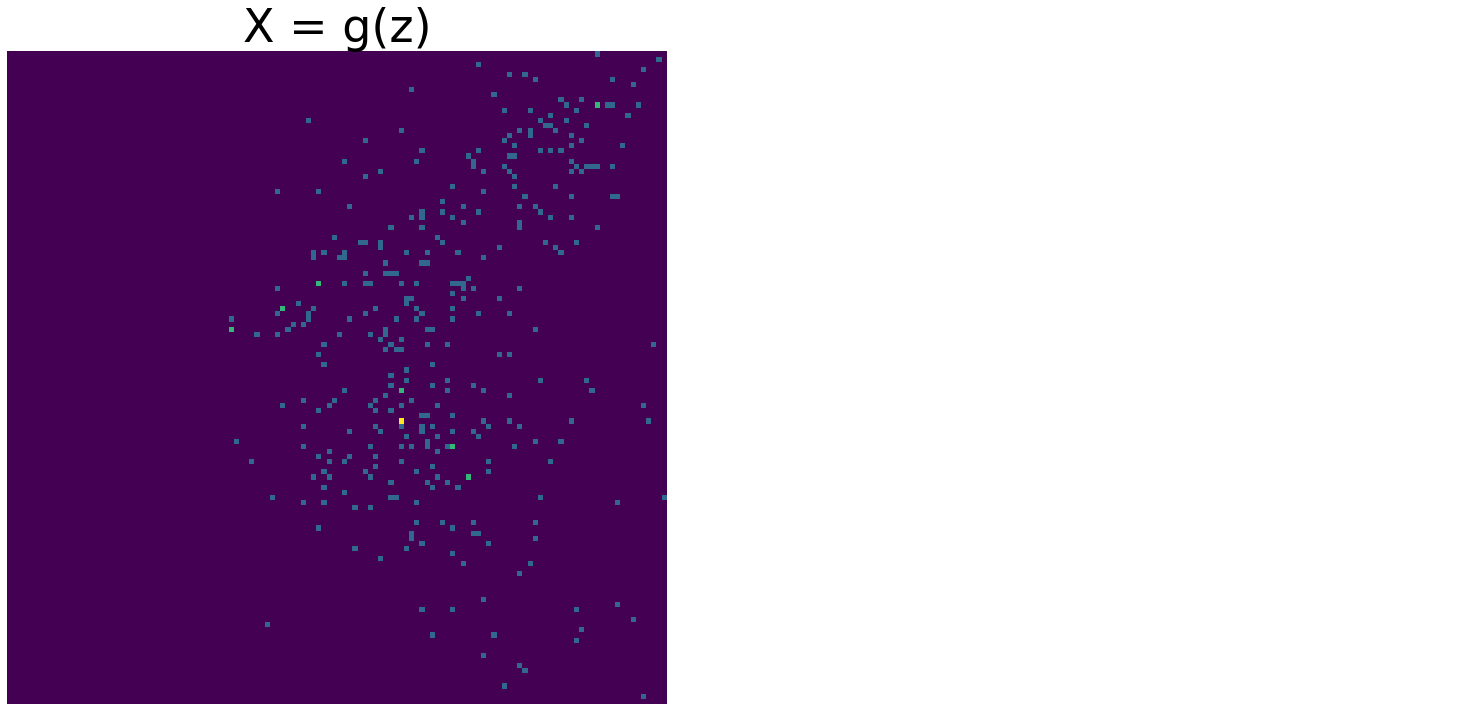

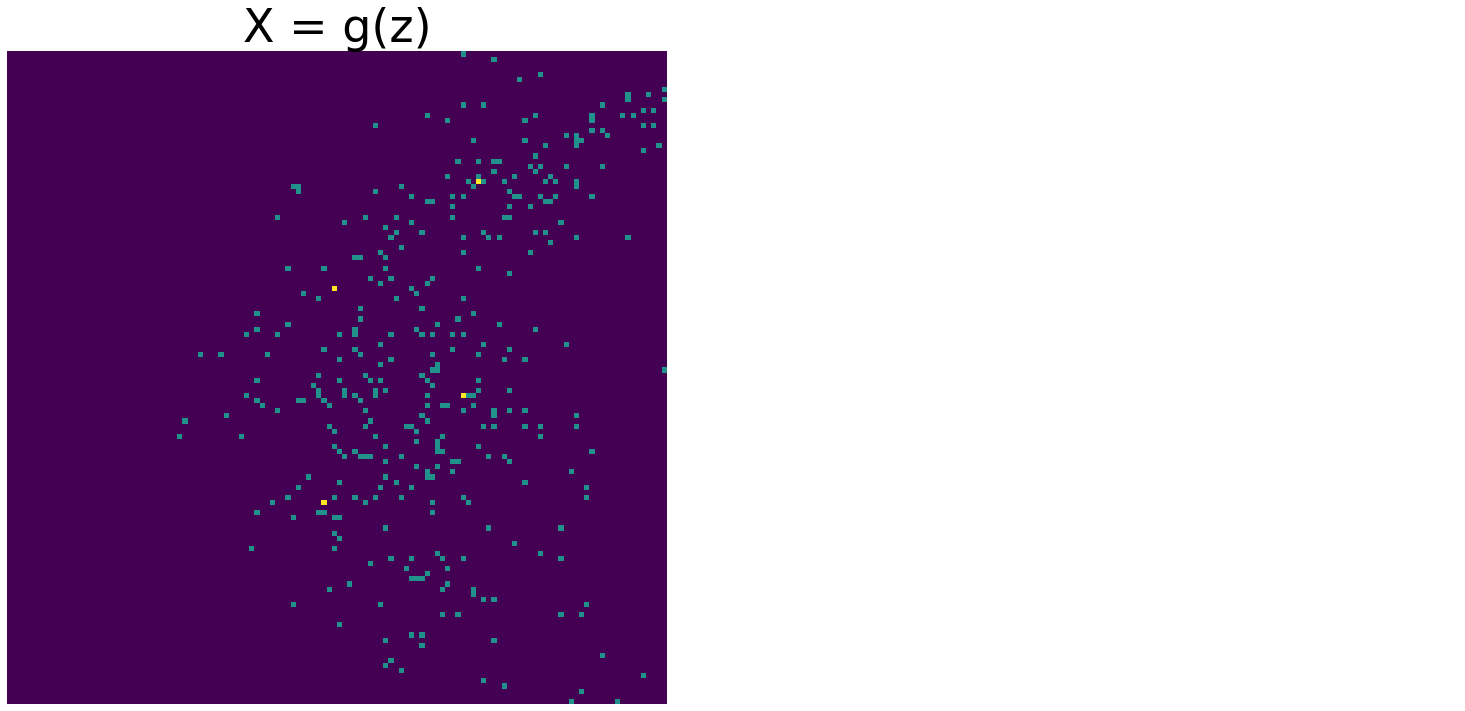

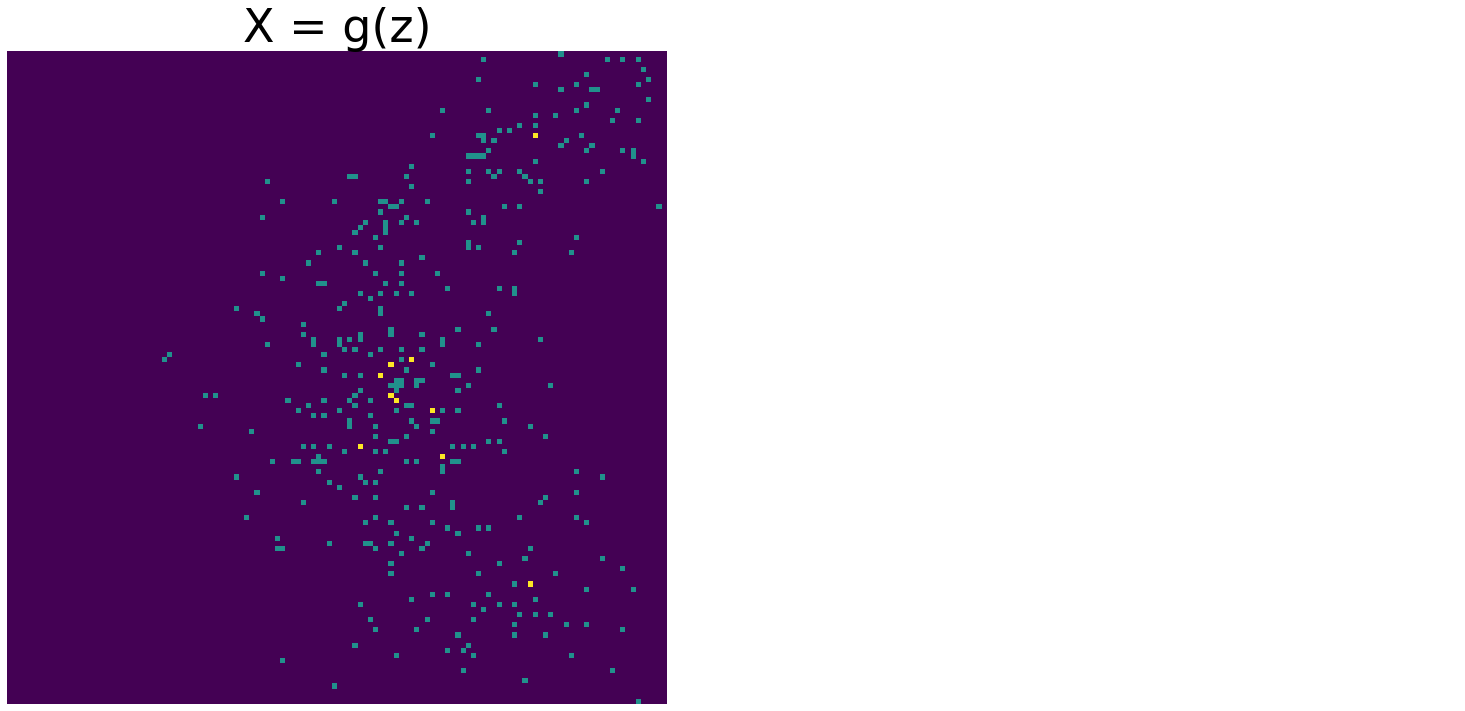

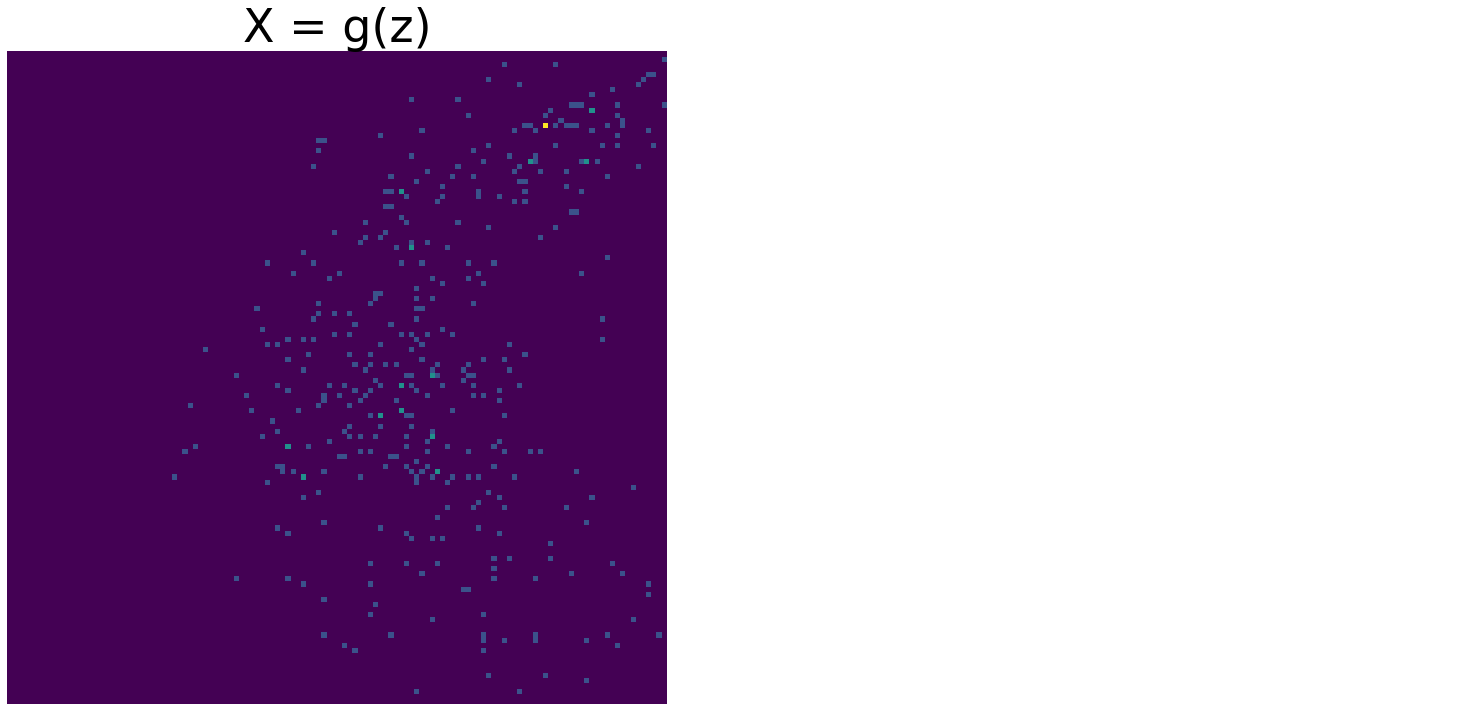

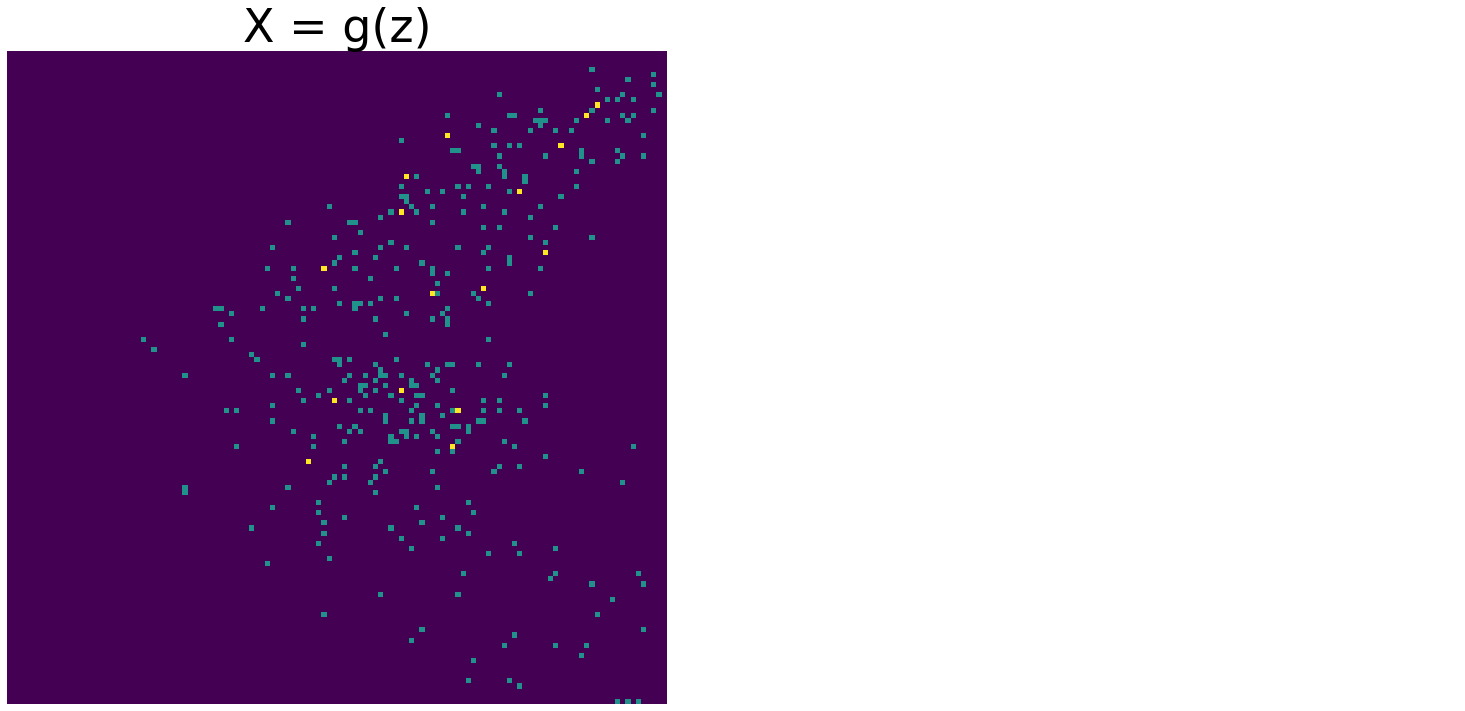

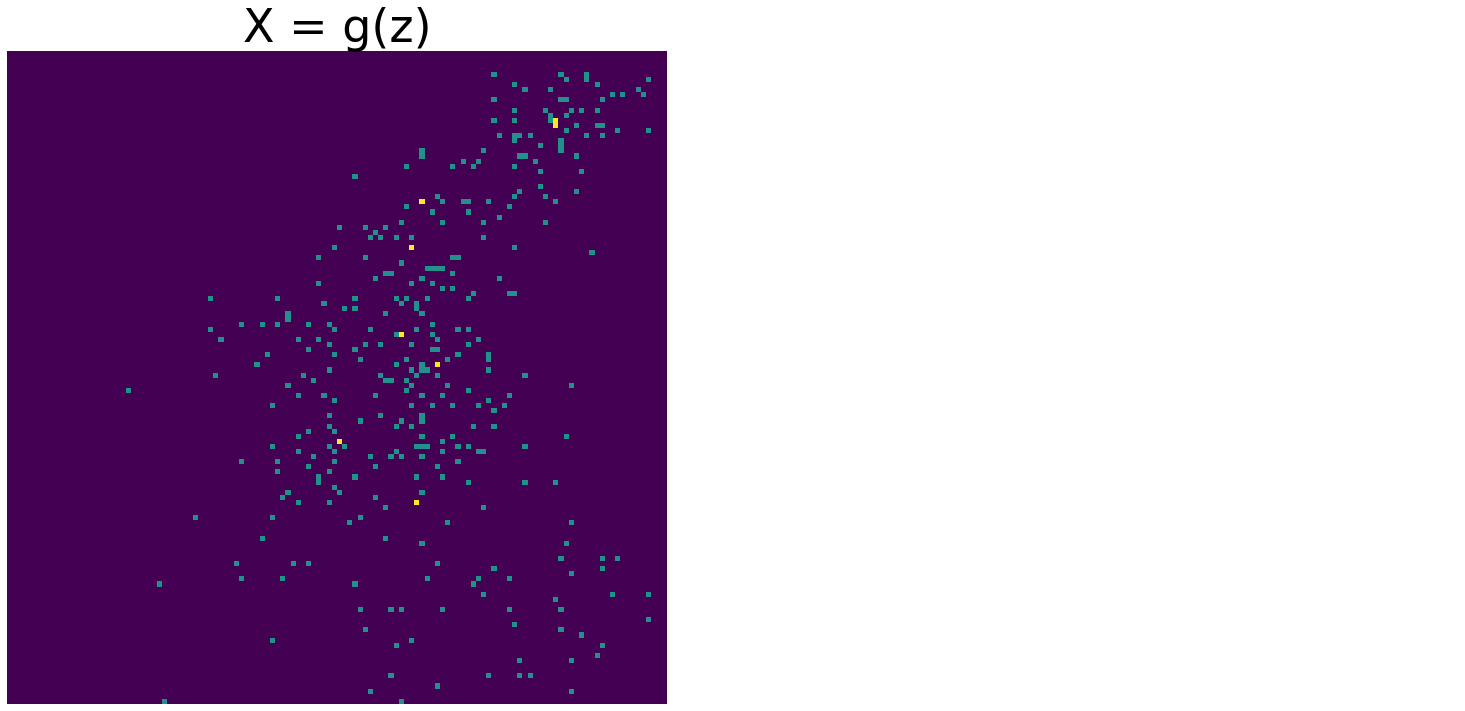

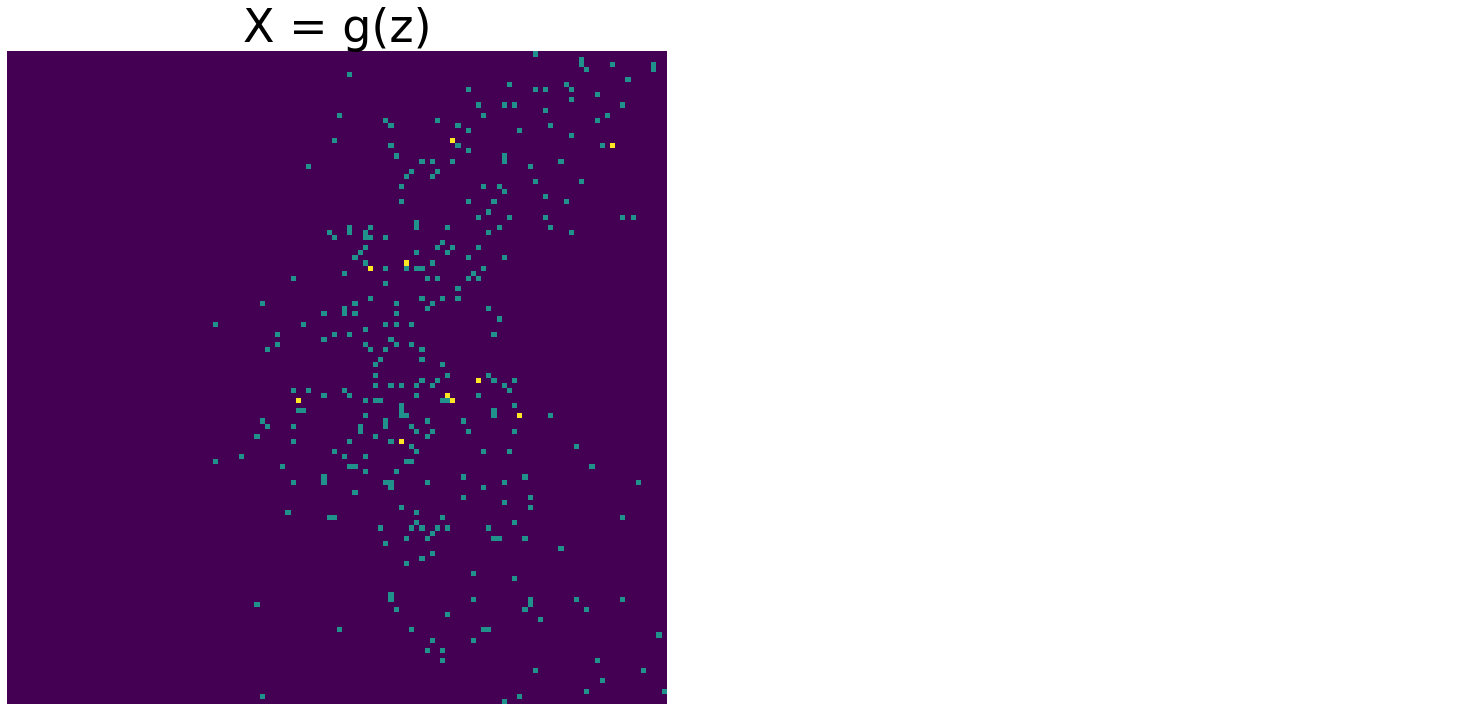

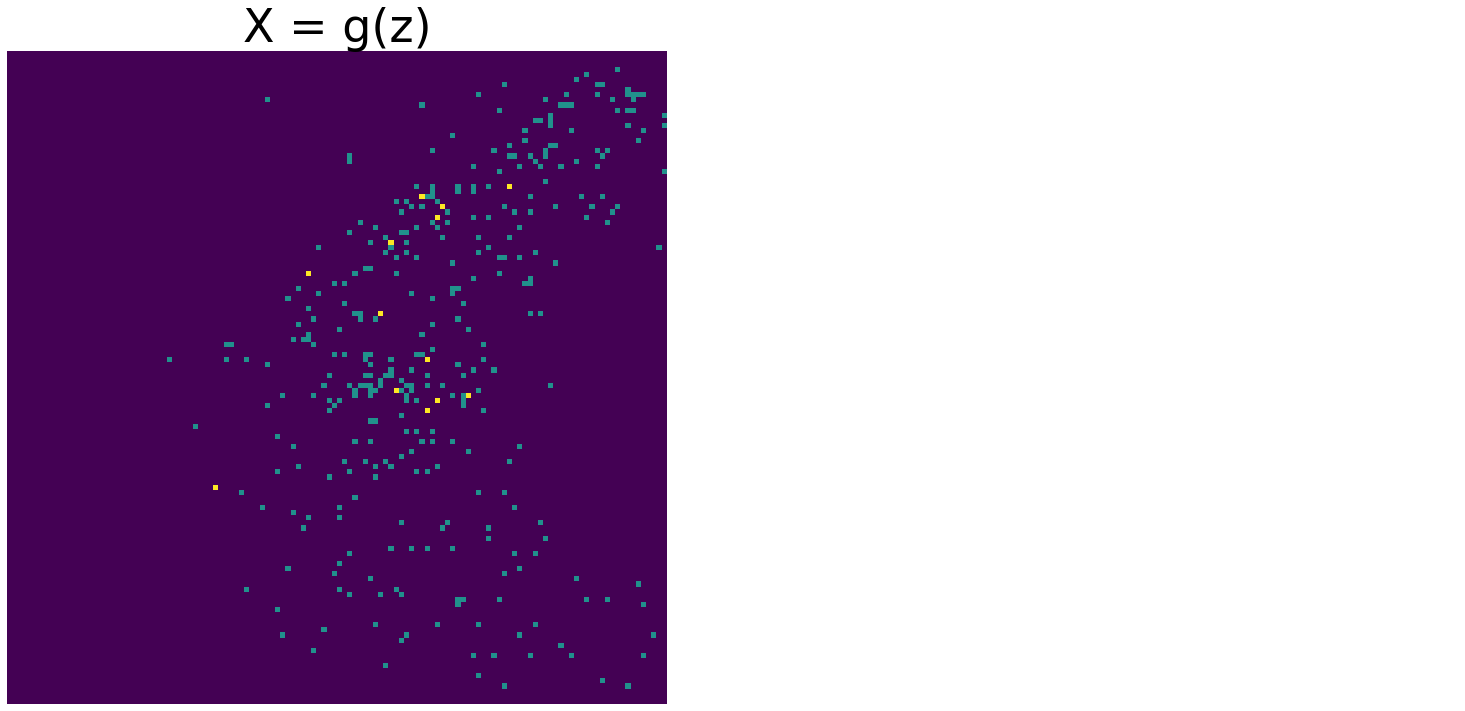

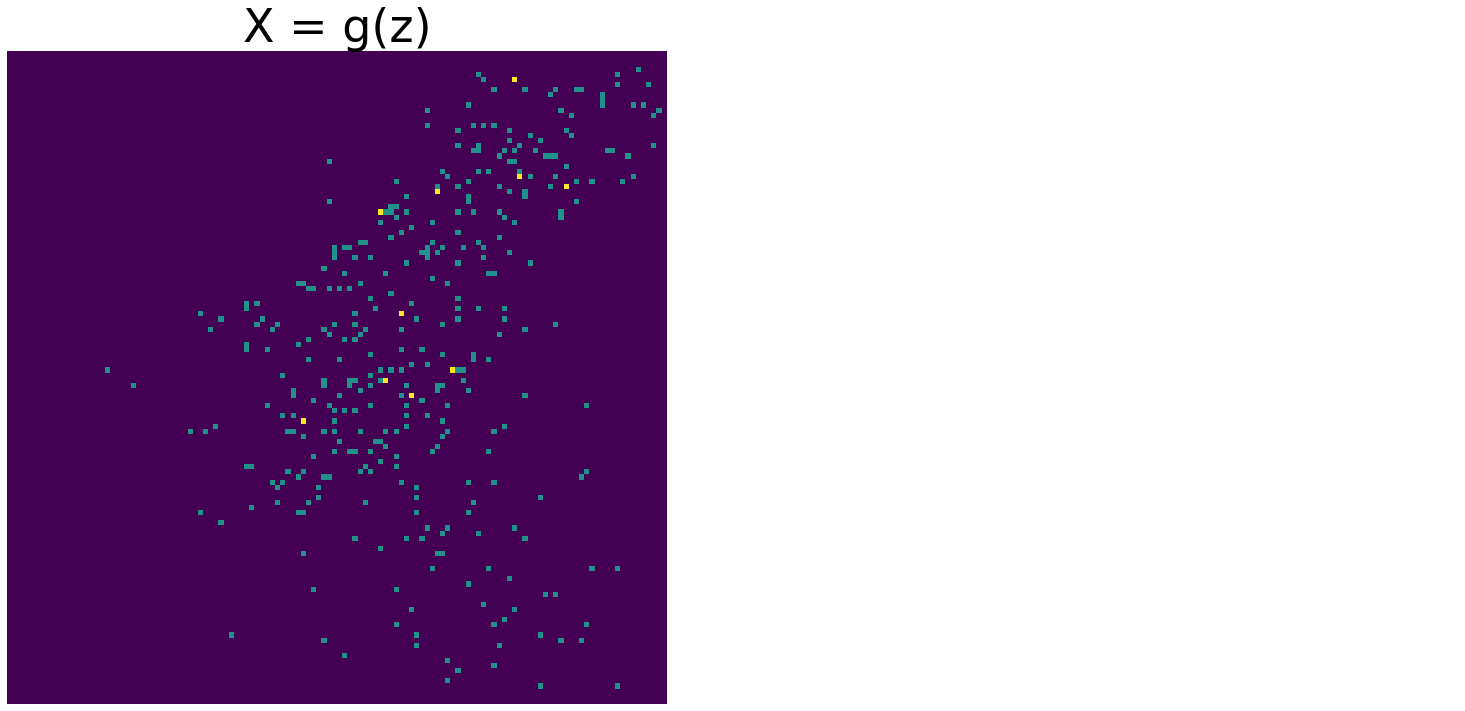

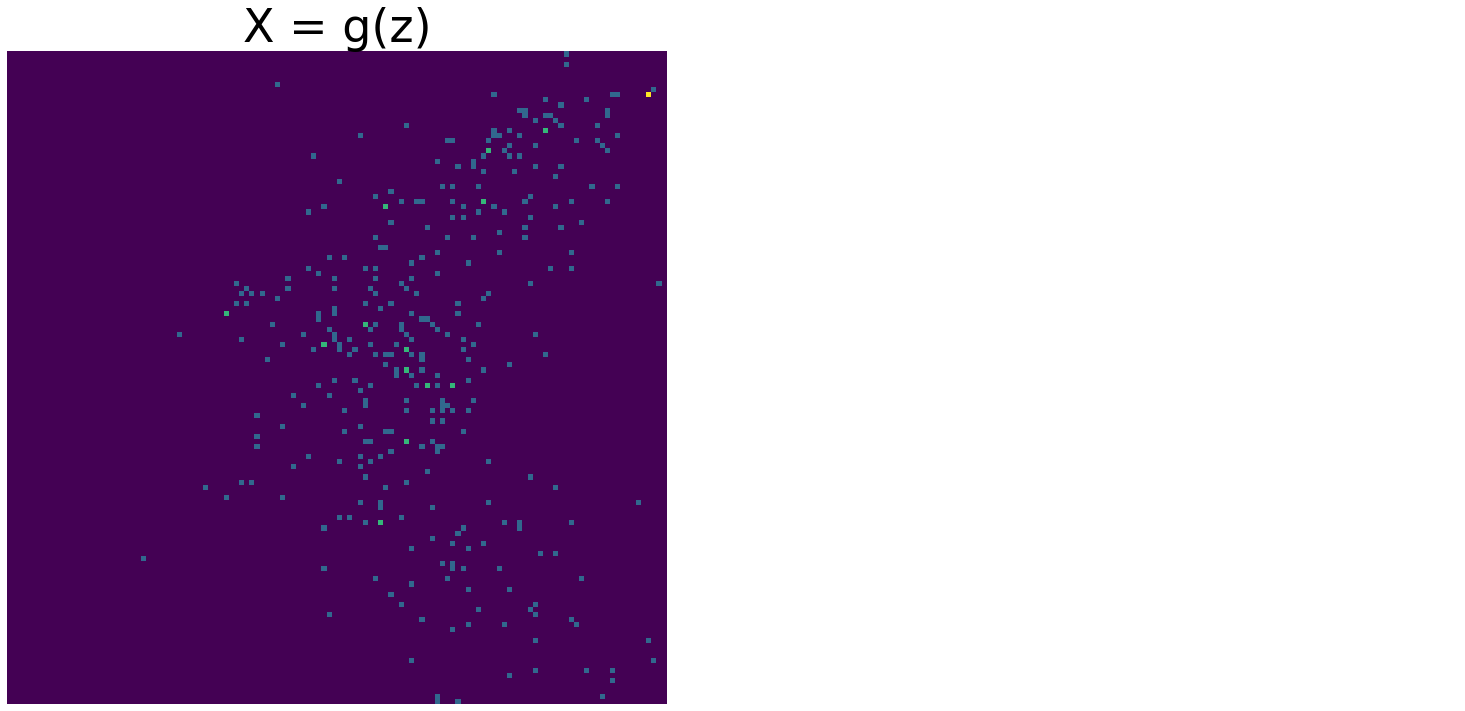

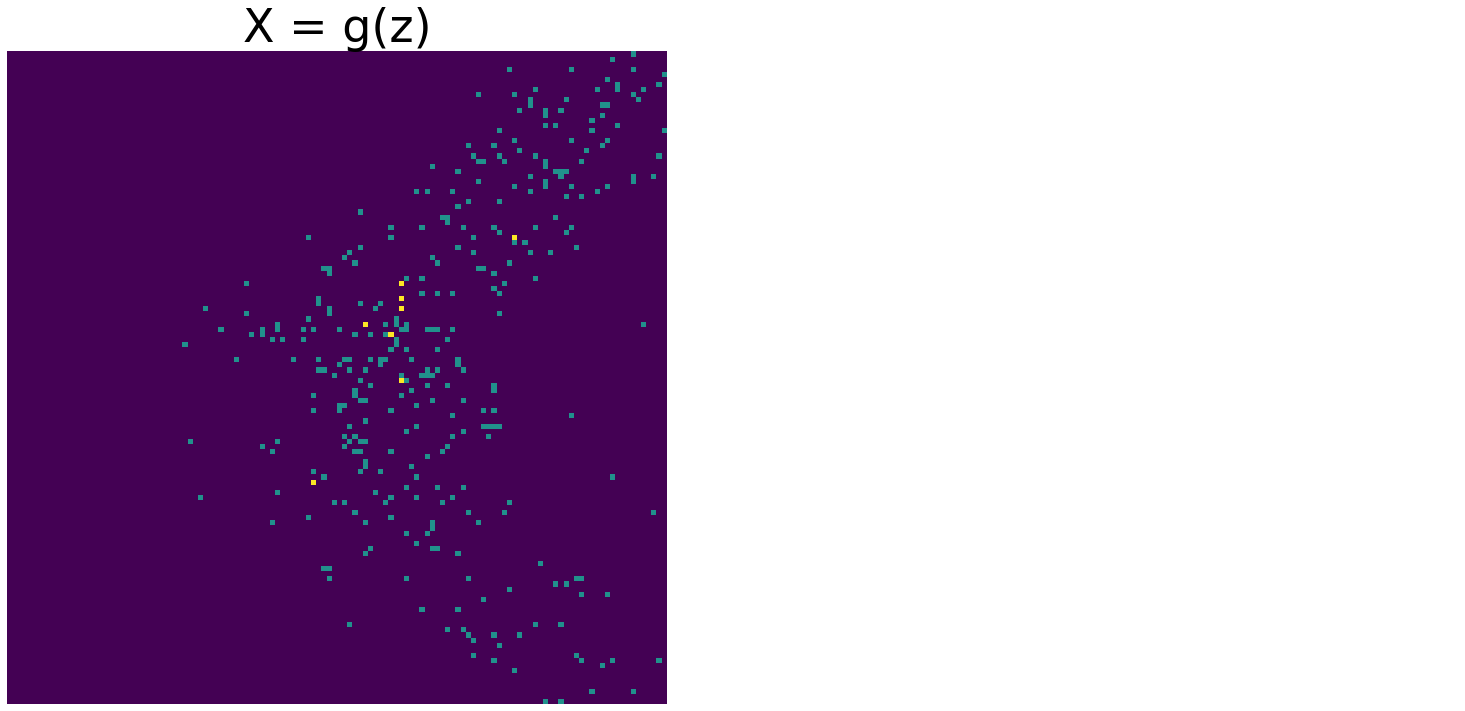

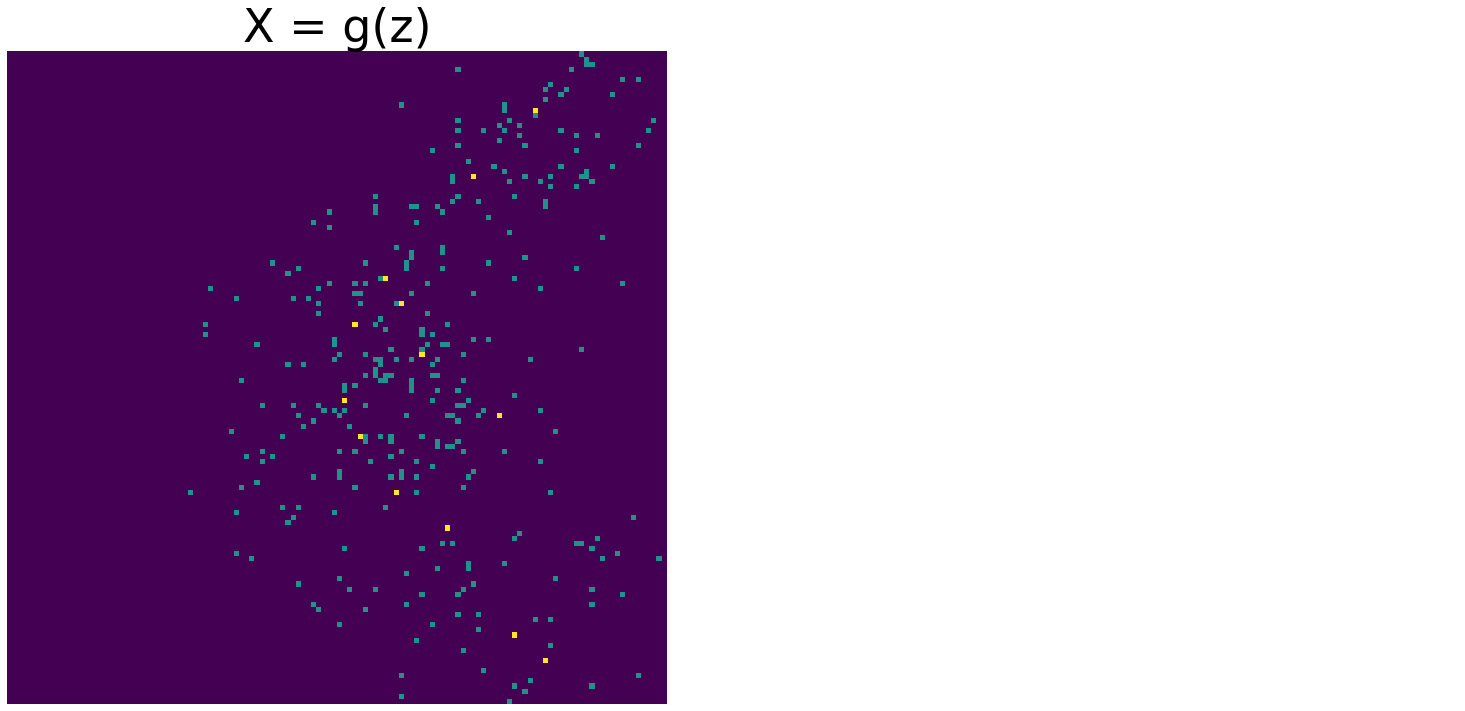

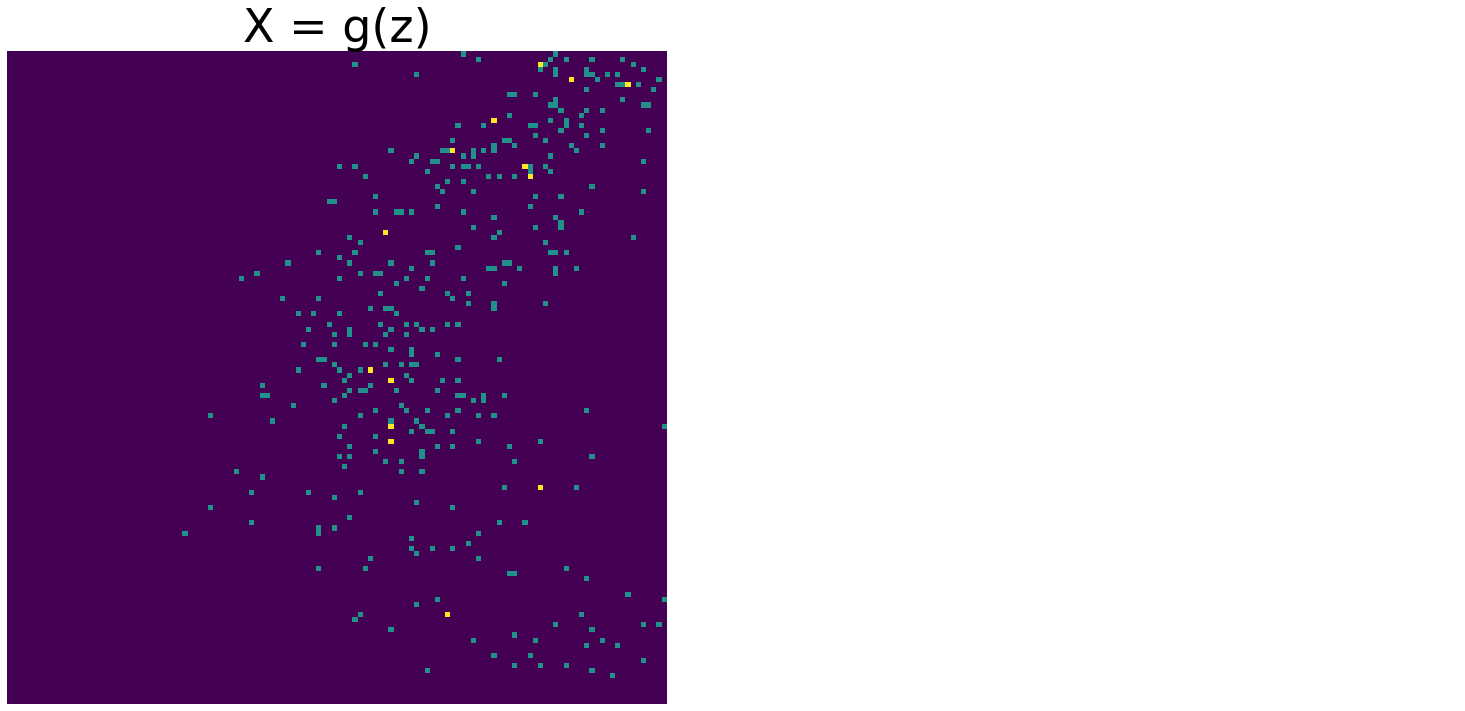

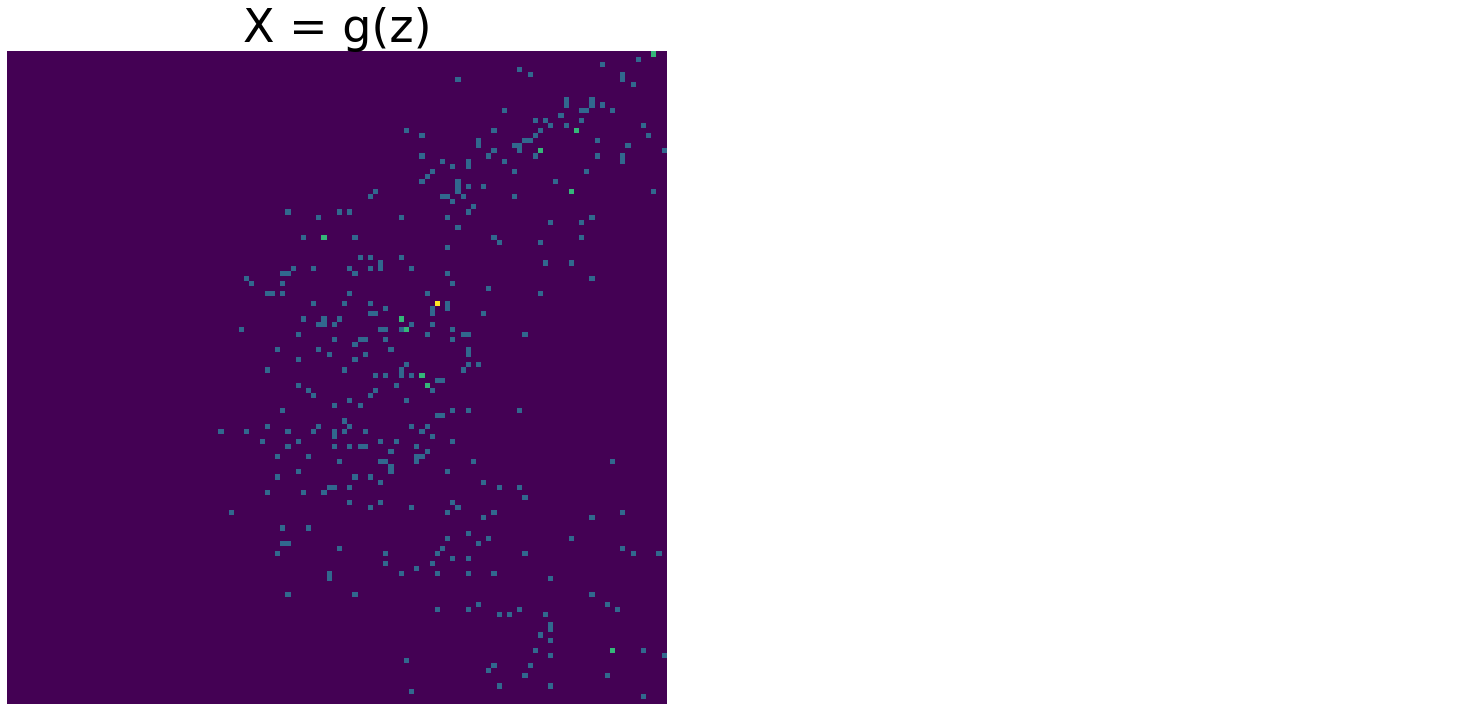

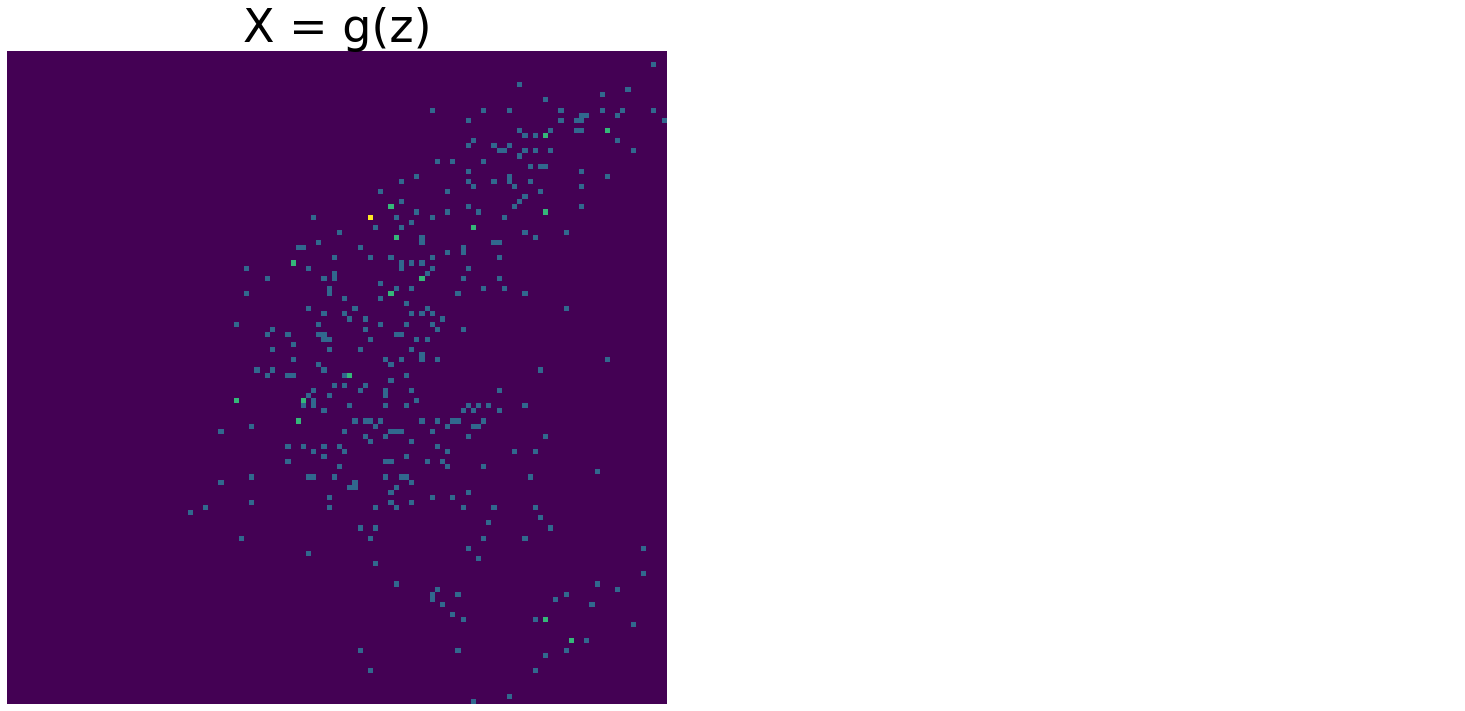

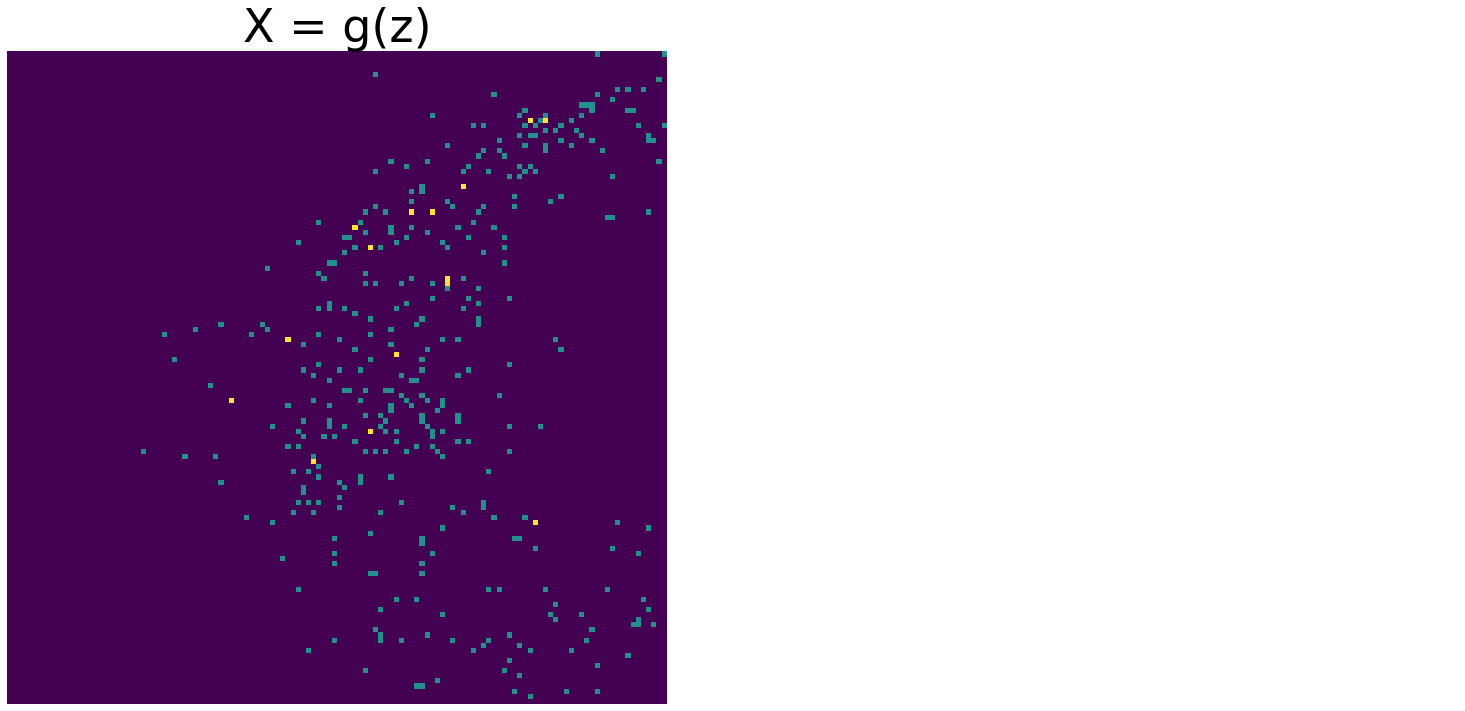

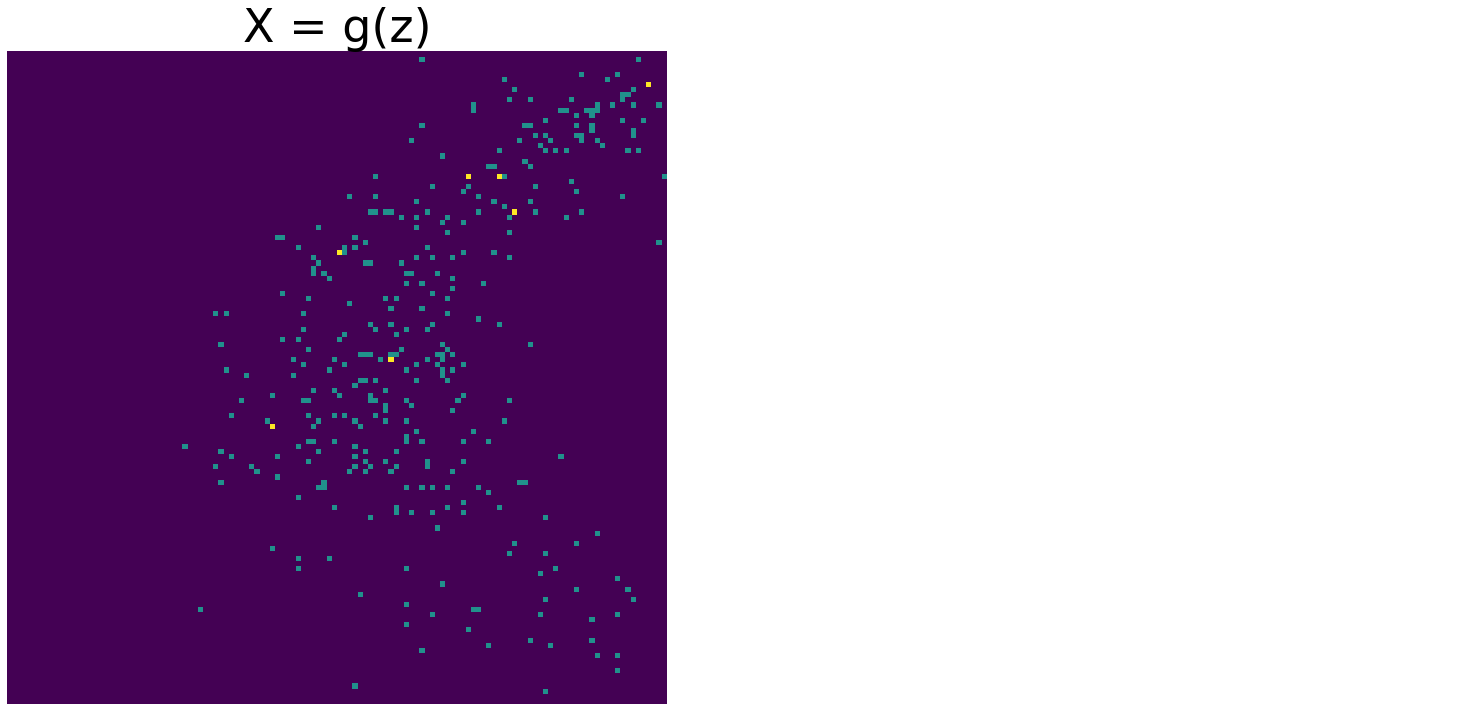

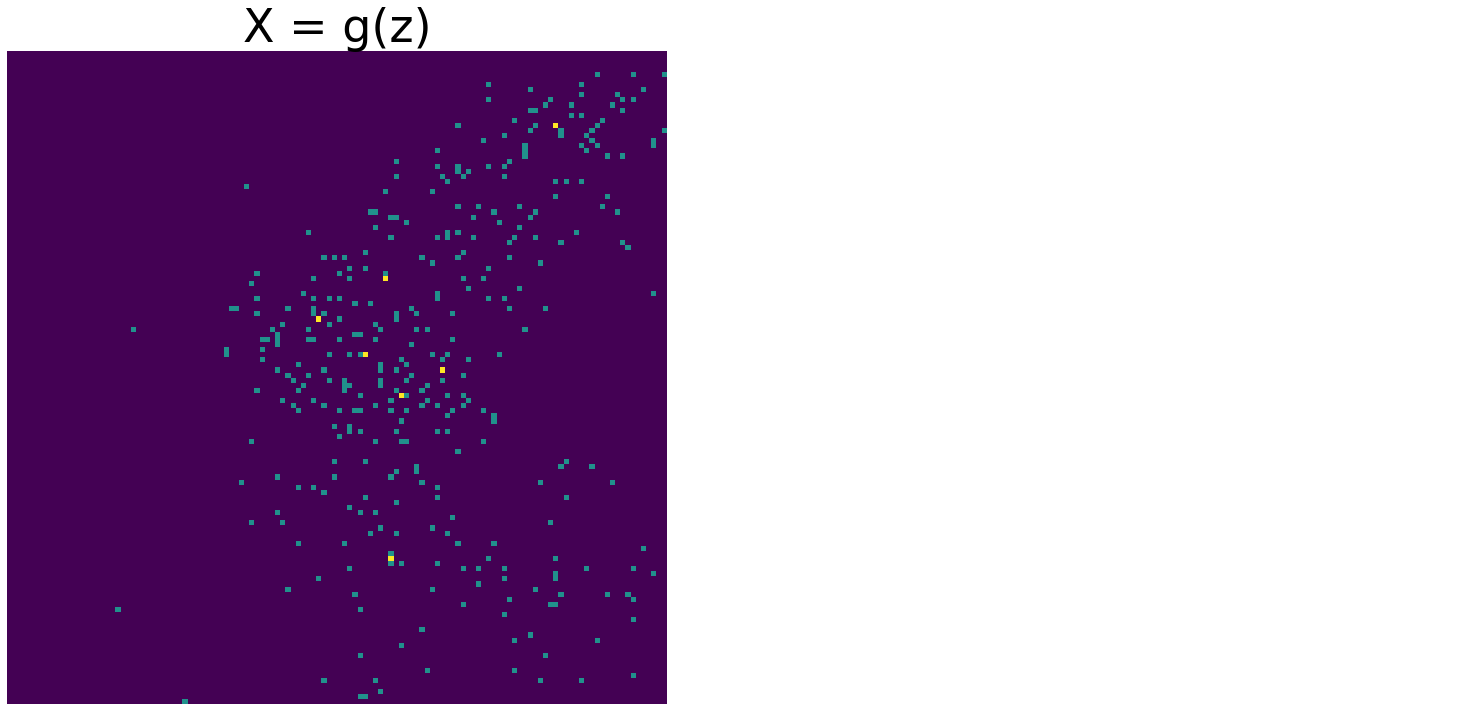

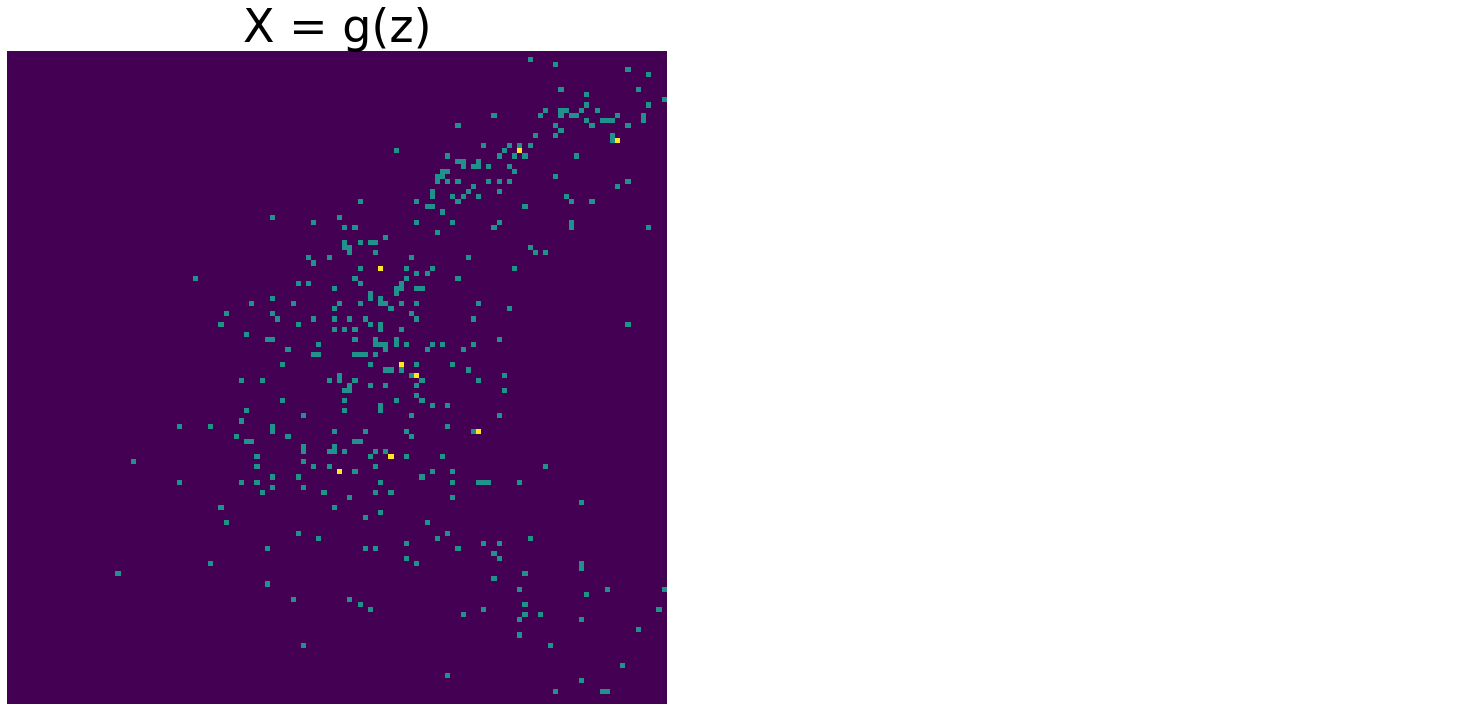

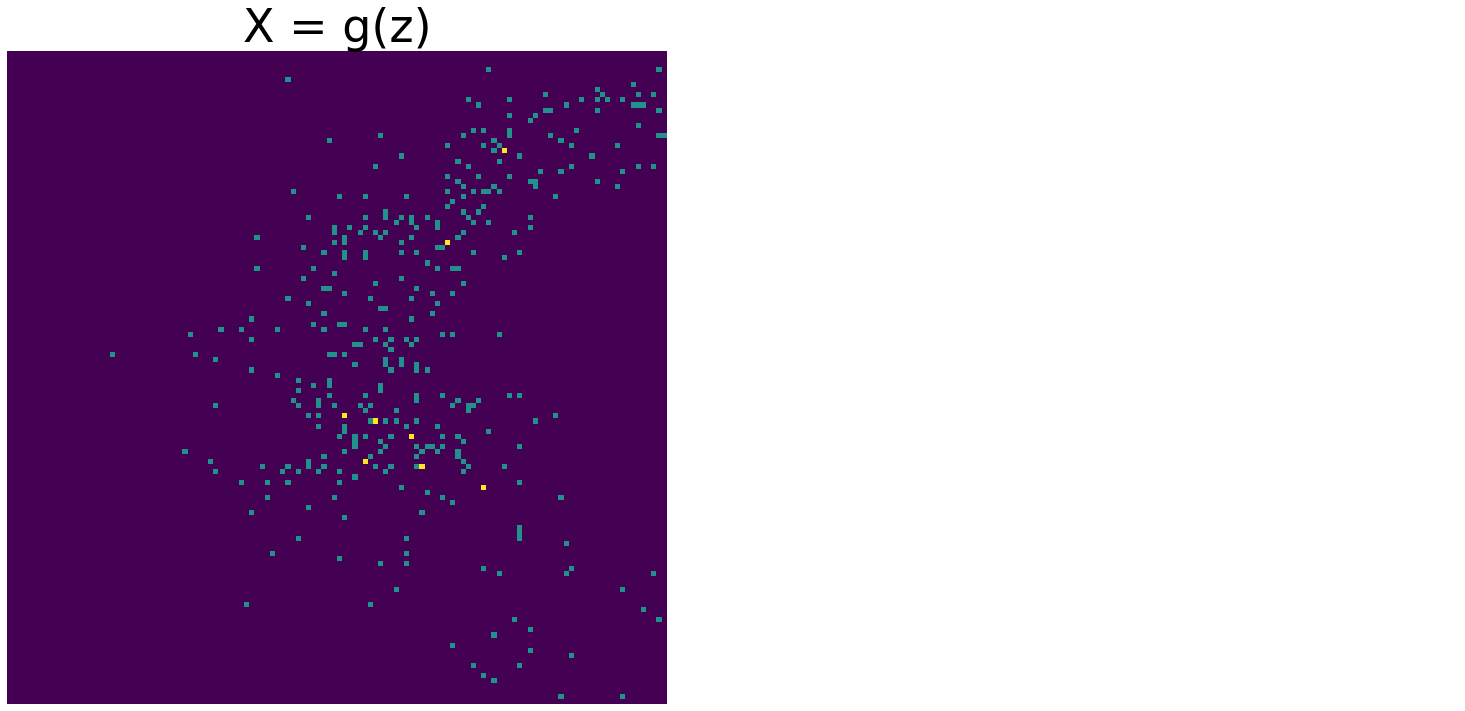

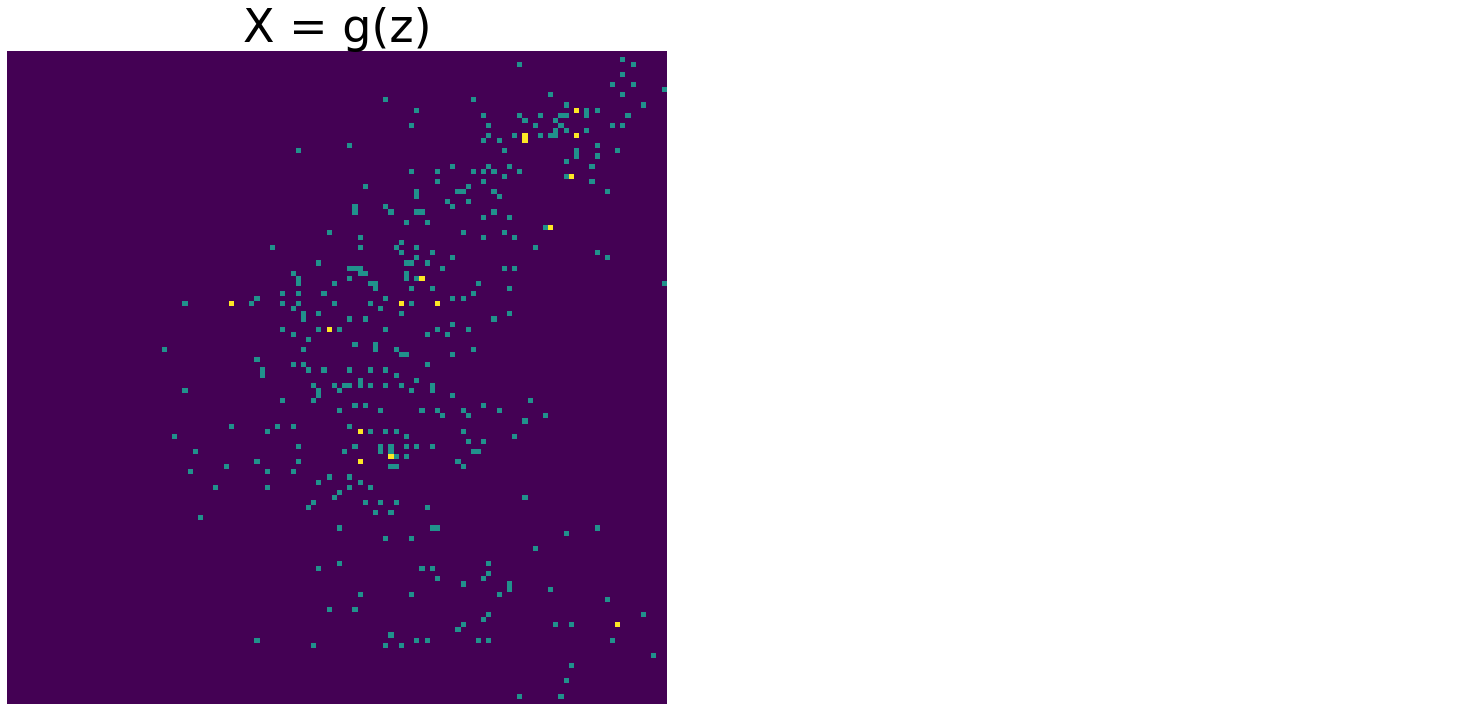

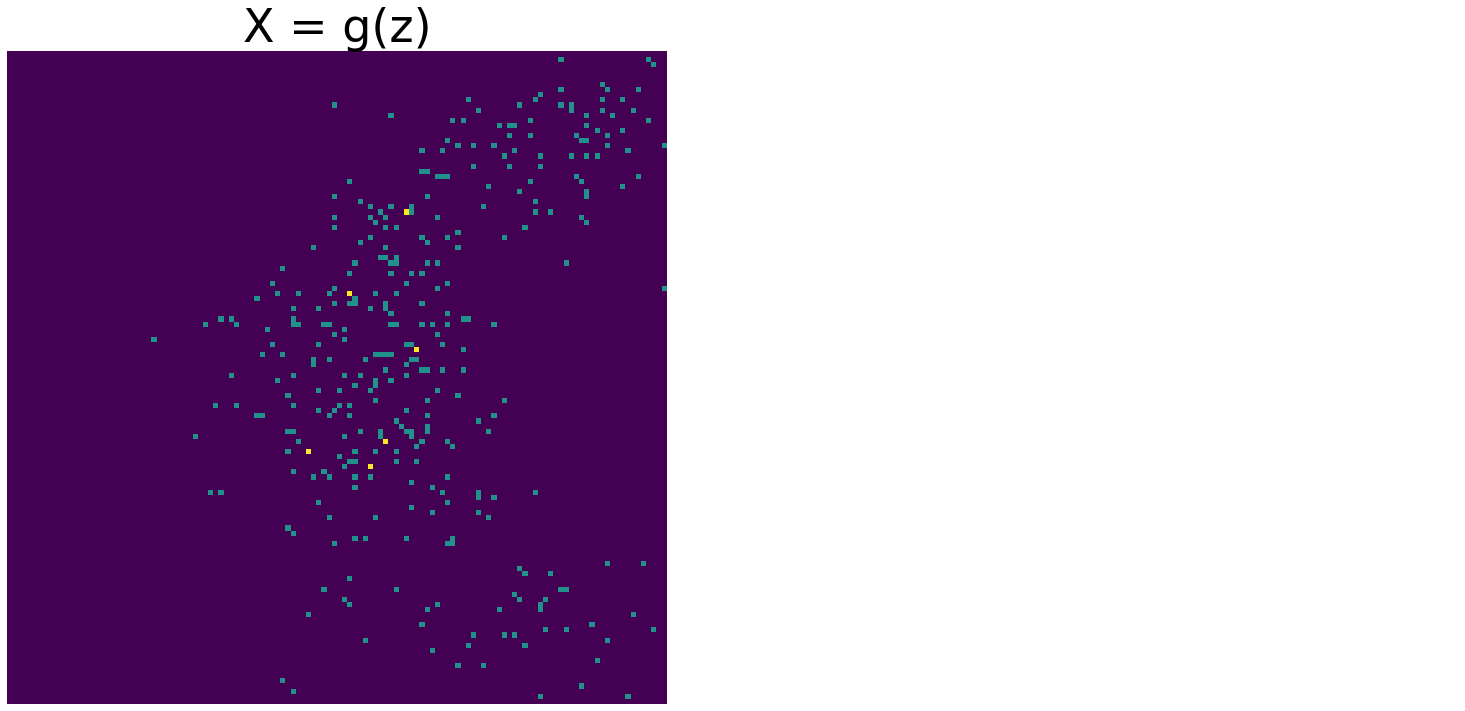

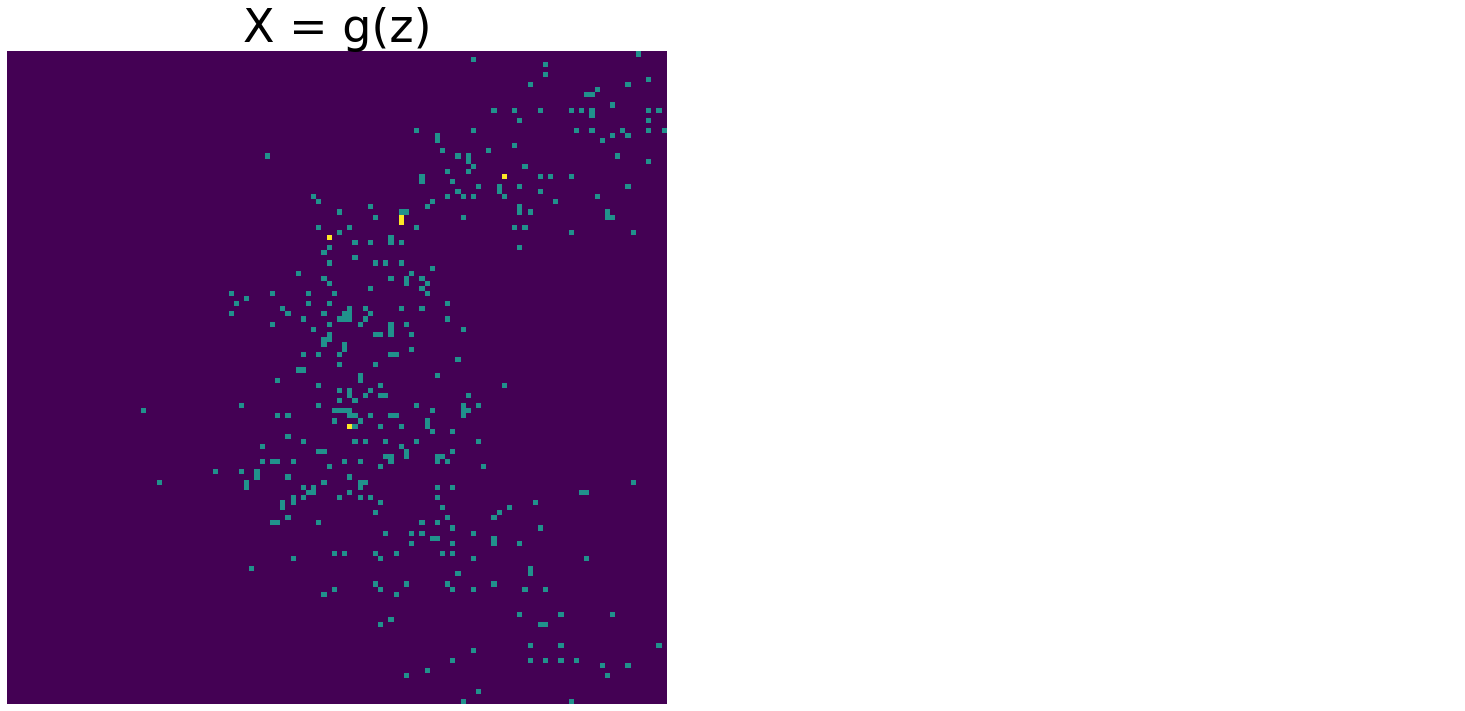

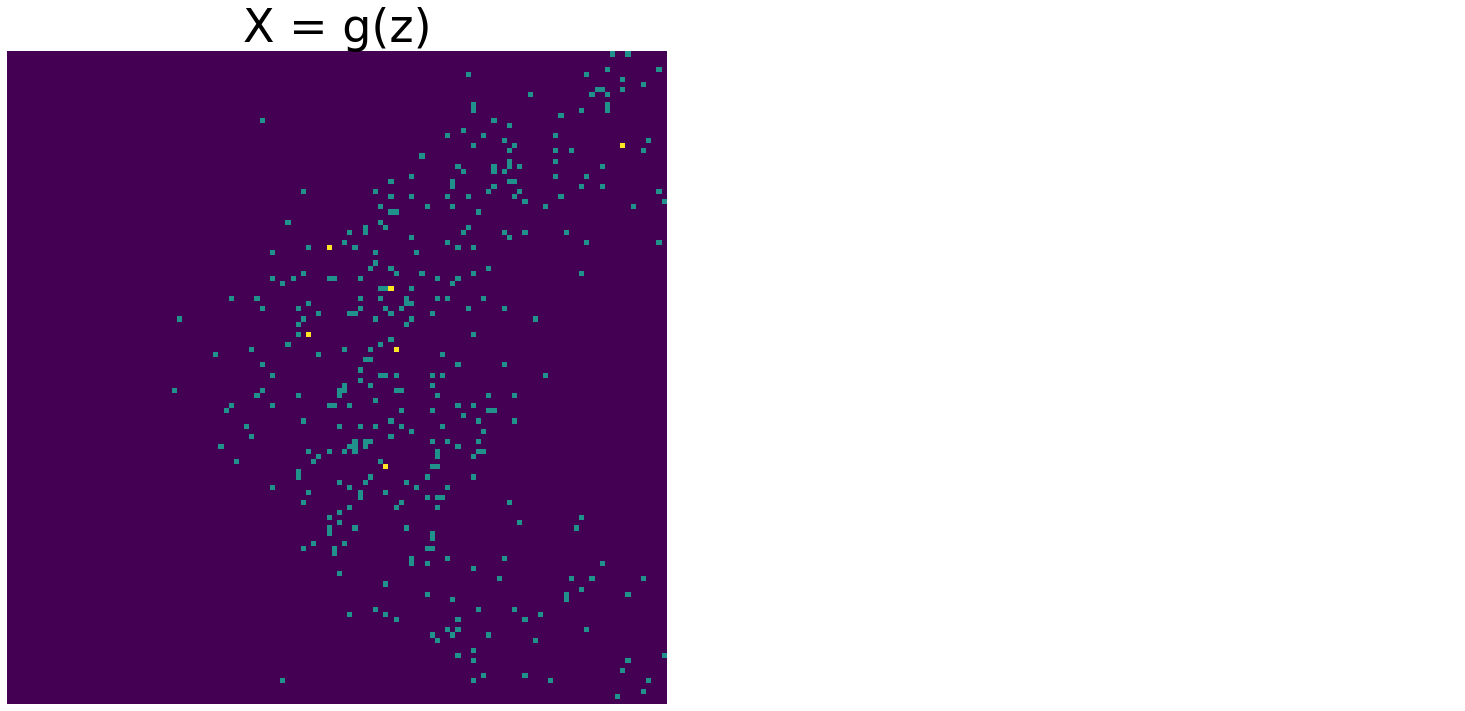

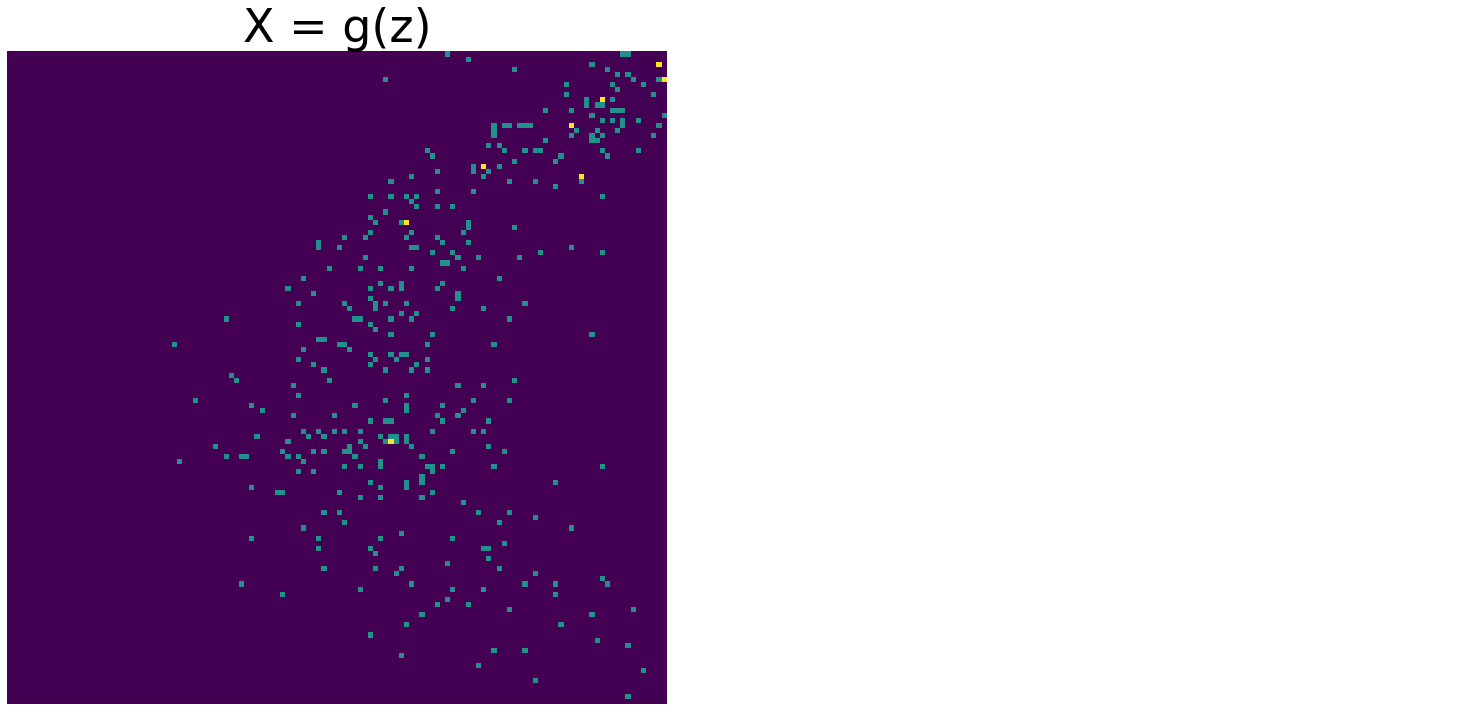

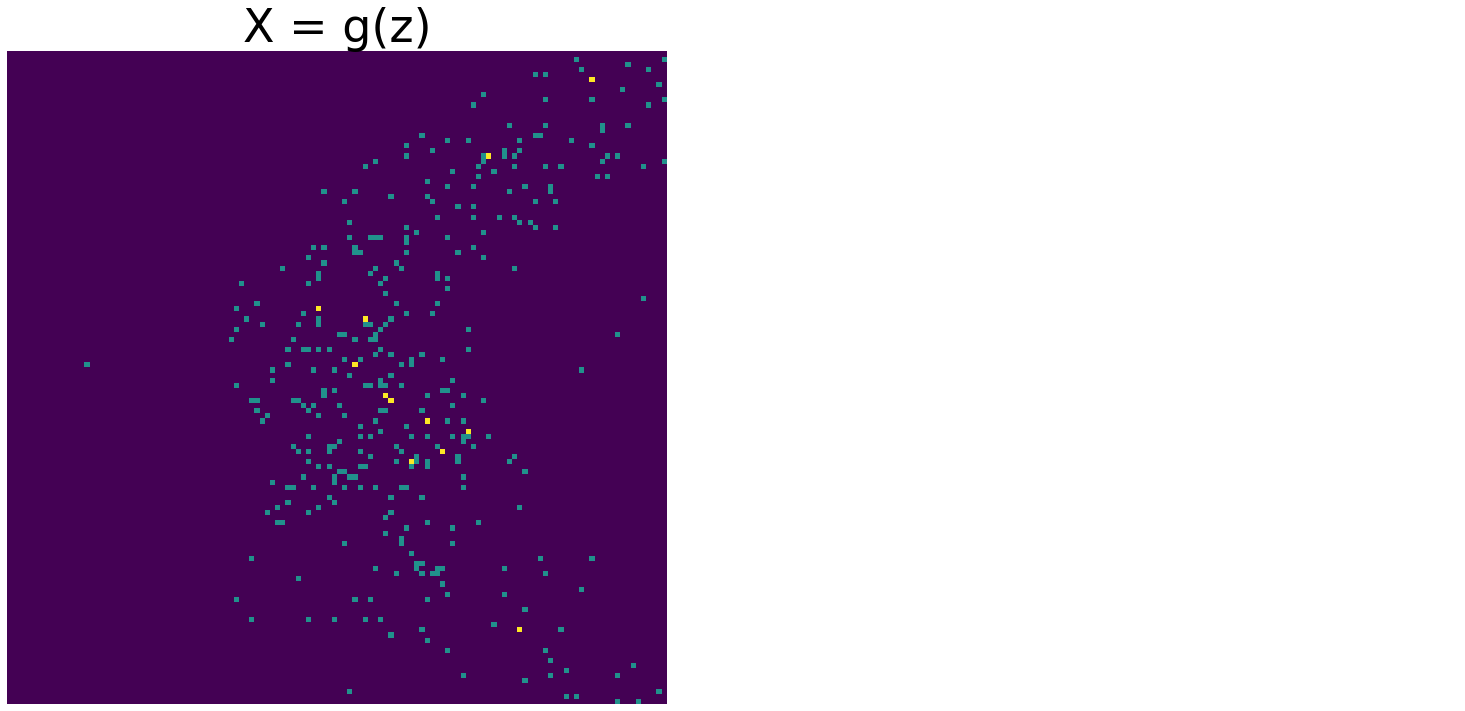

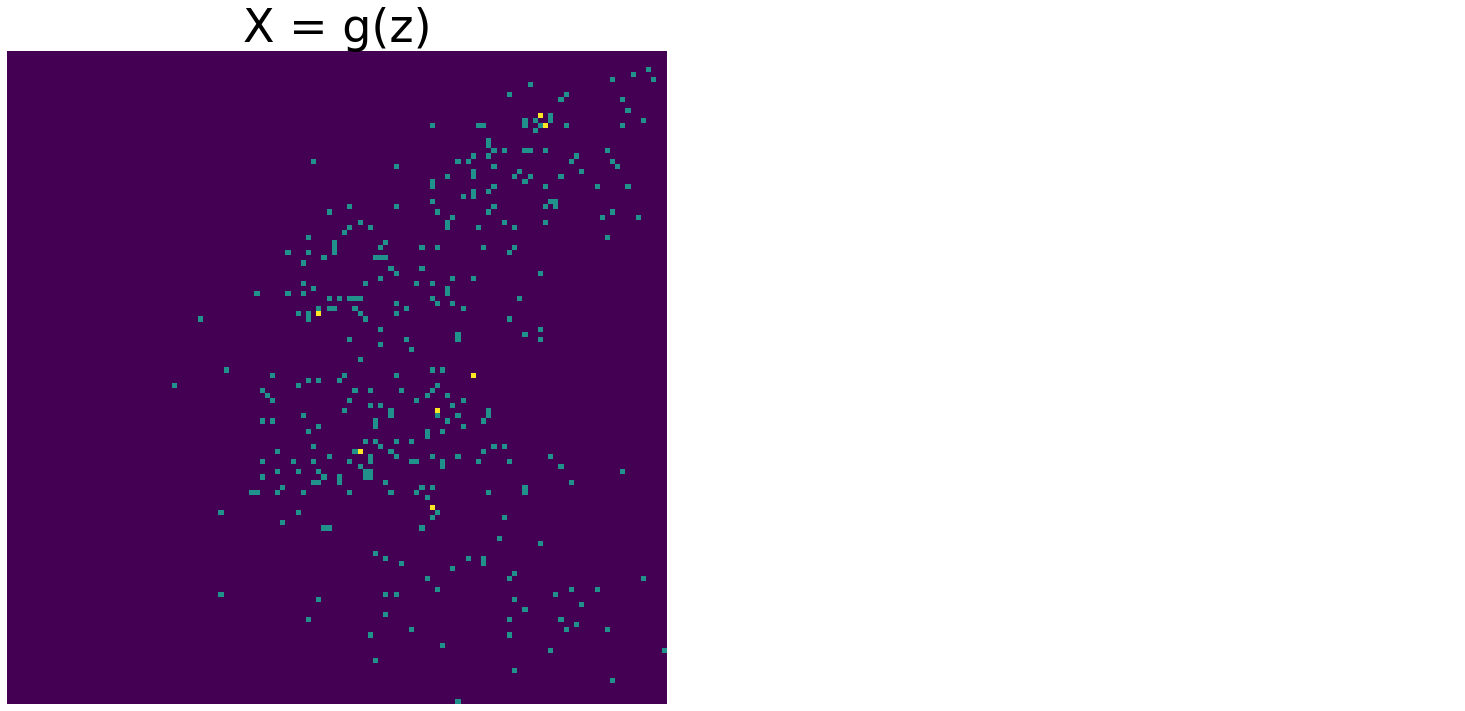

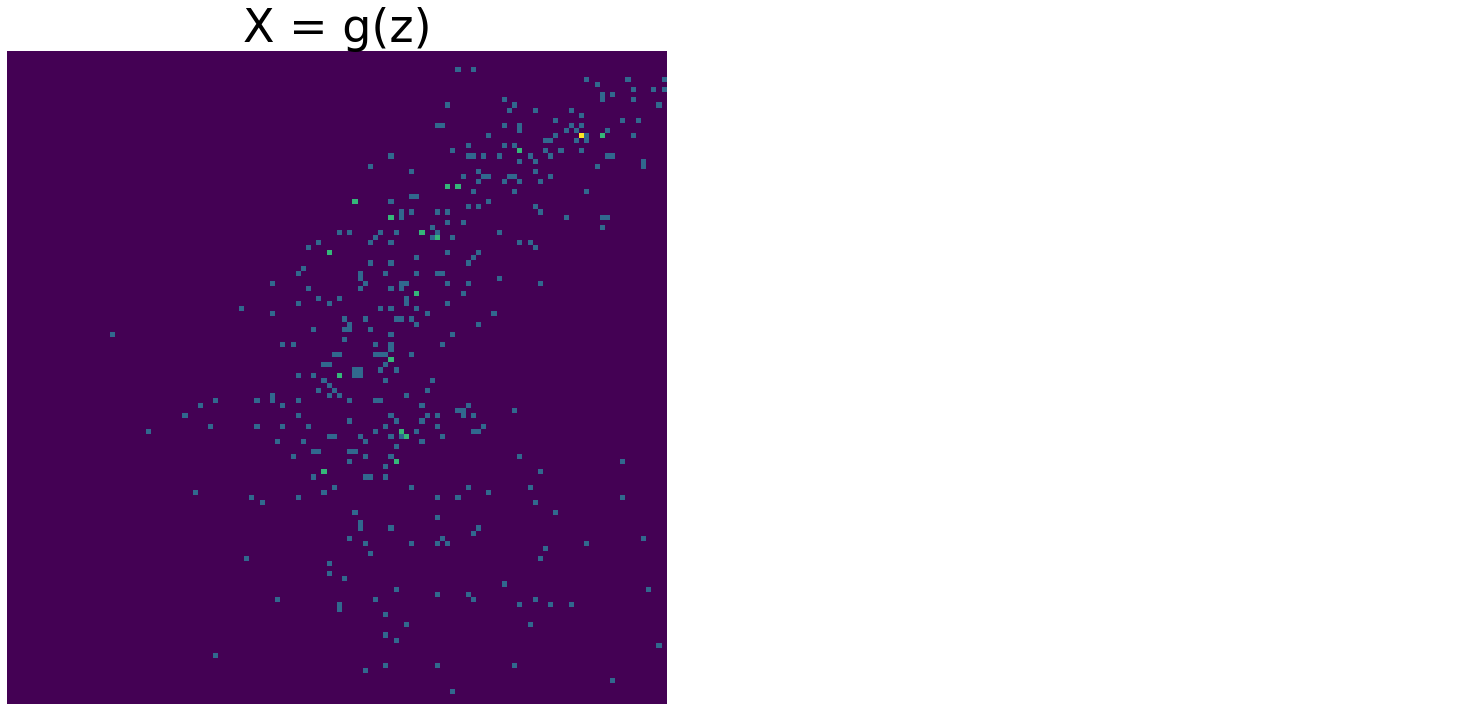

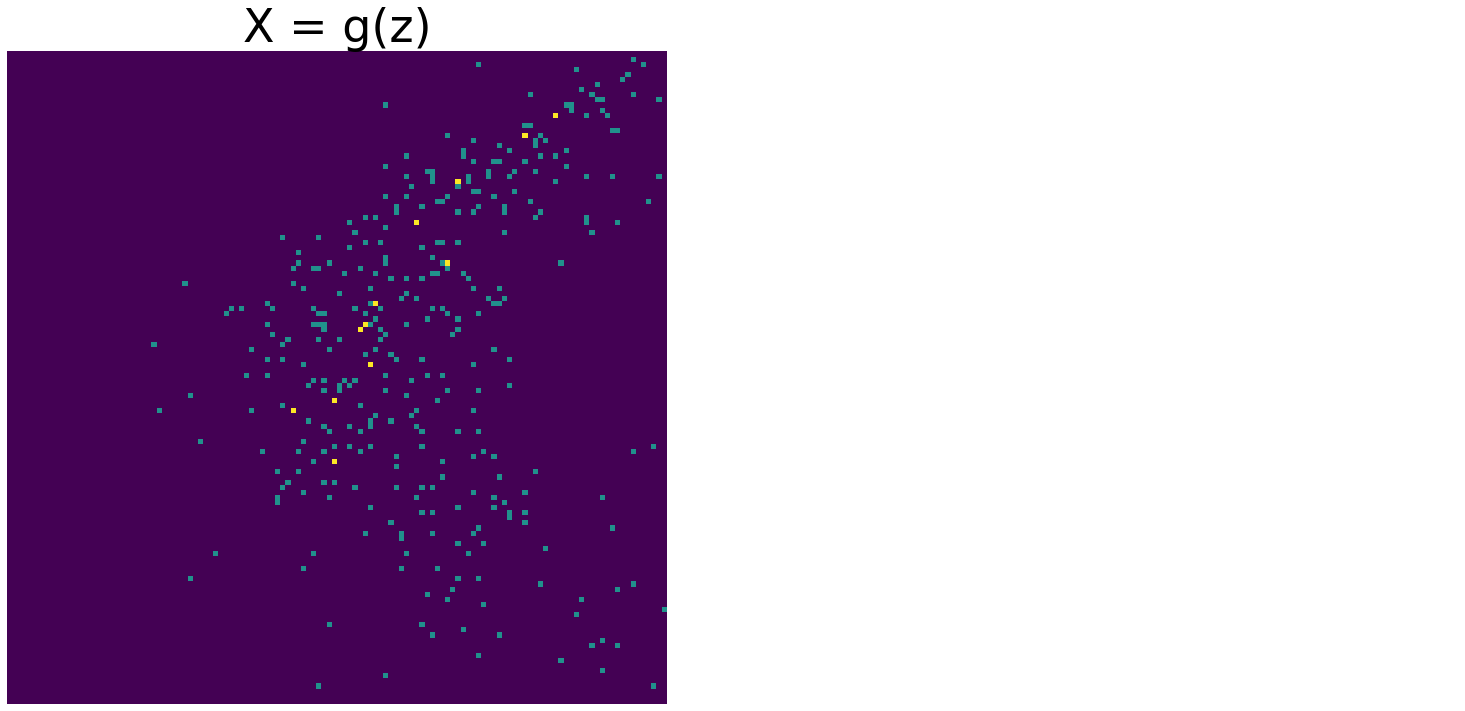

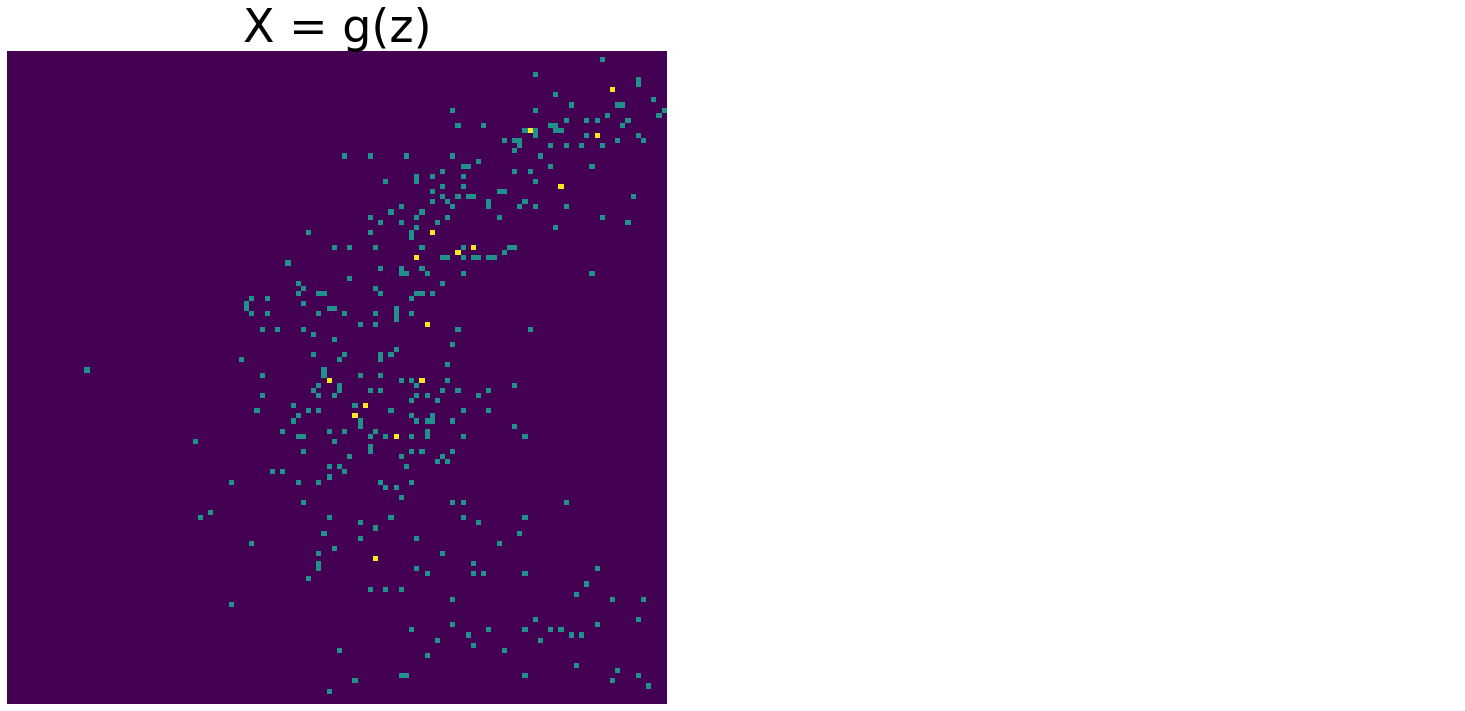

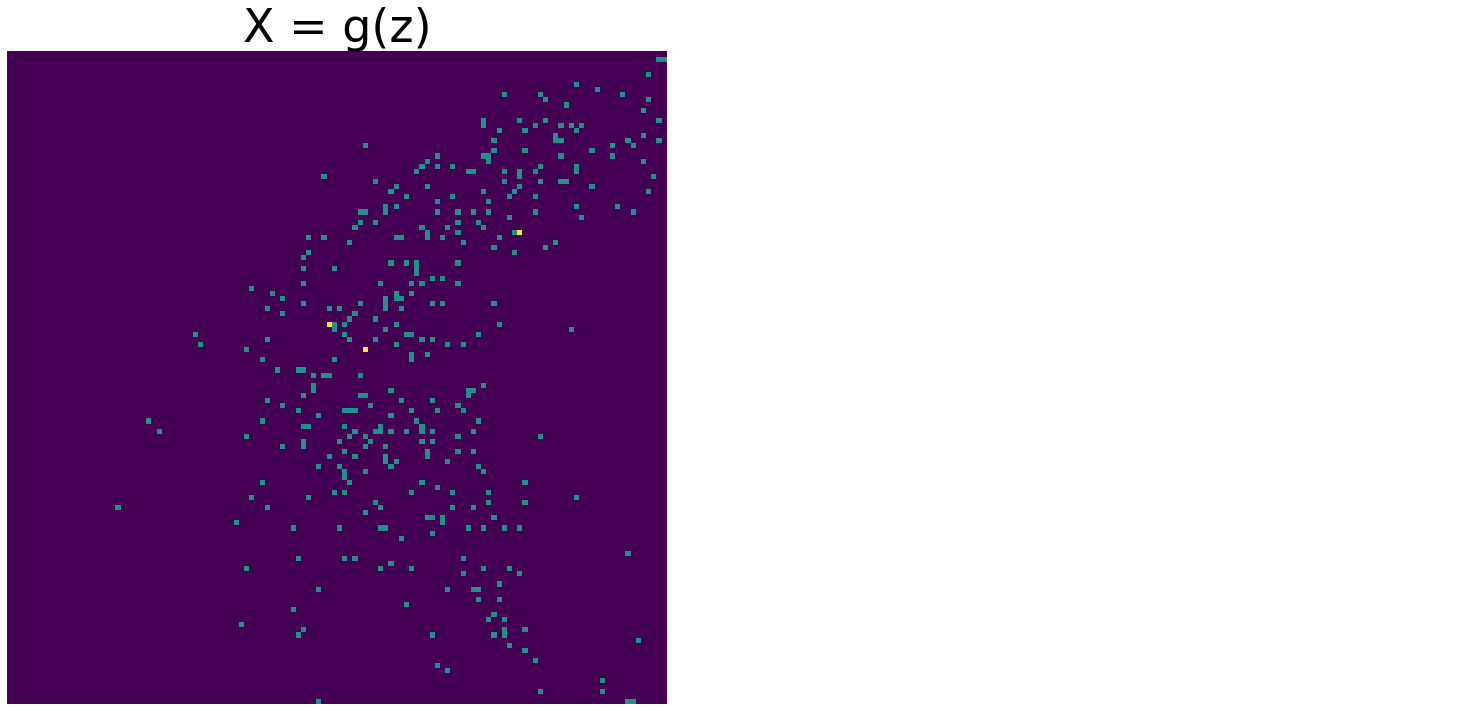

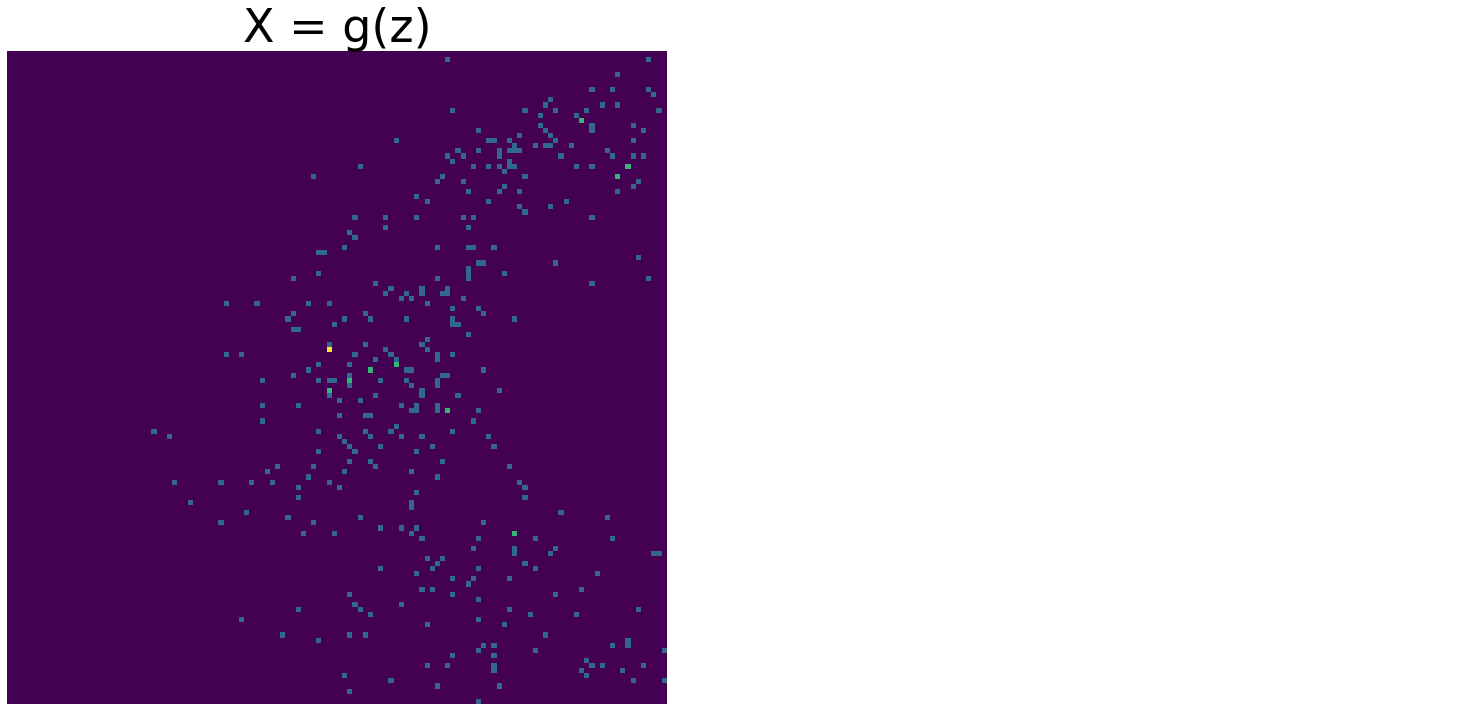

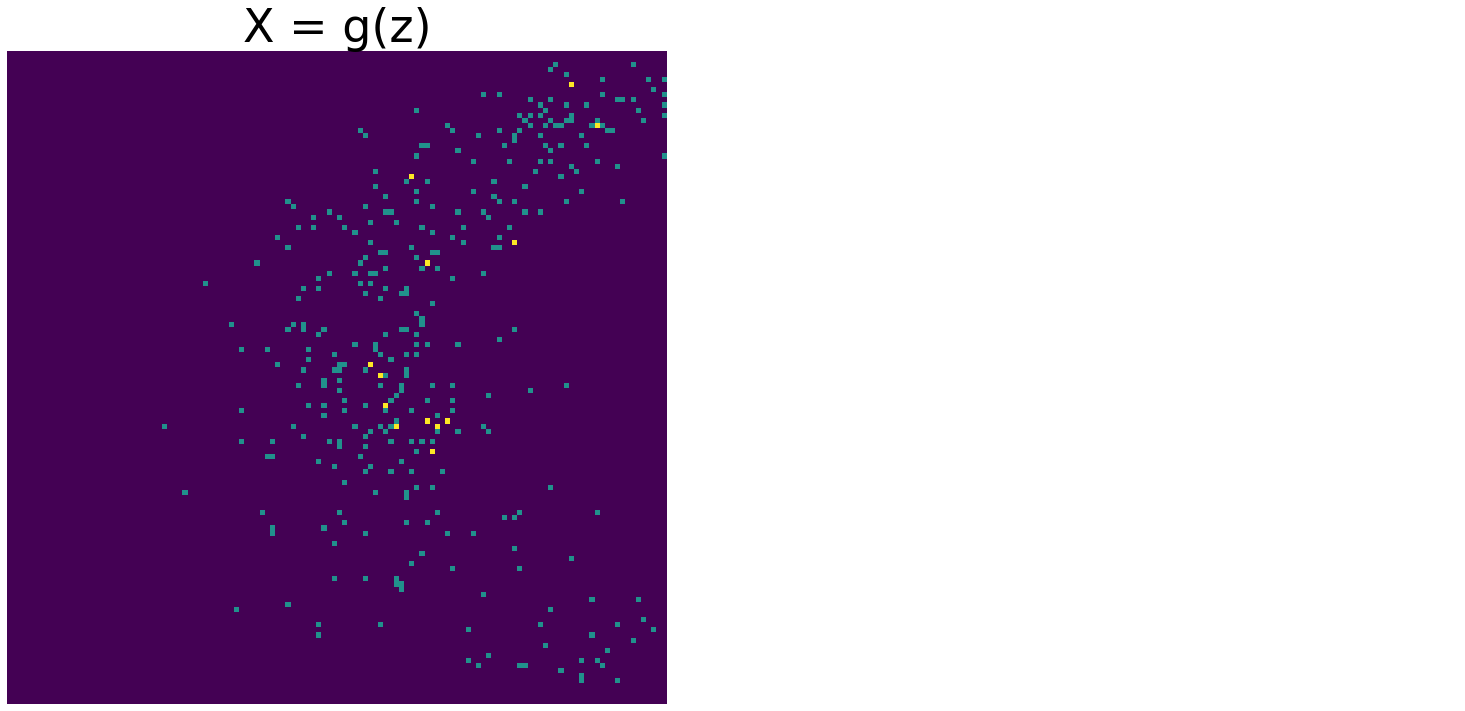

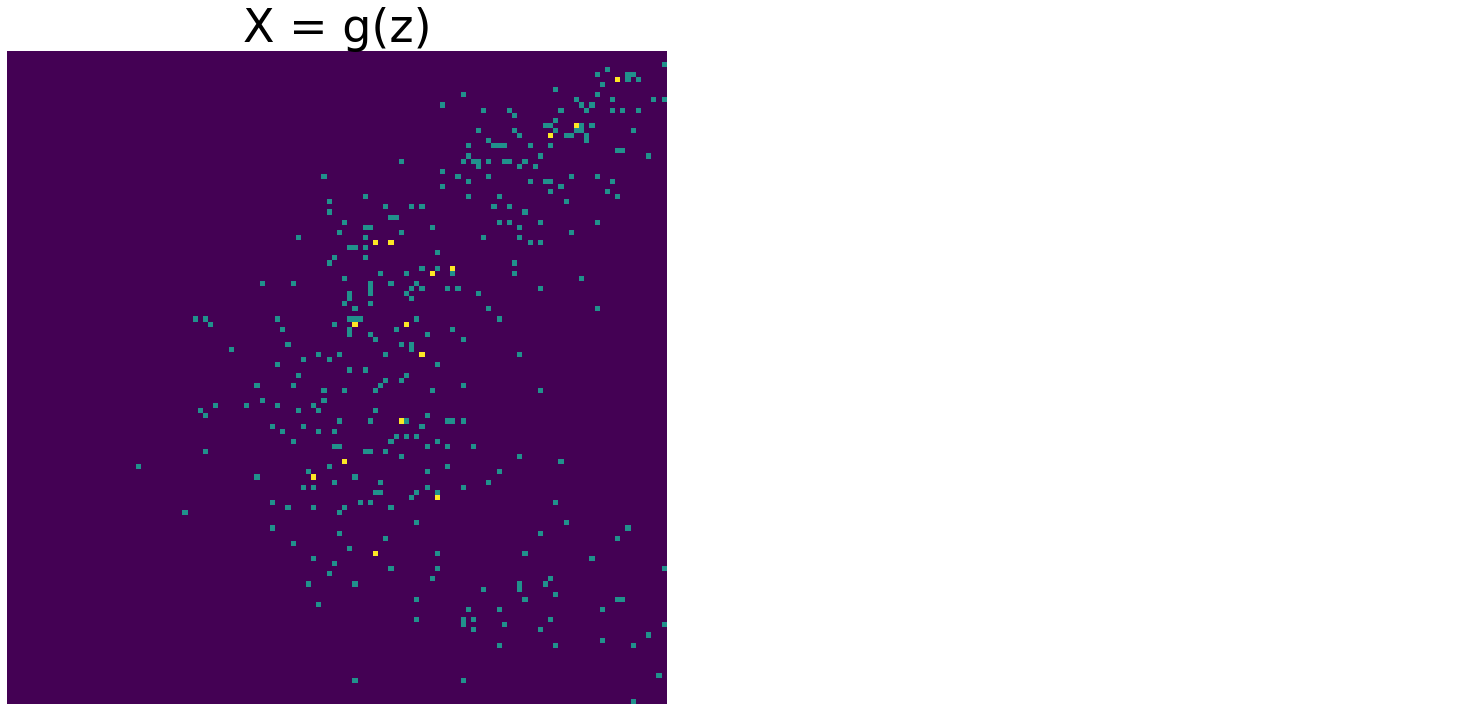

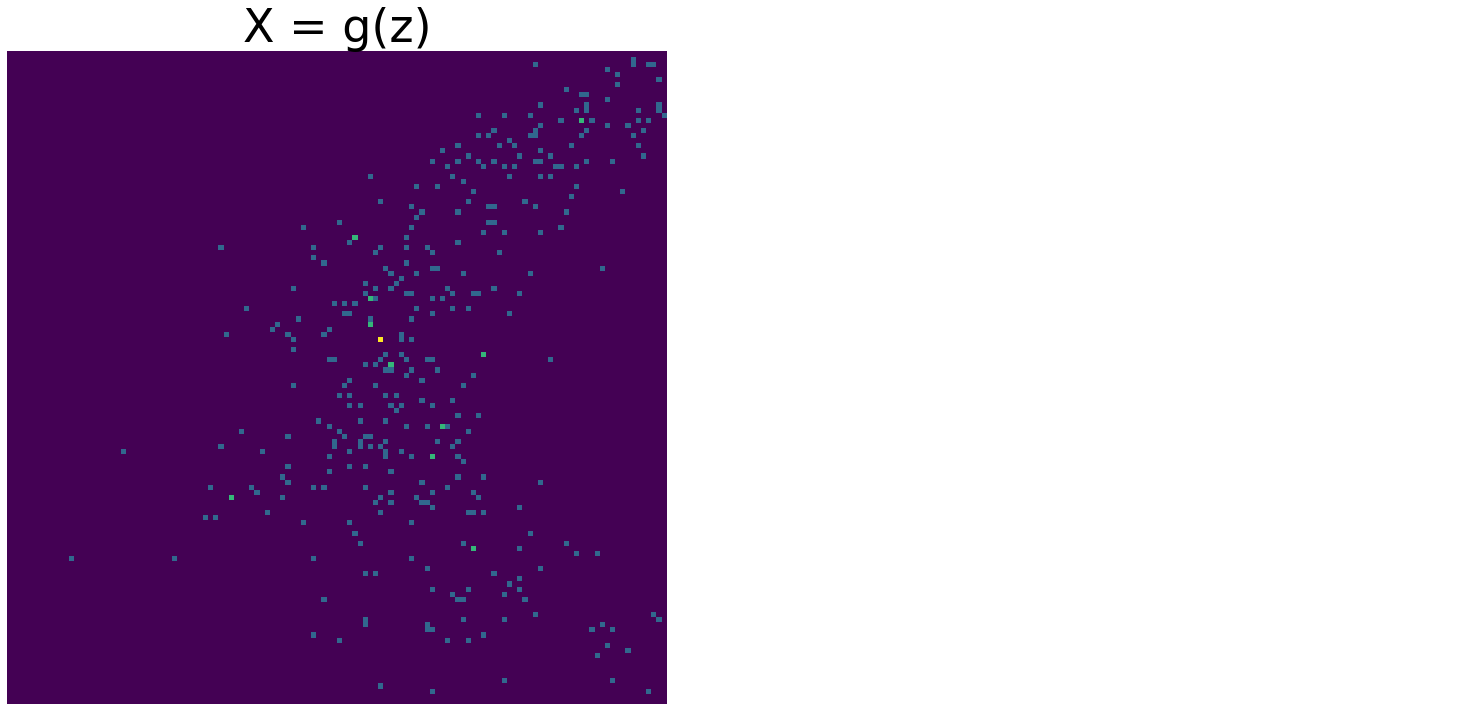

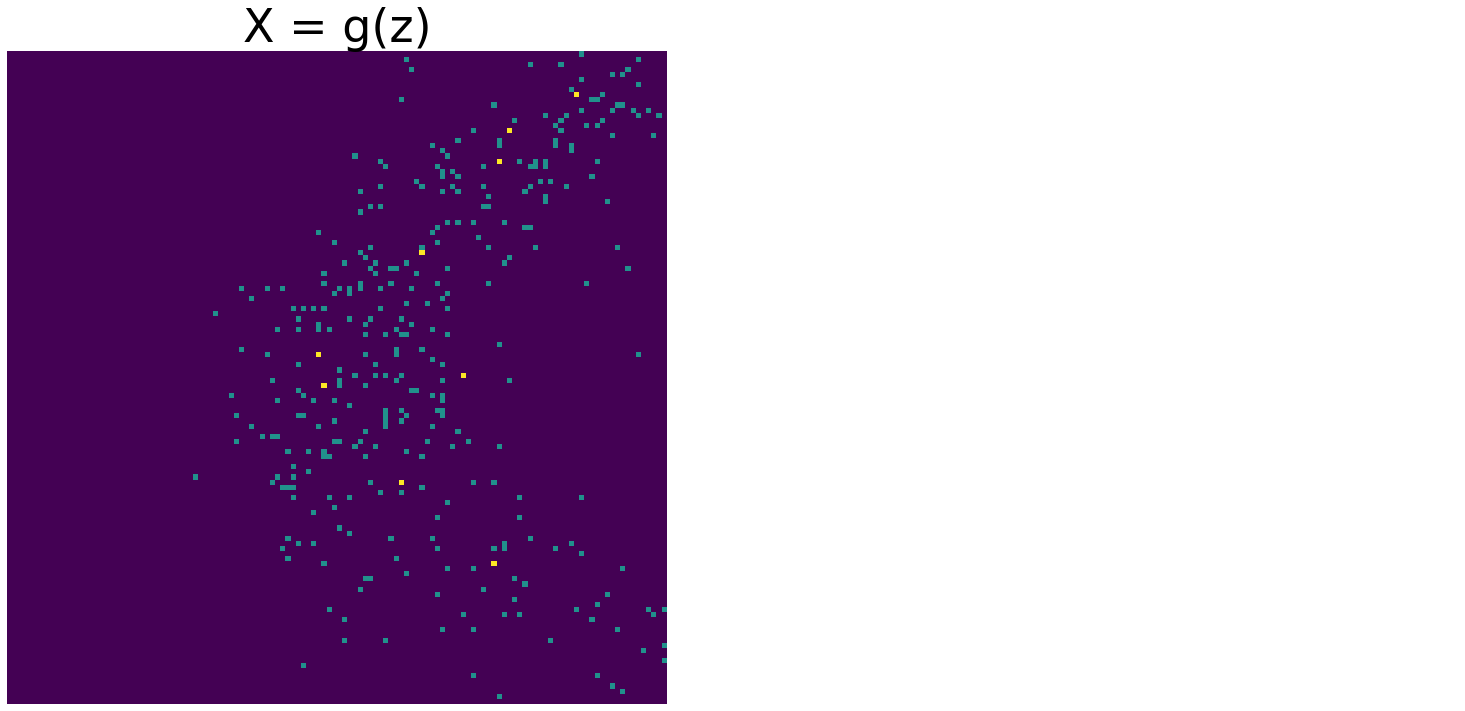

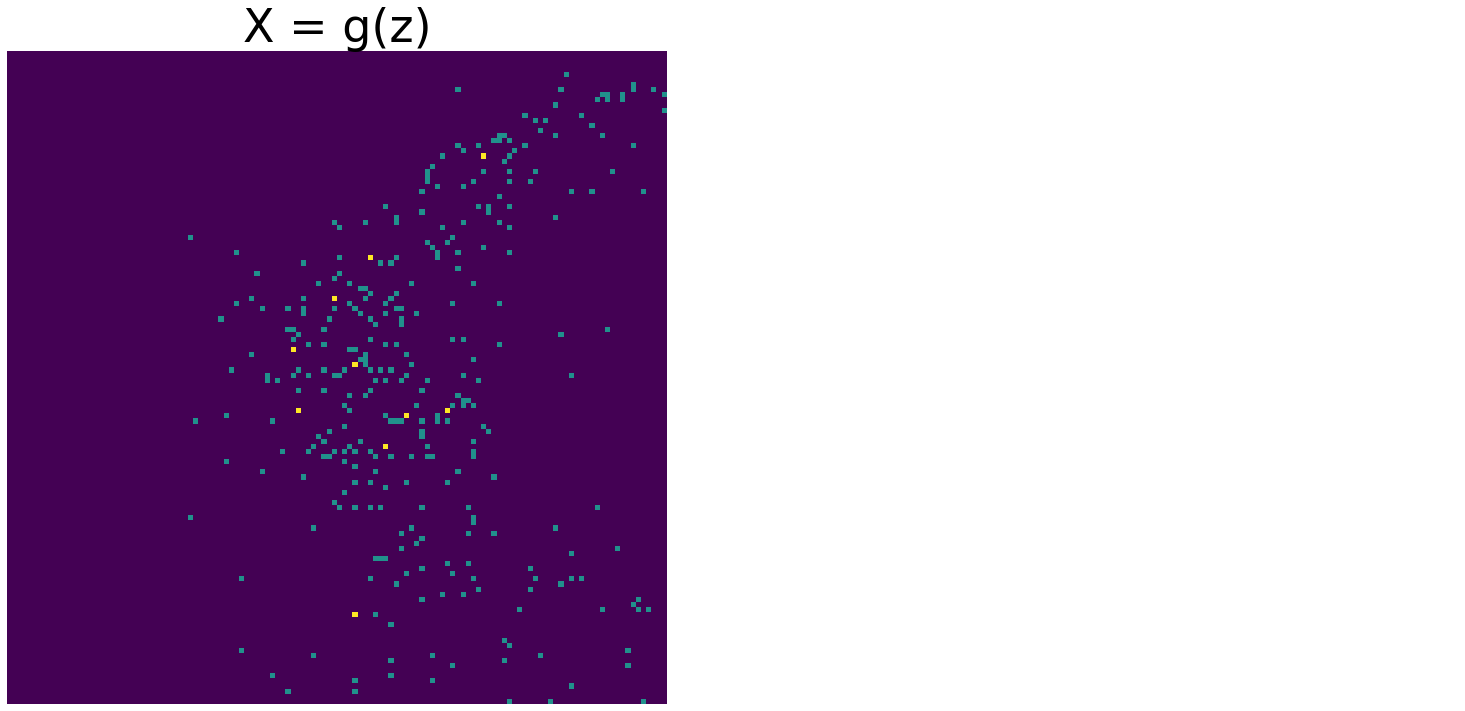

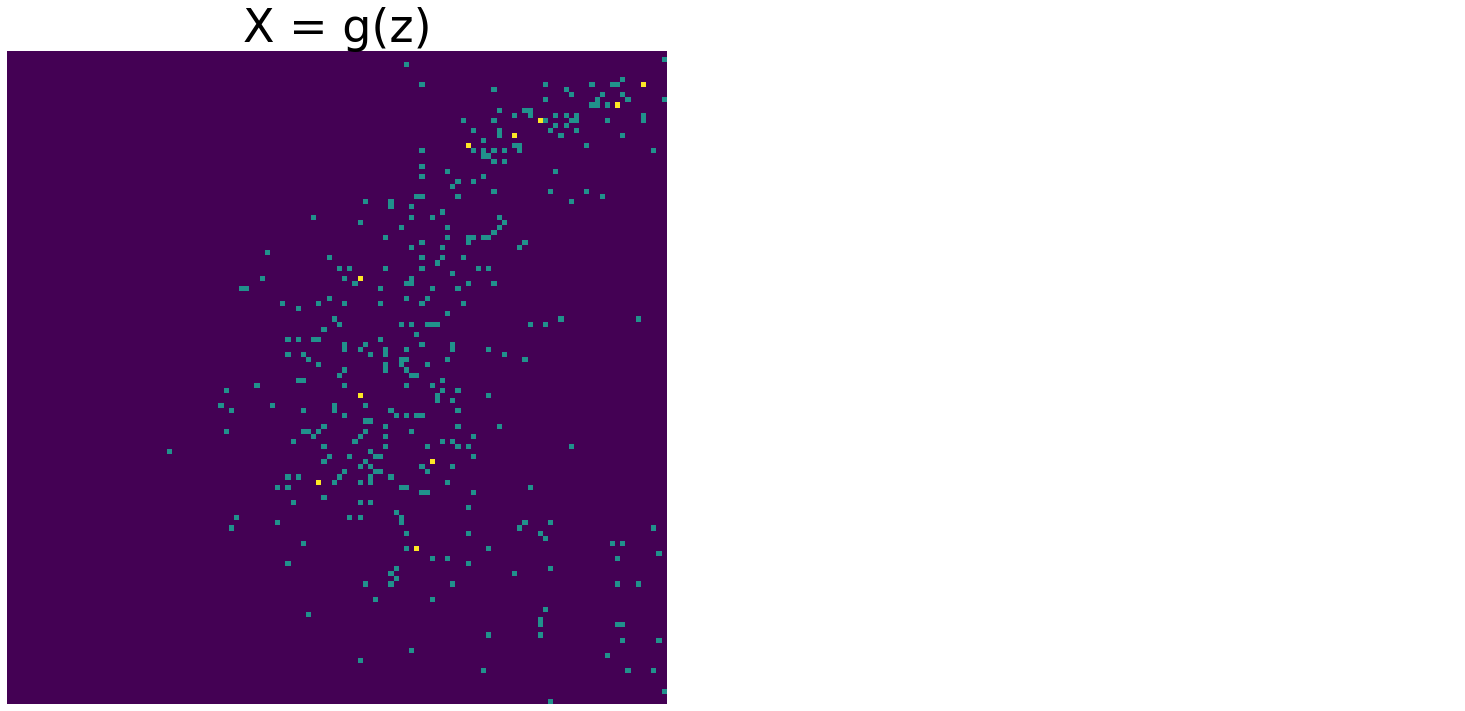

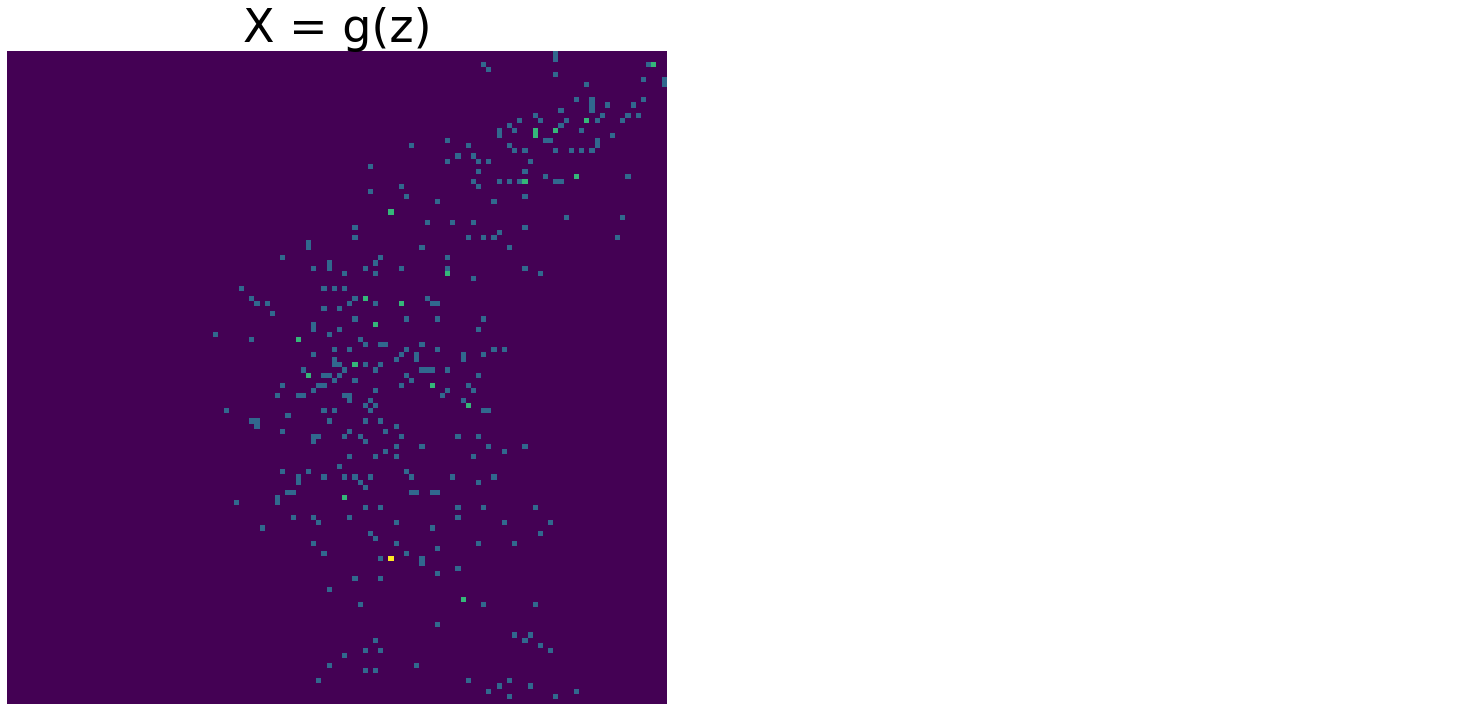

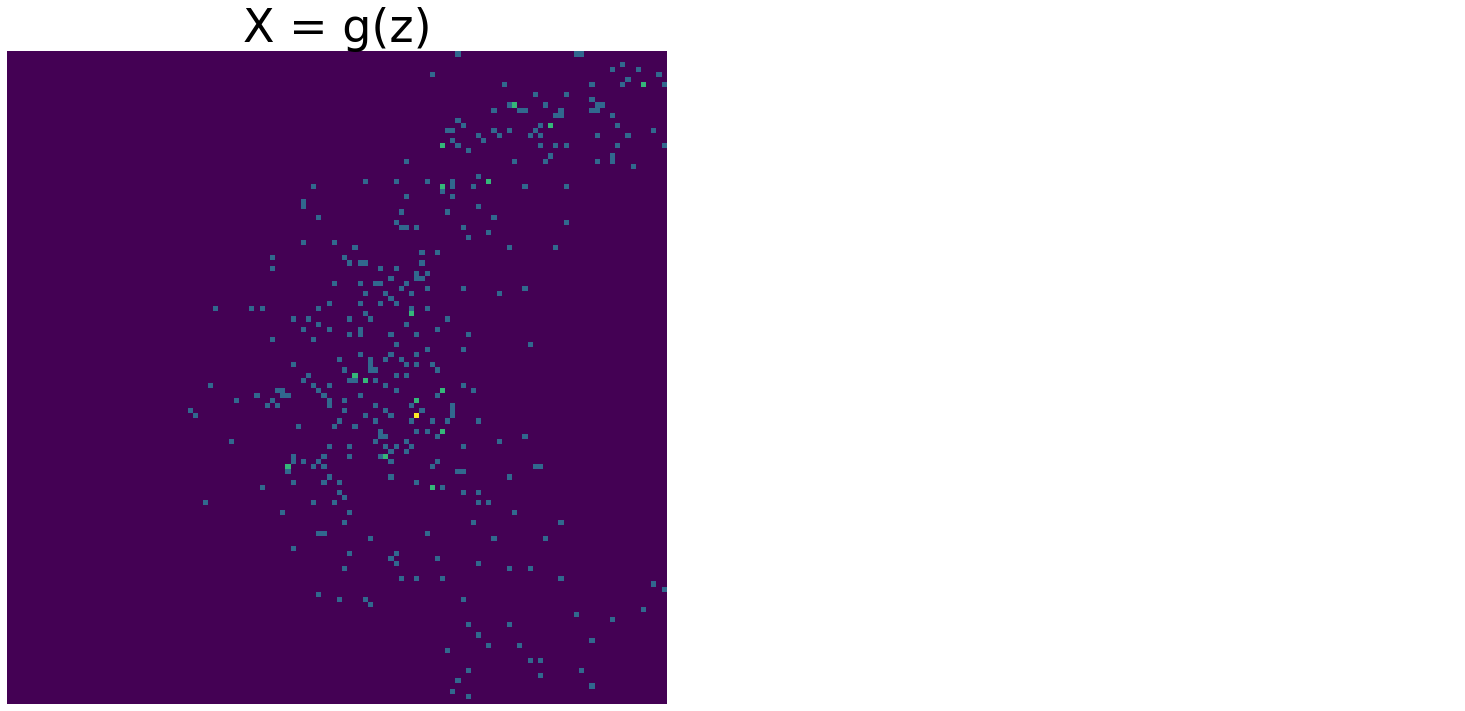

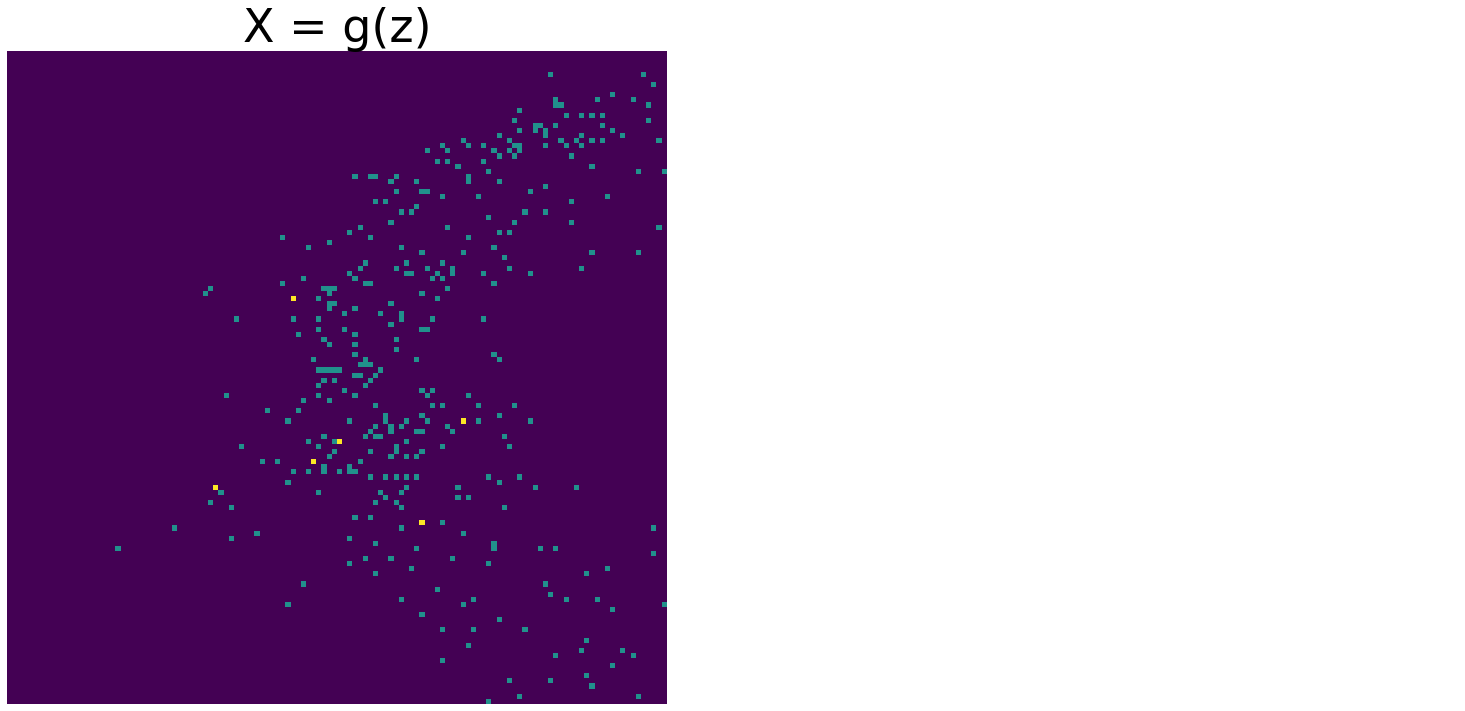

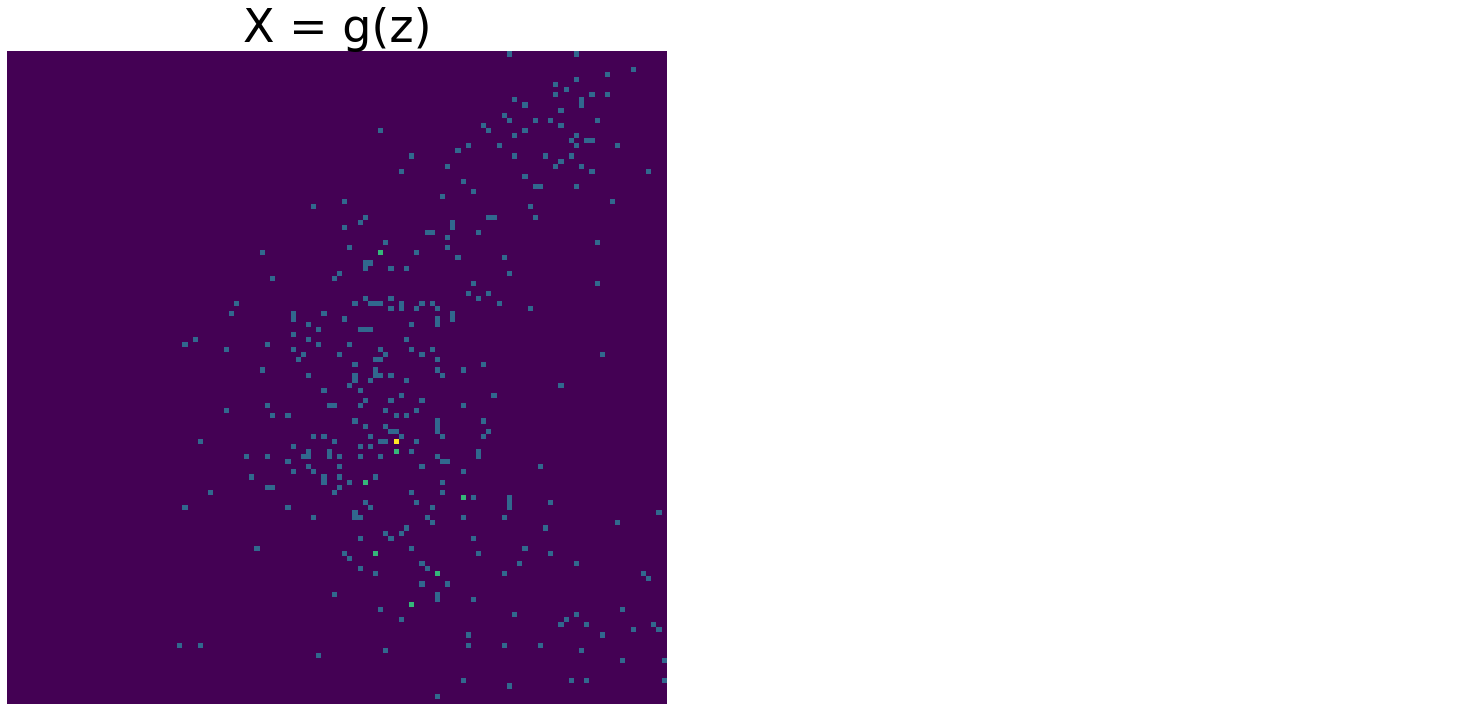

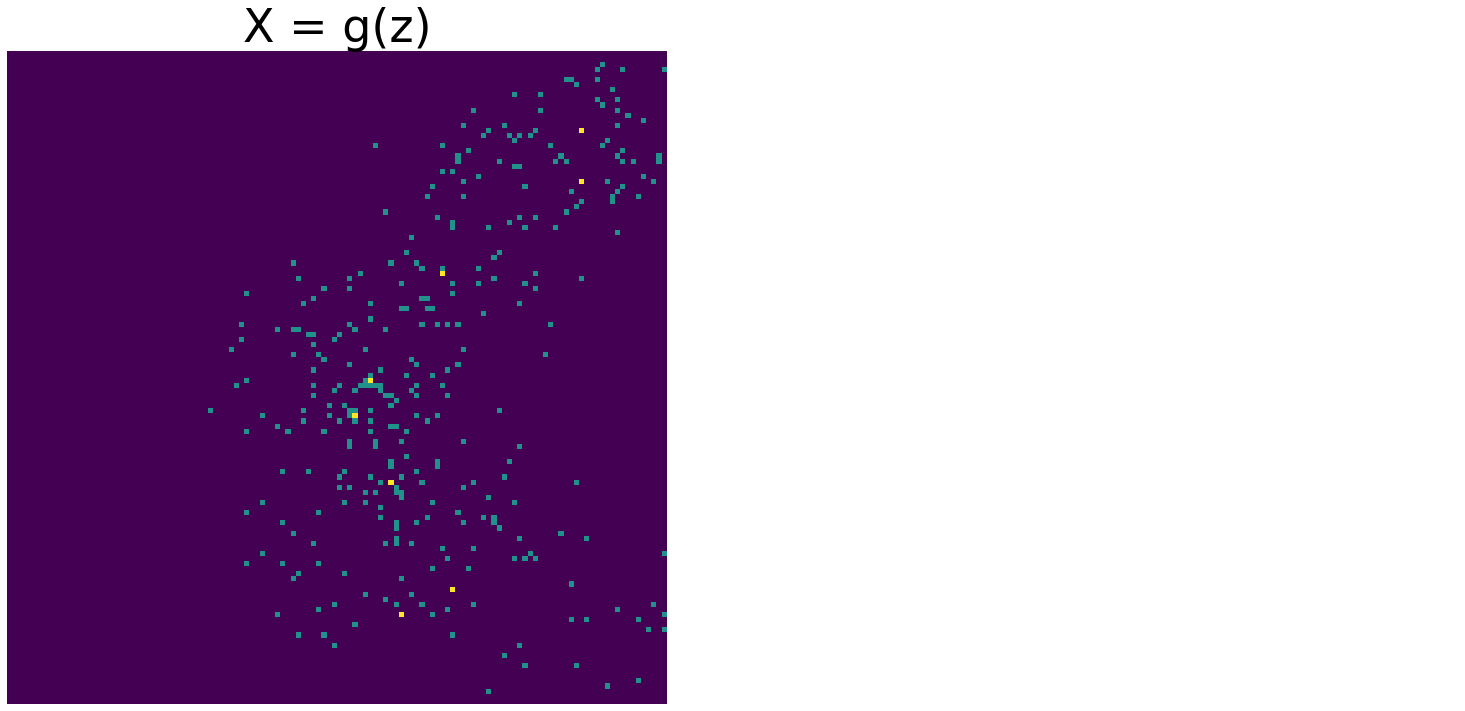

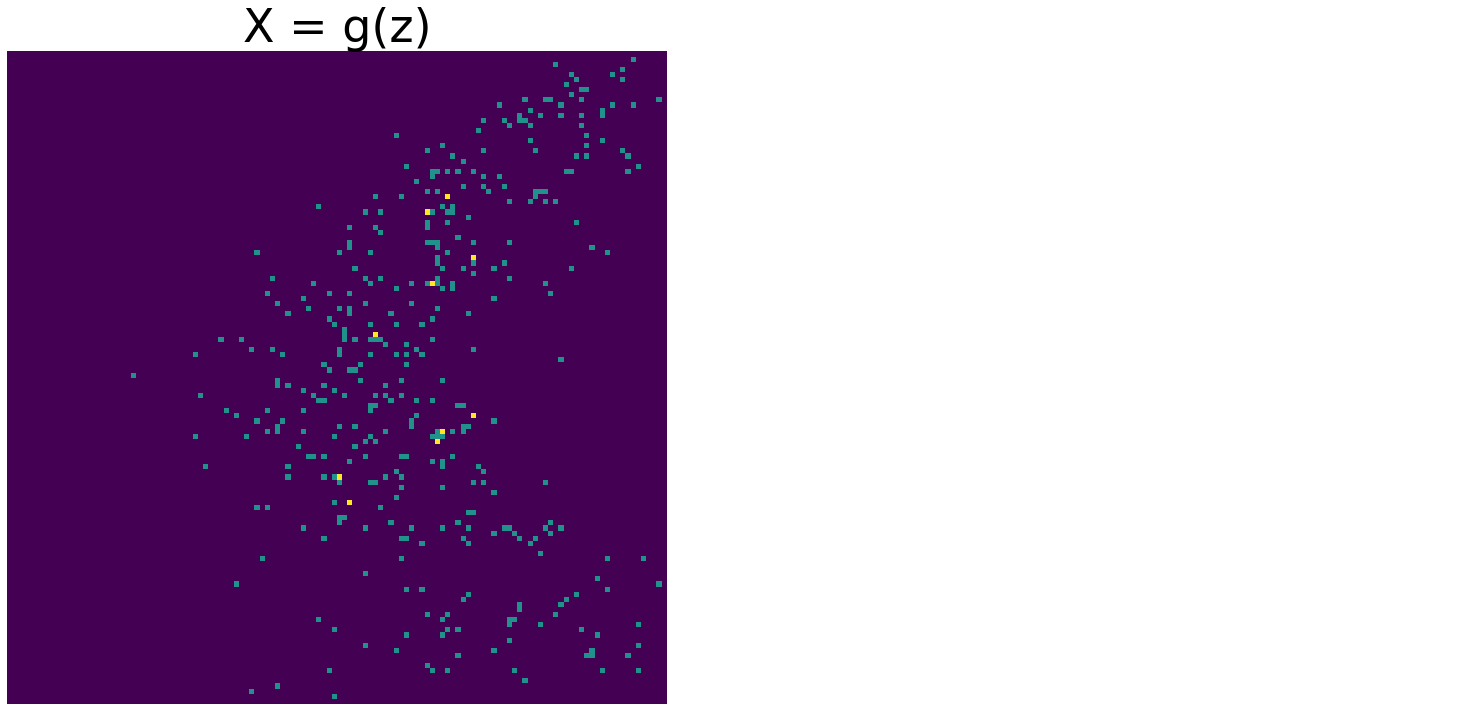

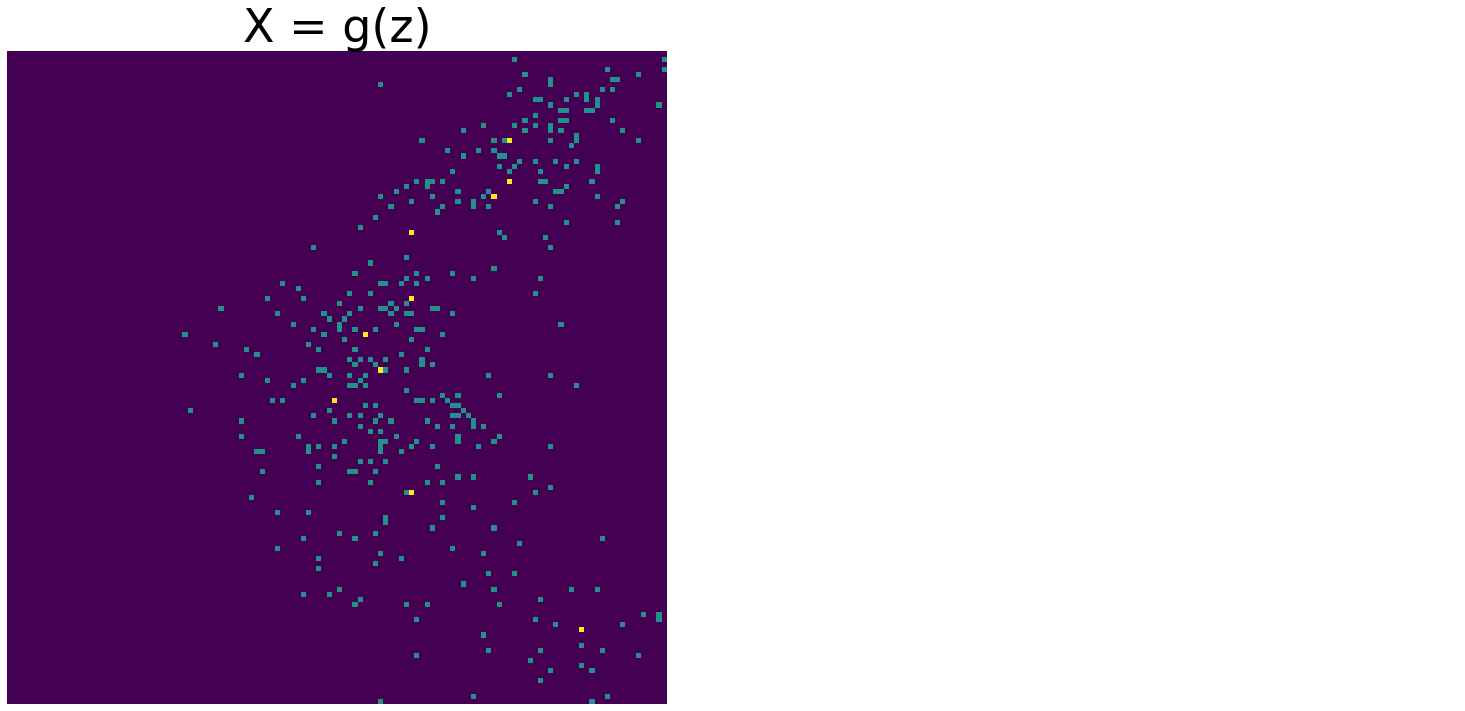

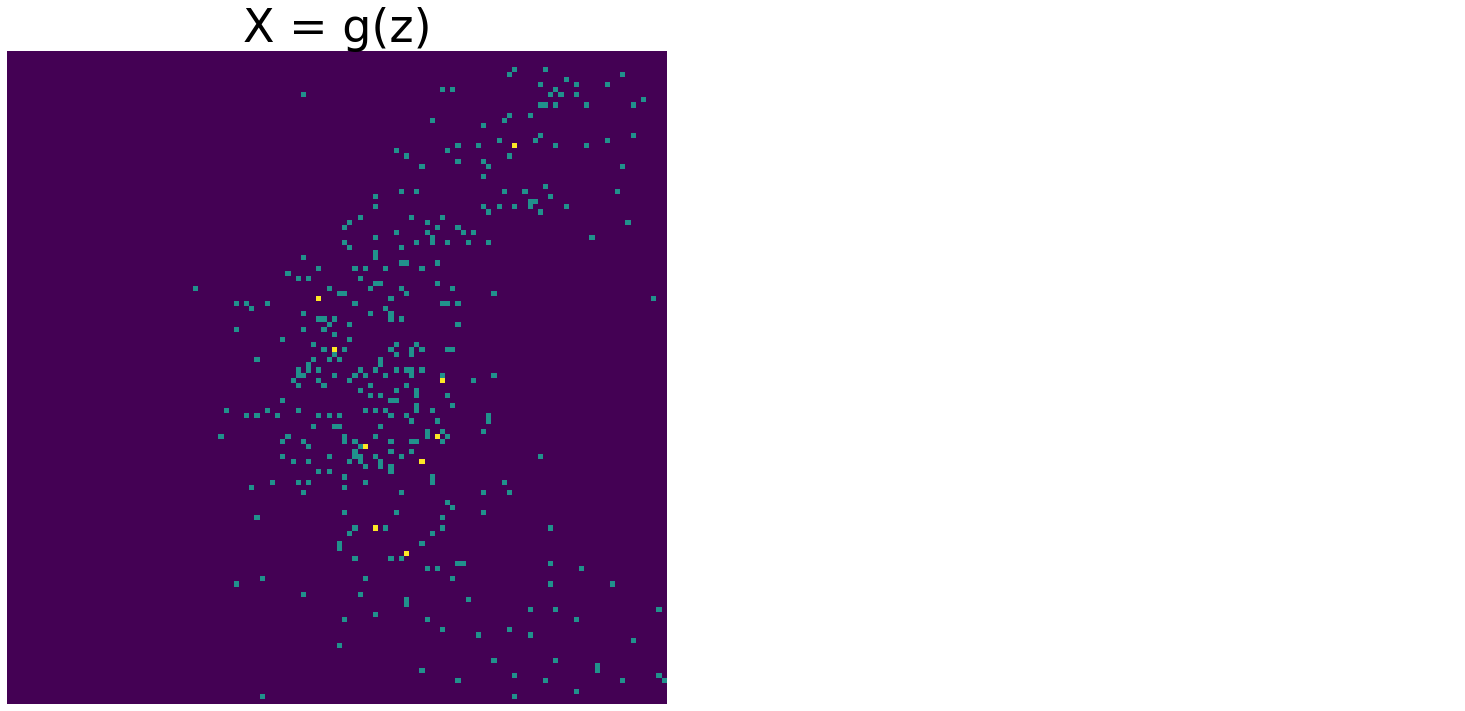

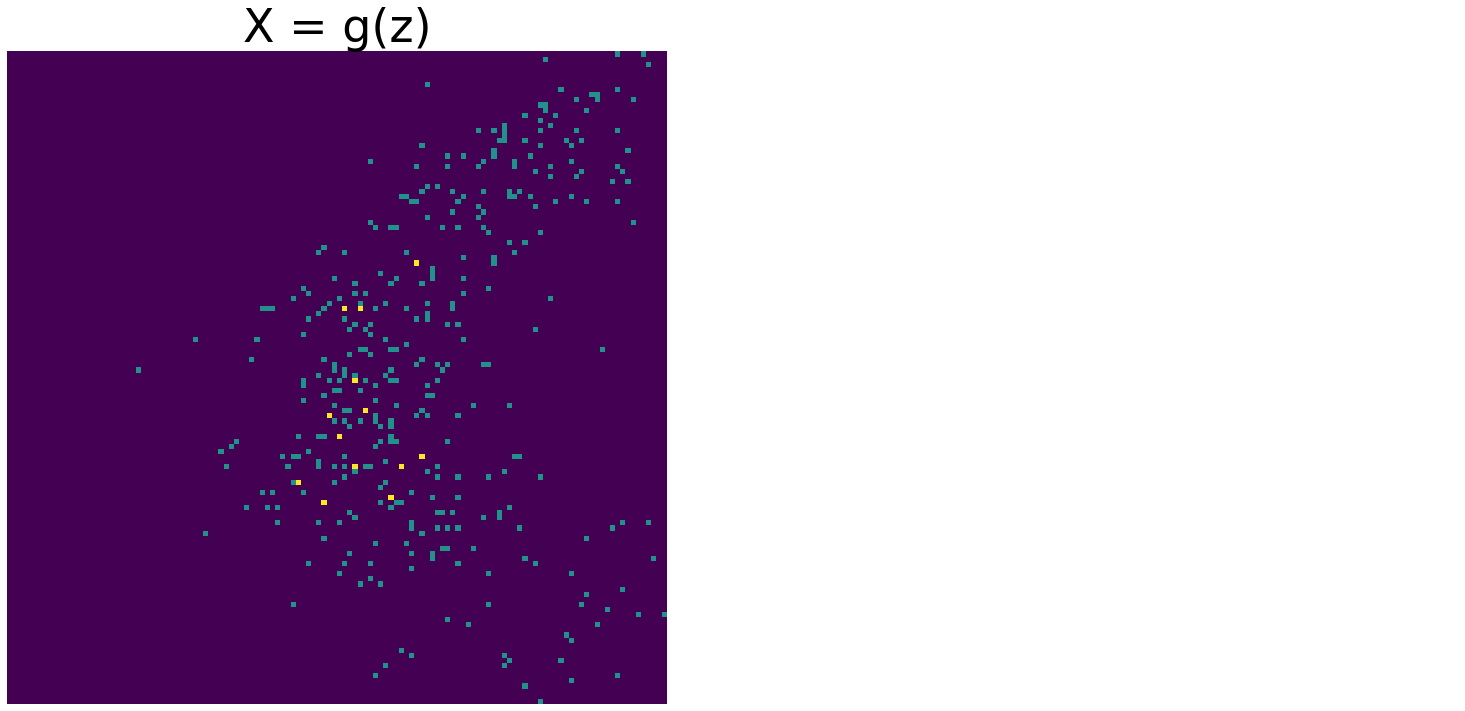

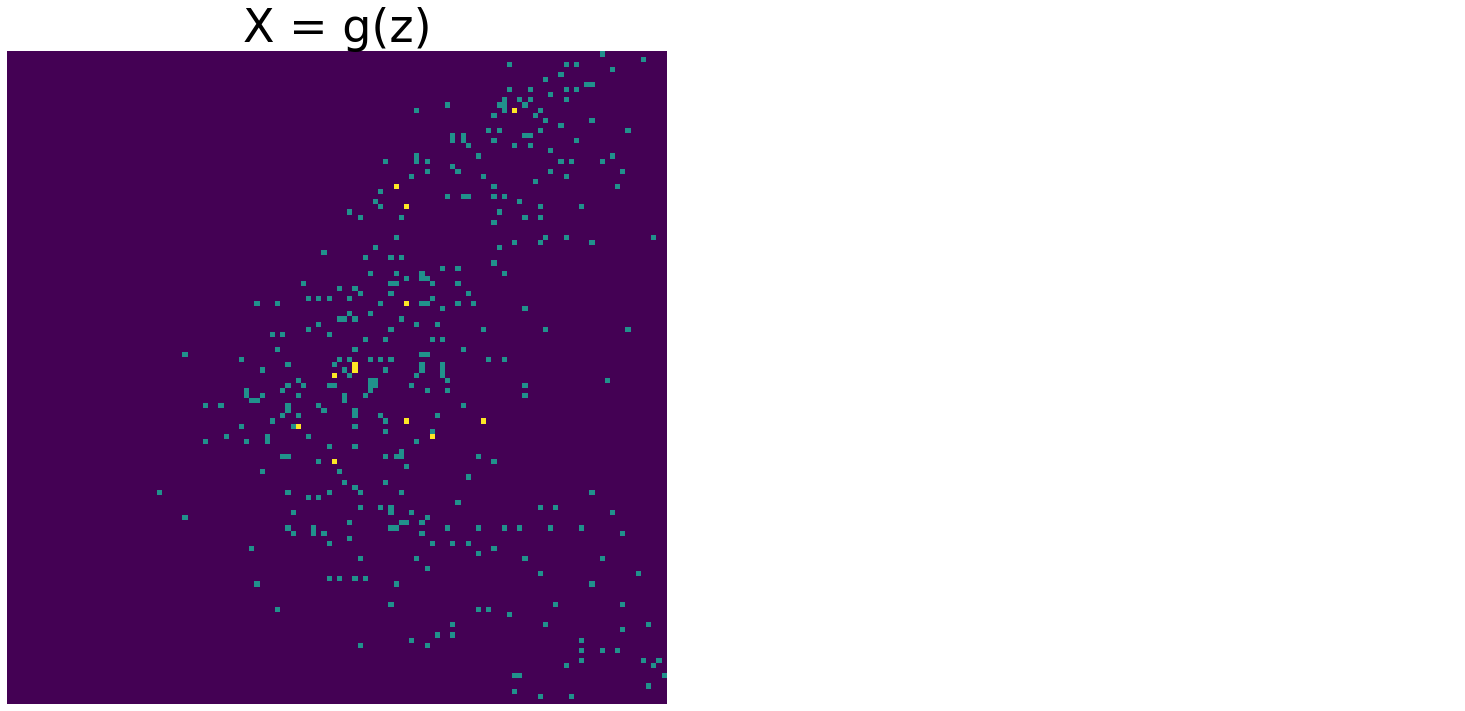

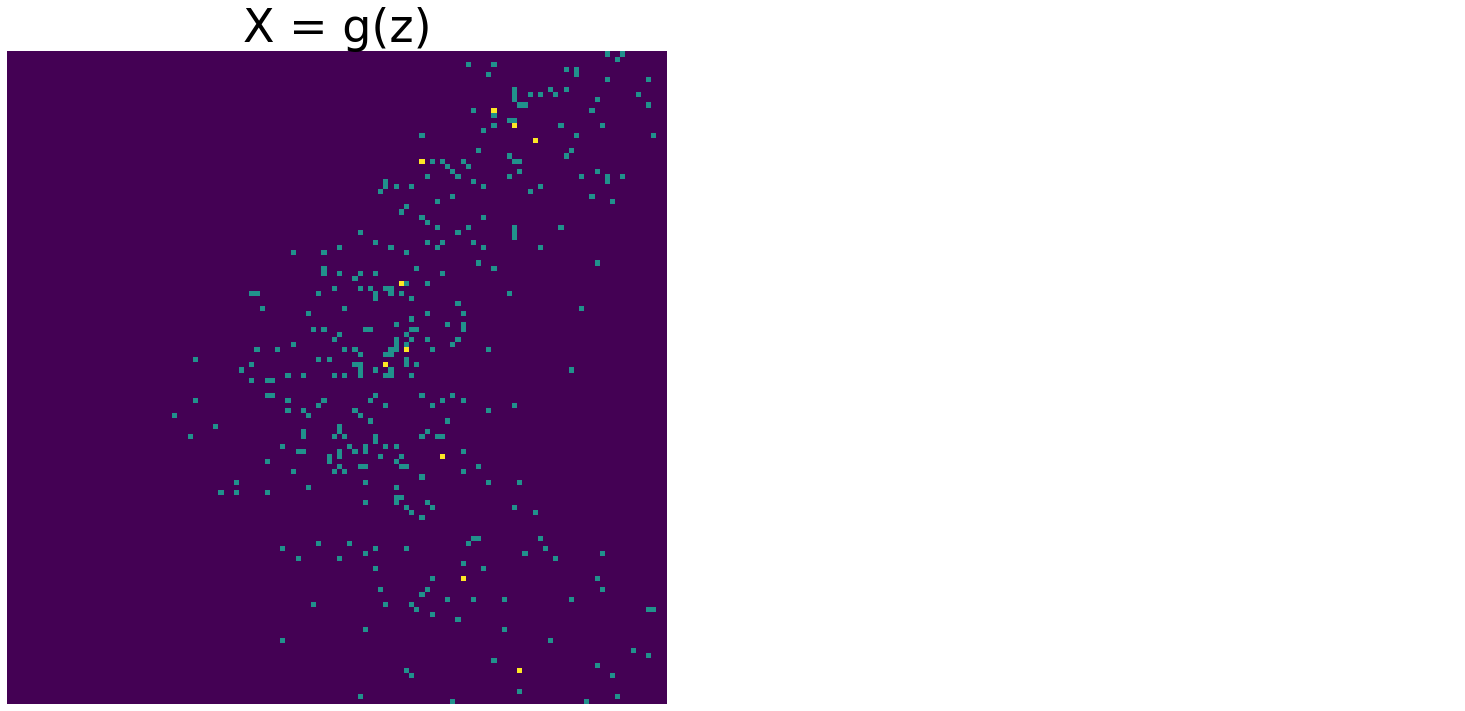

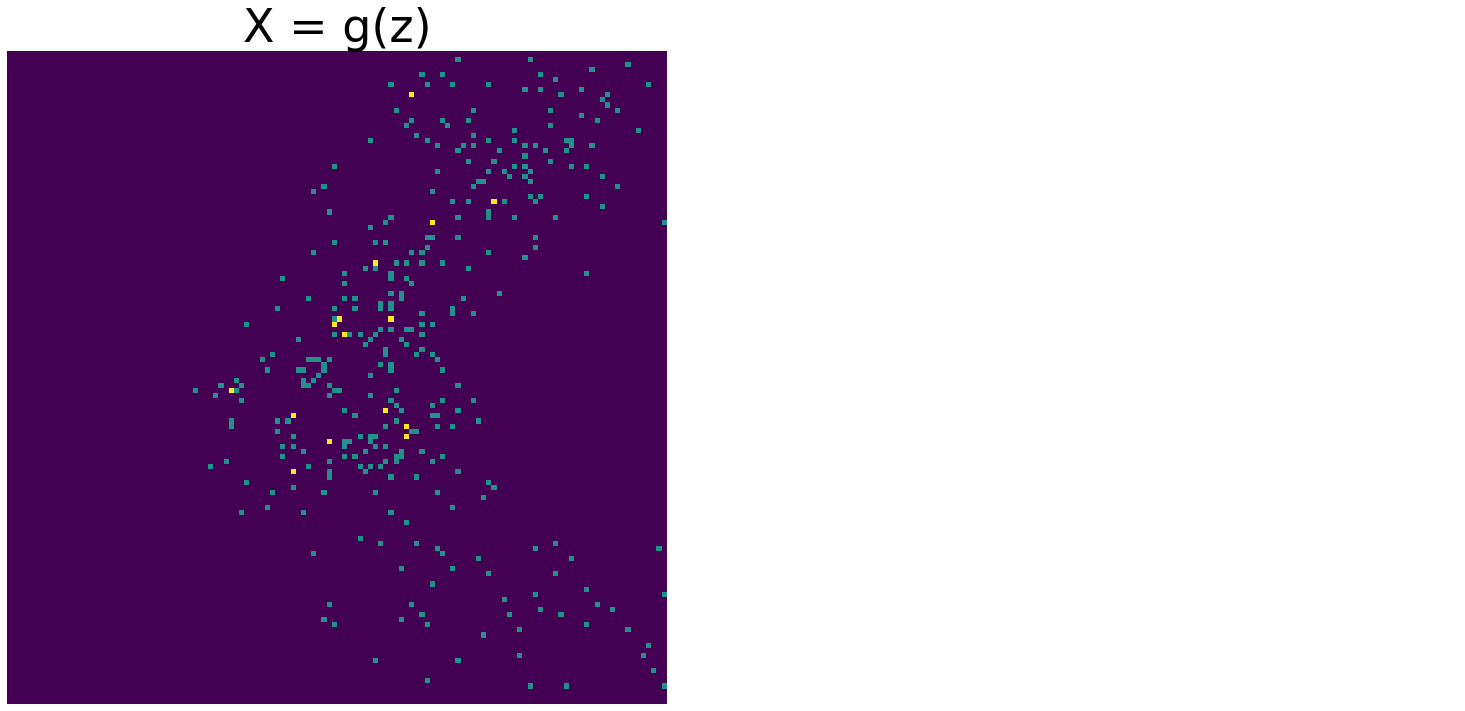

In [9]:
start  = time.time()

#Train

optimizer = torch.optim.Adam(flow_cnf.parameters(), lr=3e-3)

epochs = 100

print('Training...')
flow_cnf = flow_cnf.train()
ts = torch.tensor([t1, t0]).type(torch.float32).to(device) # for training, we flow the samples backward (in time) 
z0=[]

for epoch in range(1, epochs):
    ## saving for gifs
    z = flow_cnf.sample(450)[0]
    x_dash = flow_cnf.sample(450)[-1]
    fig = Data.plot_samples(x_dash, None, r'X = g(z)', None, 128)
    fig.savefig('images/CNF_'+ dset +'/'+ str(epoch) +'.jpg')
    
    loss_sum = 0.0
    for i, x in enumerate(train_dataloader):
        x1 = x.to(device)
        optimizer.zero_grad()
        # initialize initial densities
        logp_diff_t1 = torch.zeros(x1.size()[0], 1).type(torch.float32).to(device)

        # compute the backward solutions
        ip = (ts, x1, logp_diff_t1)
        z_t,  logp_diff_t  = flow_cnf.flow_outputs(ip) # outputs time first
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        z0.append(z_t0.detach().cpu())

        # compute the density of each sample
        logp_x = base_dist().log_prob(z_t0).to(device) - logp_diff_t0 #.view(-1)
        loss   = -logp_x.mean(0)
        loss.sum().backward()
        optimizer.step()
        loss_sum += loss.sum().detach().cpu().item()
        
    if epoch %1 == 0 :    
        print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch, epochs, loss_sum/len(train_dataloader)))
        
    if epoch % 5 == 0:
        torch.save(flow_cnf, 'models/CNF_'+ dset +'_model.pt')
        
flow_cnf = flow_cnf.eval()

end = time.time()
print('Training takes ', (end-start)/3600, ' hrs')
        


In [18]:
##making gifs

import imageio
import os


images = []
files = []

for dirpath,_,filenames in os.walk('images/CNF_'+ dset):
        for f in filenames:
            images.append(imageio.imread(os.path.join(dirpath, f)))
#             files.append(os.path.abspath(os.path.join(dirpath, f)))

imageio.mimsave('gifs/CNF_'+ dset+'.gif', images)

/home/mvasist/tmp/ipykernel_1091180/1506008995.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(dirpath, f)))


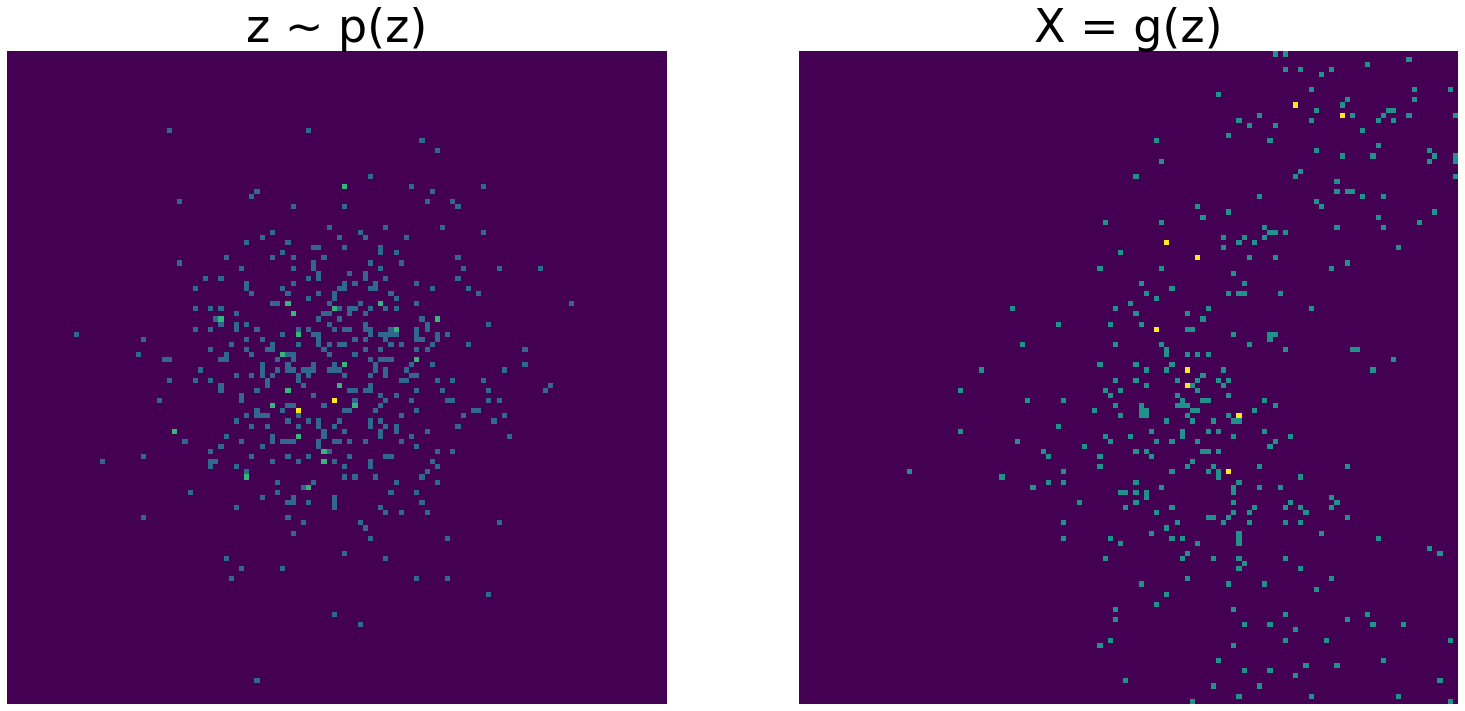

In [19]:
z = flow_cnf.sample(450)[0]
x_dash = flow_cnf.sample(450)[1]

fig = Data.plot_samples(z, x_dash, r'z ~ p(z)', r'X = g(z)', 128)
fig.savefig('results/CNF_'+ dset +'_1.pdf')

## Back to prior space

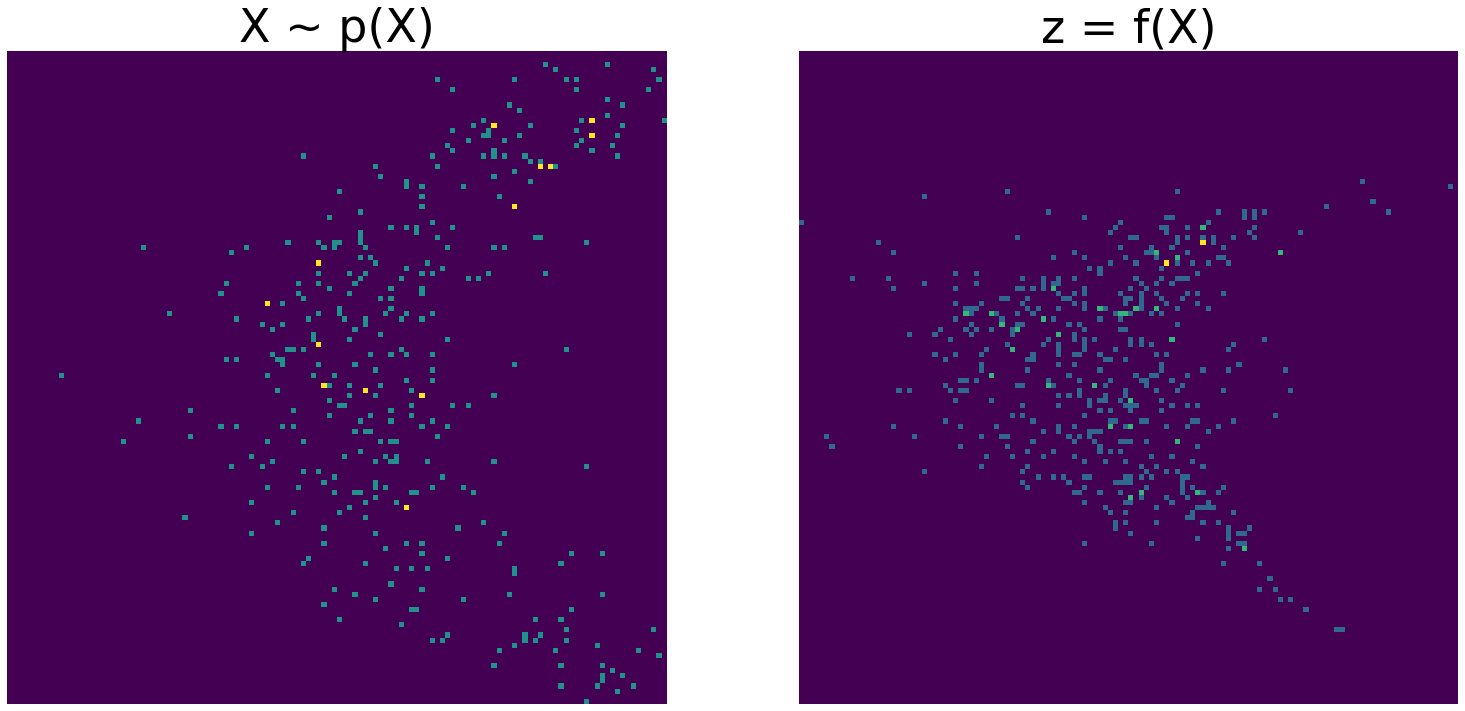

In [20]:
### After training

logp_diff_t1 = torch.zeros(d.size()[0], 1).type(torch.float32).to(device) 

ip = (ts, d, logp_diff_t1)
z_t,  logp_diff_t  = flow_cnf.flow_outputs(ip) # outputs time first
z_t0, _ = z_t[-1], logp_diff_t[-1]

fig = Data.plot_samples(d, z_t0, r'X ~ p(X)', r'z = f(X)', 128)
fig.savefig('results/CNF_'+ dset +'_2.pdf')

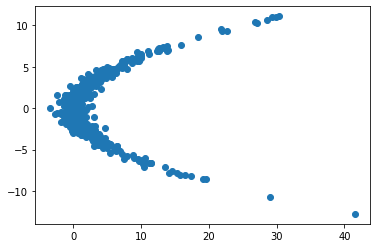

In [13]:
plt.scatter(d[:,0].cpu().numpy(), d[:,1].cpu().numpy())

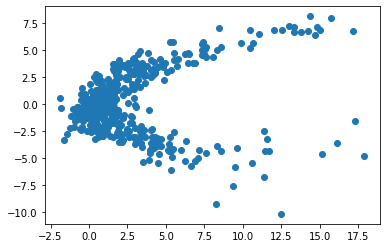

In [14]:
plt.scatter(x_dash[:,0].detach().cpu().numpy(), x_dash[:,1].detach().cpu().numpy())

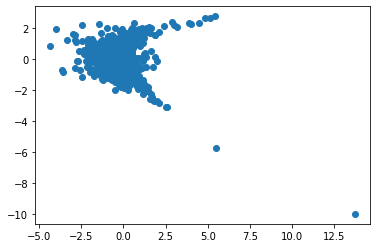

In [15]:
plt.scatter(z_t0[:,0].detach().cpu().numpy(), z_t0[:,1].detach().cpu().numpy())

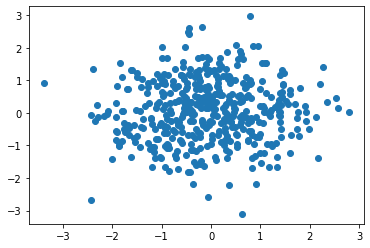

In [16]:
plt.scatter(z[:,0].detach().cpu().numpy(), z[:,1].detach().cpu().numpy())